# Covid-19 Dataset Classification - Classes 0&2 / 1

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, StackingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from scipy.stats import mode
from tqdm import tqdm
from sklearn.datasets import make_classification



In [ ]:
file_path = '/Final_dataset_Classific.xlsx'  
dataset = pd.read_excel(file_path)

In [ ]:
cols_to_drop = dataset.filter(like='Medication_').columns
dataset = dataset.drop(columns=cols_to_drop)

In [5]:
dataset = dataset.drop(columns='FIO2 eisagwgh_cleaned')

In [ ]:
# Combine classes 0 and 2 into one class (0) and update the dataset
dataset['Outcome_numerical'] = dataset['Outcome_numerical'].replace(2, 0)  # Correctly combine 0 and 2 into 0

# Define the features (X) and the target (y) based on the filtered dataset
X = dataset.drop(columns=['Outcome_numerical'])
y = dataset['Outcome_numerical']

# Split the filtered data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.45, random_state=42)

# Standardize features for the filtered datasets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Confirm the sizes of the datasets after filtering and splitting
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(258, 106) (212, 106) (258,) (212,)


In [ ]:
cluster_counts = dataset['Outcome_numerical'].value_counts()
cluster_counts

1    273
0    197
Name: Outcome_numerical, dtype: int64

# SMOTE model check

Original class distribution: Counter({1: 149, 0: 109})
SMOTE class distribution: Counter({1: 149, 0: 149})
                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.834906   0.837005  0.834906  0.835487
Random Forest        0.839623   0.839623  0.839623  0.839623
Gradient Boosting    0.849057   0.848684  0.849057  0.848793
SVM                  0.811321   0.815550  0.811321  0.812278
XGB                  0.825472   0.824870  0.825472  0.825001
Bagging Classifier   0.787736   0.792908  0.787736  0.788902
Decision Tree        0.716981   0.714437  0.716981  0.714665


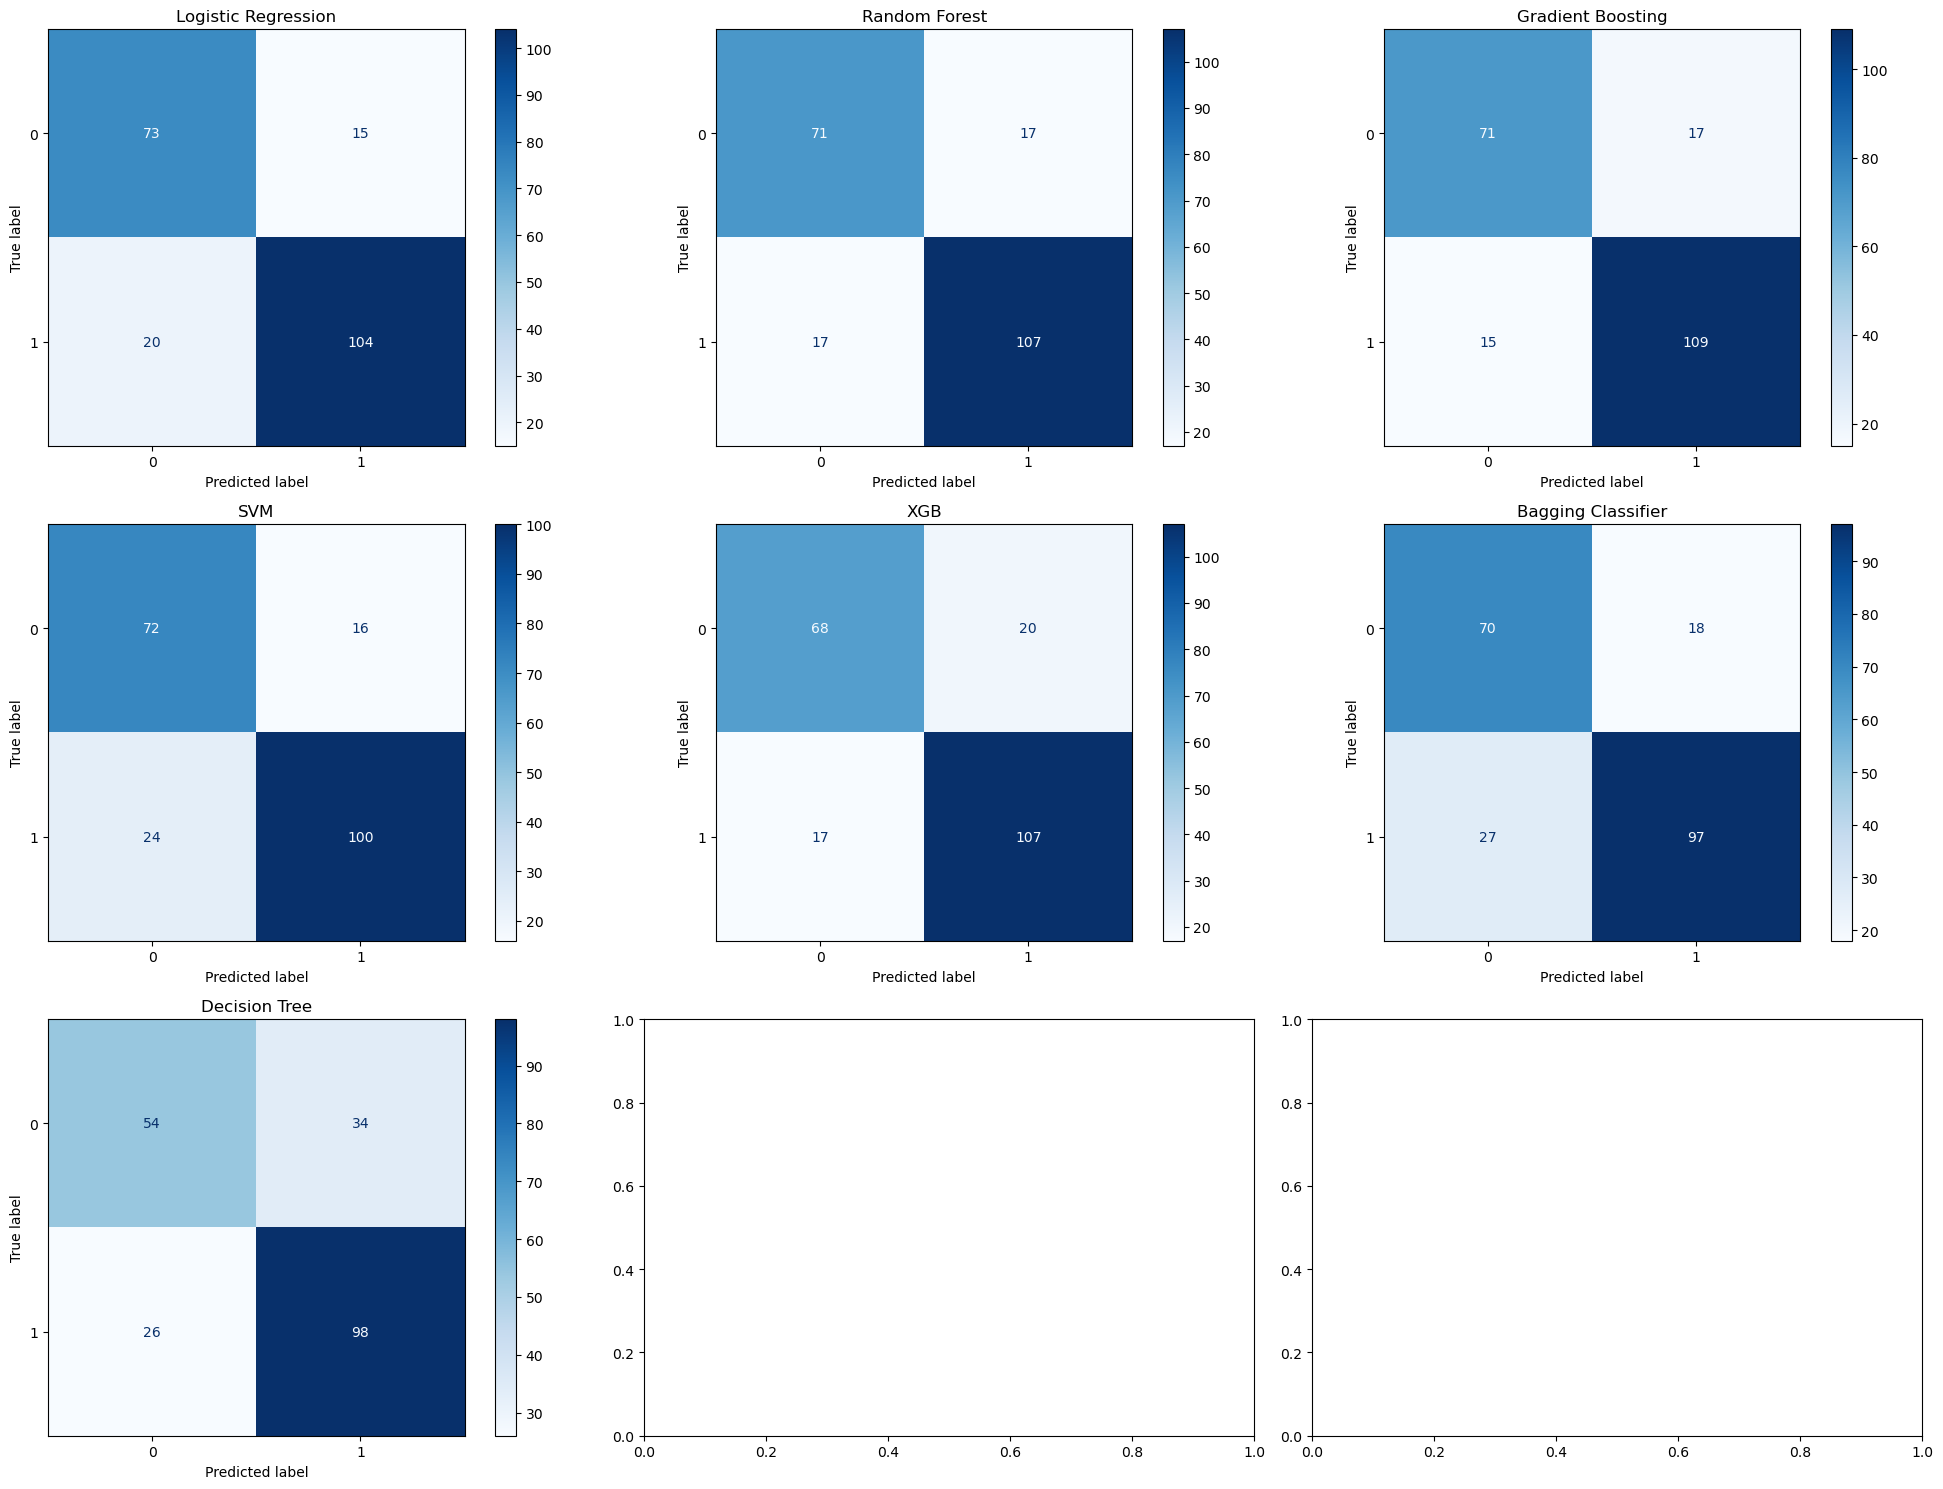

In [8]:
# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print(f"Original class distribution: {Counter(y_train)}")
print(f"SMOTE class distribution: {Counter(y_train_smote)}")

# Initialize all models
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, objective='binary:logistic'),
    'Bagging Classifier': BaggingClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Dictionary to hold the results and confusion matrices
results = {}
conf_matrices = {}

# Train, evaluate each model using the SMOTE-balanced data, and store confusion matrices
for name, model in models.items():
    # Train the model on the balanced dataset
    model.fit(X_train_smote, y_train_smote)
    
    # Predict on the testing set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
    }
    
    # Store confusion matrix
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results).T

# Display results
print(results_df)

# Visualization of Confusion Matrices
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
for ax, (name, matrix) in zip(axes.flatten(), conf_matrices.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    ax.title.set_text(name)
plt.tight_layout()
plt.show()


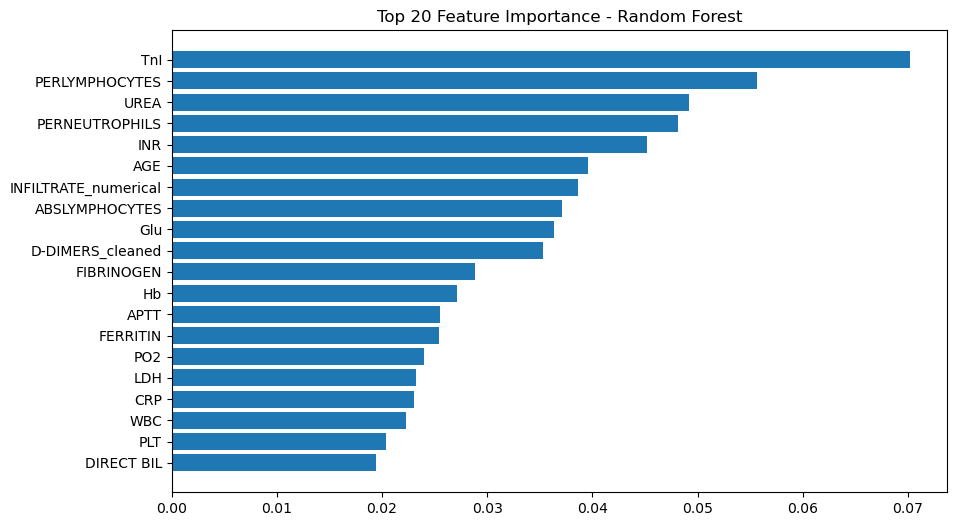

In [9]:
importances_rf = models['Random Forest'].feature_importances_
indices_rf = np.argsort(importances_rf)[-20:]  # Top 10 features
feature_names = X_train.columns
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importance - Random Forest")
plt.barh(range(20), importances_rf[indices_rf], align='center')
plt.yticks(np.arange(20), [feature_names[i] for i in indices_rf])
plt.gca()
plt.show()


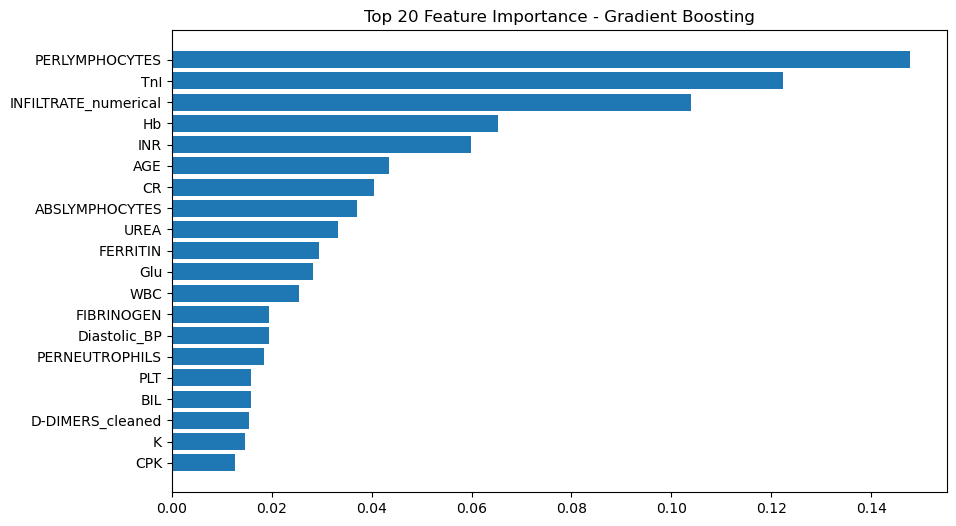

In [10]:
importances_gb = models['Gradient Boosting'].feature_importances_
indices_gb = np.argsort(importances_gb)[-20:]  

plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importance - Gradient Boosting")
plt.barh(range(20), importances_gb[indices_gb], align='center')
plt.yticks(np.arange(20), [feature_names[i] for i in indices_gb])
plt.gca()
plt.show()


<Figure size 1000x600 with 0 Axes>

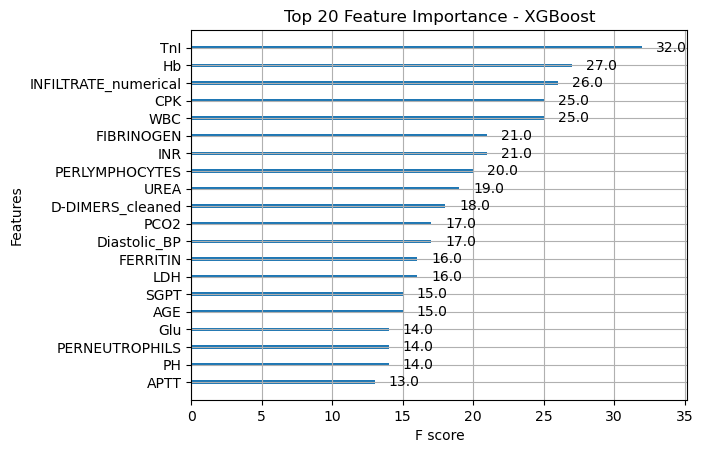

In [11]:
from xgboost import plot_importance

# Plotting top 20 features
plt.figure(figsize=(10, 6))
plot_importance(models['XGB'], max_num_features=20, importance_type='weight', title="Top 20 Feature Importance - XGBoost")
plt.show()


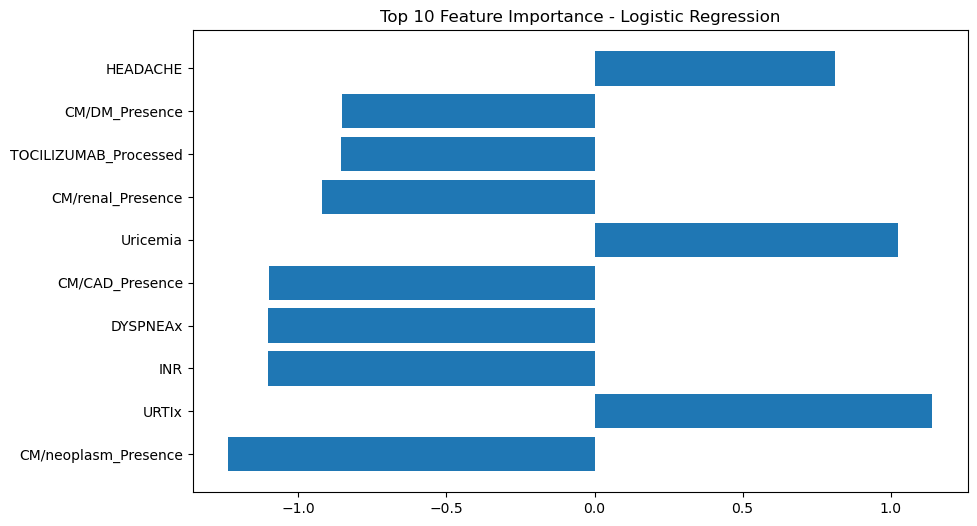

In [ ]:
coef_lr = models['Logistic Regression'].coef_[0]
indices_lr = np.argsort(np.abs(coef_lr))[-10:]

plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importance - Logistic Regression")
plt.barh(range(10), coef_lr[indices_lr], align='center')
plt.yticks(np.arange(10), [feature_names[i] for i in indices_lr])
plt.gca().invert_yaxis()
plt.show()


# MStacked model check

# Meta learners optimization

In [ ]:
# Function to evaluate and print metrics
def evaluate_voting(name, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title(f'Confusion Matrix for {name}')
    plt.show()
    
# Definitions remain the same
meta_learners = [
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100,random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42))
]

base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(kernel='linear', probability=True, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
]

# Initialize dictionaries
results = {}
conf_matrices = {}
stacked_predictions = {}

# Training and evaluation
for name, meta_learner in tqdm(meta_learners, desc="Training Meta-learners"):
    print(f"\nTraining Stacked Model with {name} as meta-learner...")
    stacked_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5, n_jobs=-1)
    stacked_model.fit(X_train_smote, y_train_smote)
    y_pred_stacked = stacked_model.predict(X_test)
    stacked_predictions[name] = y_pred_stacked  # Store predictions for voting

    # Metrics
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred_stacked),
        'Precision': precision_score(y_test, y_pred_stacked, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred_stacked, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_test, y_pred_stacked, average='weighted', zero_division=0)
    }

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred_stacked)
    conf_matrices[name] = conf_matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    
    # Visualization
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title(f'Confusion Matrix for {name}')
    plt.show()
for meta_learner, metrics in results.items():
    print(f"\n{meta_learner} Meta-learner Results:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
# Convert predictions to an array for voting
all_preds = np.array(list(stacked_predictions.values()))

# Hard Voting
hard_votes = mode(all_preds, axis=0).mode[0]  
# Evaluate hard voting ensemble
evaluate_voting('Hard Voting', y_test, hard_votes)




# Simple Data Models check

                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.863208   0.864175  0.863208  0.863516
Random Forest        0.834906   0.834492  0.834906  0.833753
Gradient Boosting    0.825472   0.824765  0.825472  0.824645
SVM                  0.825472   0.825213  0.825472  0.825324
xgb                  0.830189   0.829746  0.830189  0.829892
Bagging Classifier   0.773585   0.773585  0.773585  0.773585
Decision Tree        0.702830   0.708619  0.702830  0.704463


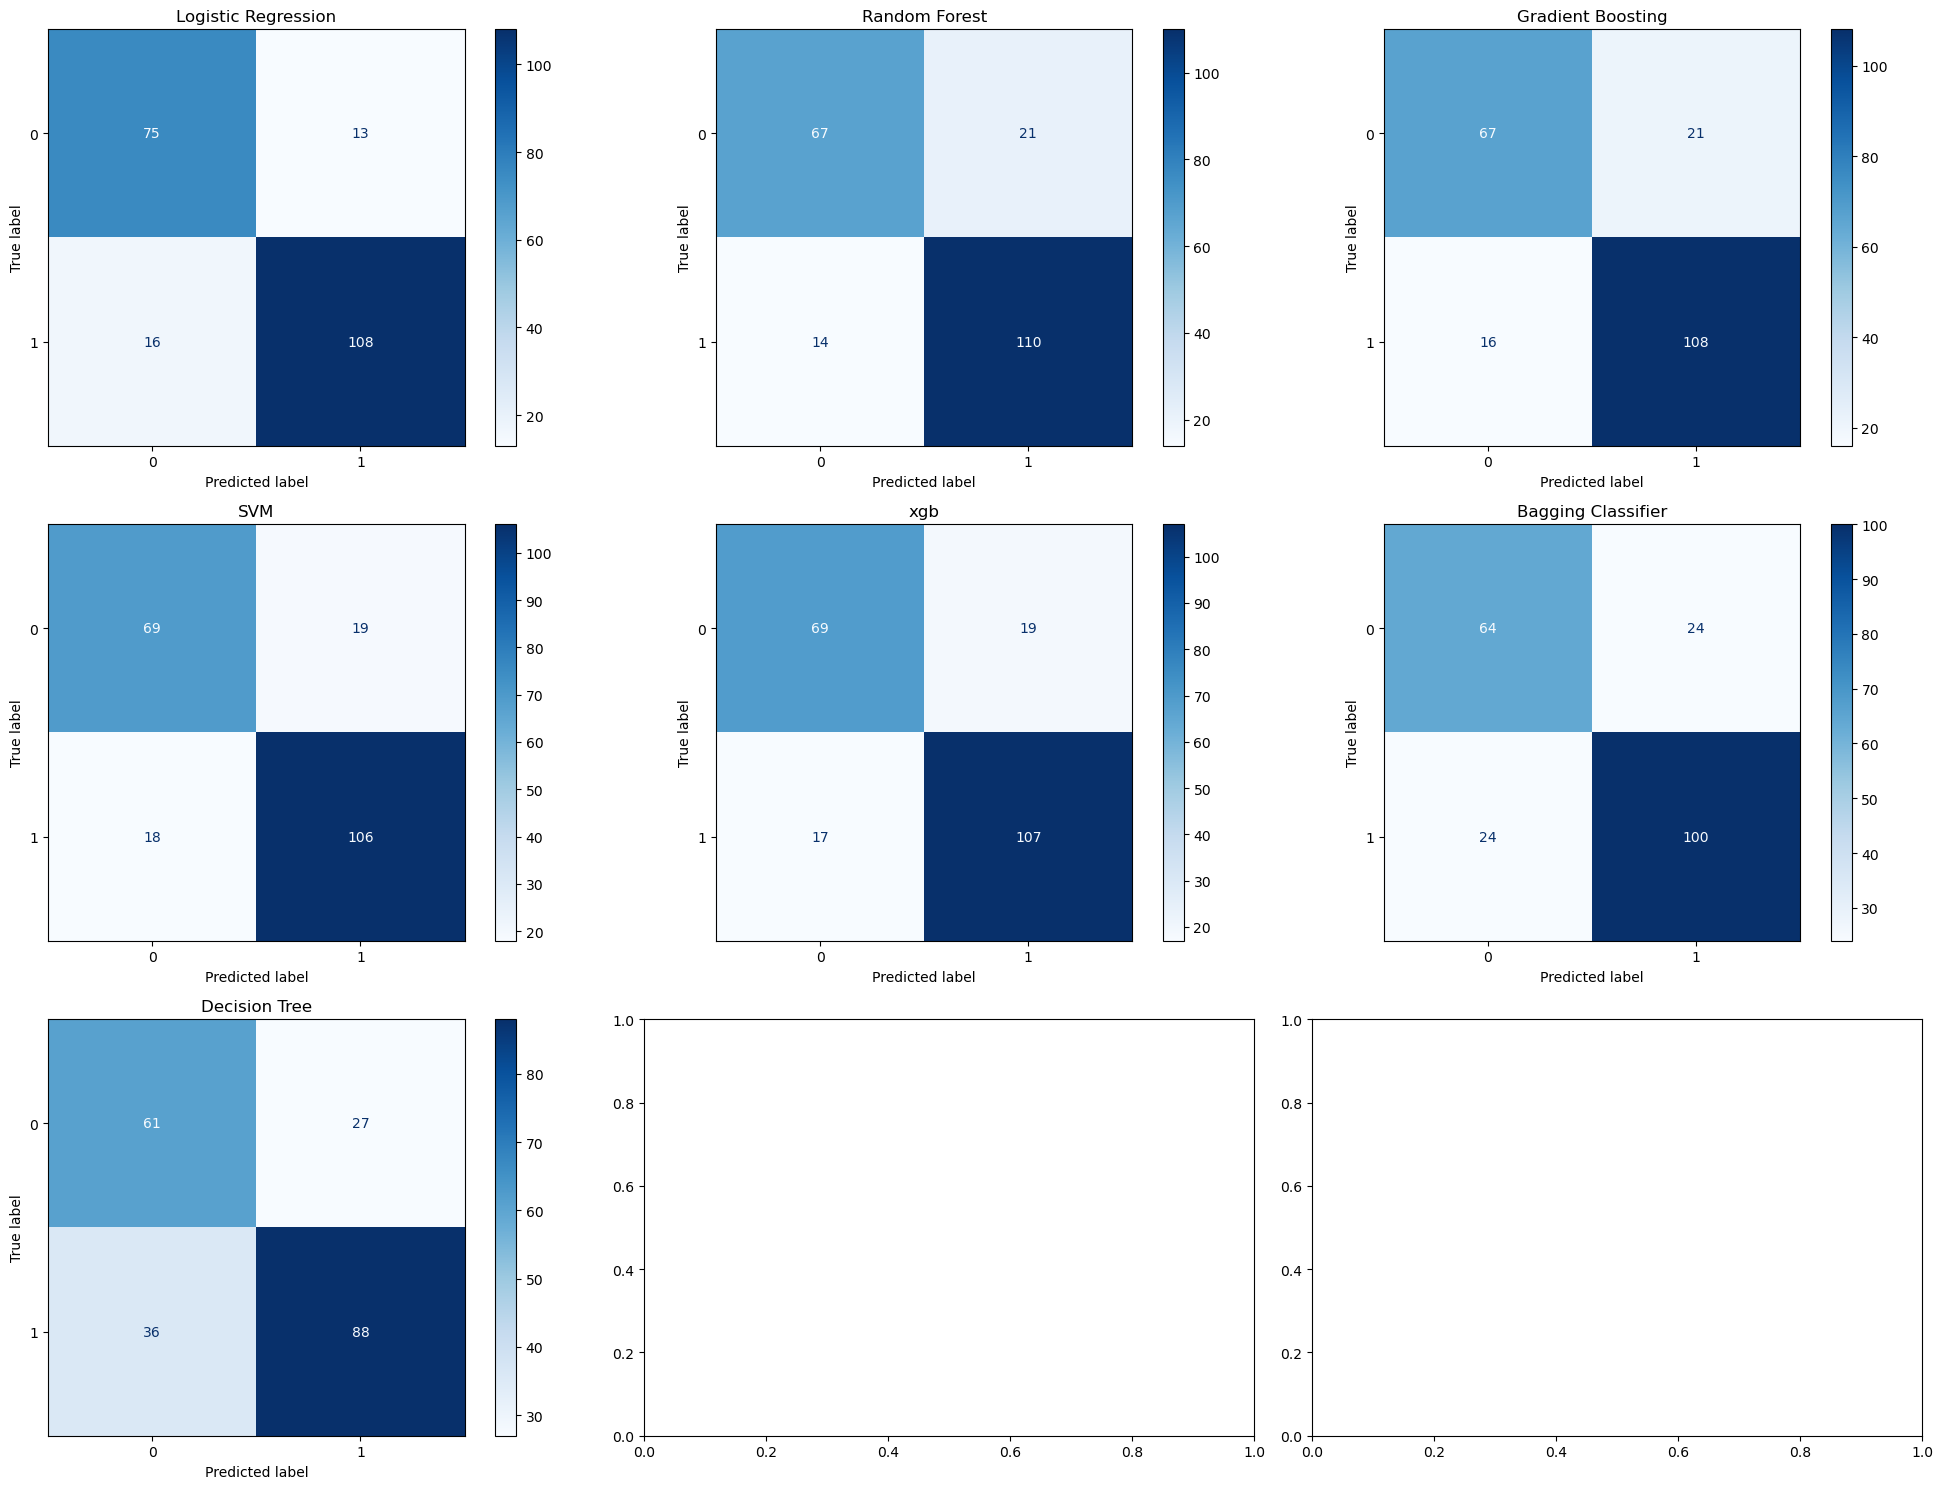

In [14]:
# Initialize all models
models = {
    'Logistic Regression': LogisticRegression(max_iter=50000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'xgb': XGBClassifier( use_label_encoder=False, eval_metric='mlogloss', random_state=42, objective='binary:logistic'),
    'Bagging Classifier': BaggingClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Dictionary to hold the results and confusion matrices
results = {}
conf_matrices = {}

# Train, evaluate each model, and store confusion matrices
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the testing set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
    }
    
    # Store confusion matrix
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results).T

# Display results
print(results_df)

# Visualization of Confusion Matrices
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
for ax, (name, matrix) in zip(axes.flatten(), conf_matrices.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    ax.title.set_text(name)
plt.tight_layout()
plt.show()


# PArameters for SVM

In [ ]:
# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.01, 0.1, 1, 5, 10, 100, 1000], 
    'kernel': ['linear'], 
    'gamma': [0.001, 0.01, 0.1, 1, 'scale'], 
}

# Initialize GridSearchCV with the SVC estimator and the defined parameter grid
svm_grid = GridSearchCV(estimator=SVC(random_state=42), 
                        param_grid=param_grid_svm, 
                        cv=10, 
                        verbose=2, 
                        n_jobs=-1) 

# Fit the grid search to the SMOTE-balanced training data
svm_grid.fit(X_train_smote, y_train_smote)

# Extract best parameters and best score
best_params_svm = svm_grid.best_params_
best_score_svm = svm_grid.best_score_

# Output the best parameters and best score for SVM
print("Best parameters found: ", best_params_svm)
print("Best score found: ", best_score_svm)


Fitting 10 folds for each of 35 candidates, totalling 350 fits
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   1.1s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   1.1s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   1.1s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   1.3s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   1.4s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   1.4s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   1.6s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   1.7s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.9s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   1.5s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   1.4s
[CV] END ..................C=0.01, gamma=0.01,

# Optimized SVM

Accuracy: 0.8160377358490566
Precision: 0.8171982391536422
Recall: 0.8160377358490566
F1 Score: 0.8164530194917643


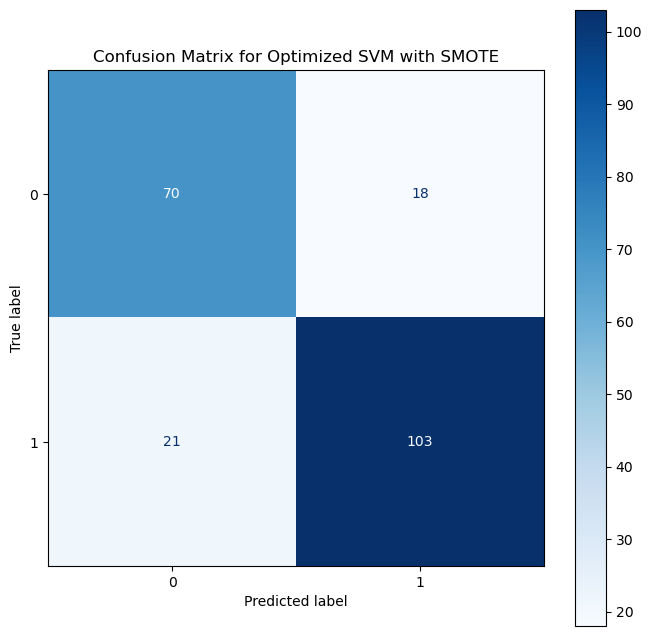

In [ ]:
# Initialize the optimized SVM with the best parameters found by GridSearchCV
optimized_svm = SVC(
    C=0.1,  
    kernel='linear',  
    random_state=42
)

# Fit the SVM model on the SMOTE-enhanced training data
optimized_svm.fit(X_train_smote, y_train_smote)

# Make predictions on the original (unbalanced) test set
y_pred_svm = optimized_svm.predict(X_test)

# Calculate evaluation metrics
optimized_accuracy_svm = accuracy_score(y_test, y_pred_svm)
optimized_precision_svm = precision_score(y_test, y_pred_svm, average='weighted', zero_division=0)
optimized_recall_svm = recall_score(y_test, y_pred_svm, average='weighted', zero_division=0)
optimized_f1_svm = f1_score(y_test, y_pred_svm, average='weighted', zero_division=0)

# Calculate and display the confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print(f"Accuracy: {optimized_accuracy_svm}")
print(f"Precision: {optimized_precision_svm}")
print(f"Recall: {optimized_recall_svm}")
print(f"F1 Score: {optimized_f1_svm}")

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the size as necessary
disp_svm = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm)
disp_svm.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized SVM with SMOTE')
plt.show()

# Parametrs for Grad Boosting

In [ ]:
# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [150, 200, 250],
    'learning_rate': [0.15, 0.2, 0.25],
    'max_depth': [4, 5, 6],
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [2, 3, 4],
    'subsample': [0.8]
}

# Initialize the GridSearchCV object with F1 scoring
gb_grid = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), 
                       param_grid=param_grid_gb, 
                       cv=10, 
                       verbose=2, 
                       n_jobs=-1,
                       scoring=make_scorer(f1_score, average='weighted'))

# Fit the grid search to the data
gb_grid.fit(X_train_smote, y_train_smote)

# Extract best parameters and best score
best_params_gb = gb_grid.best_params_
best_score_gb = gb_grid.best_score_

# Output the best parameters and best F1 score
(best_params_gb, best_score_gb)


# Optimized Grad Boost

Accuracy: 0.8207547169811321
Precision: 0.8207547169811321
Recall: 0.8207547169811321
F1 Score: 0.8207547169811321


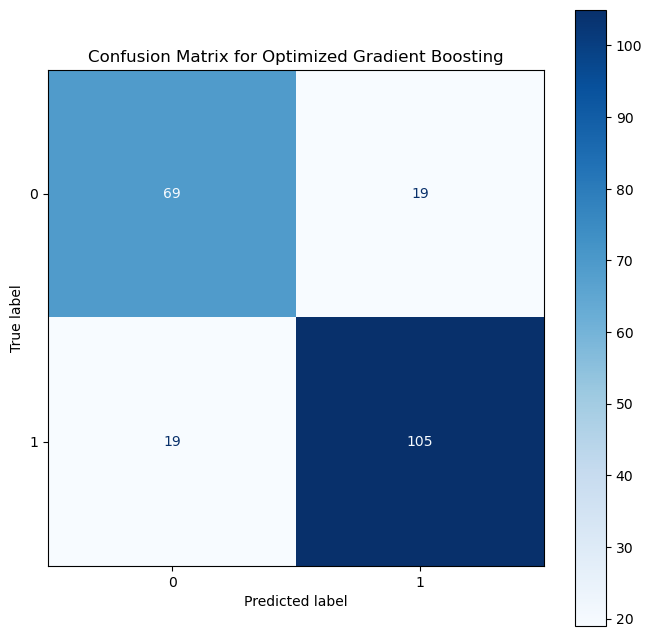

In [ ]:
# Correctly initialized Gradient Boosting model with the best parameters
optimized_gb = GradientBoostingClassifier(
    learning_rate=0.15,
    max_depth=5,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=500,
    subsample=0.7,
    random_state=42
)

# Fit the model to the training data
optimized_gb.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
y_pred_gb = optimized_gb.predict(X_test)

# Calculate metrics
optimized_accuracy_gb = accuracy_score(y_test, y_pred_gb)
optimized_precision_gb = precision_score(y_test, y_pred_gb, average='weighted')
optimized_recall_gb = recall_score(y_test, y_pred_gb, average='weighted')
optimized_f1_gb = f1_score(y_test, y_pred_gb, average='weighted')

# Calculate and display the confusion matrix
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

print(f"Accuracy: {optimized_accuracy_gb}")
print(f"Precision: {optimized_precision_gb}")
print(f"Recall: {optimized_recall_gb}")
print(f"F1 Score: {optimized_f1_gb}")

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp_gb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_gb)
disp_gb.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized Gradient Boosting')
plt.show()


# Parameters for RF

In [ ]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 6, 8, 10],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False]  
}

# Initialize the GridSearchCV object for Random Forest
rf_grid = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                       param_grid=param_grid_rf,
                       cv=10,
                       verbose=2,
                       n_jobs=-1,
                       scoring=make_scorer(f1_score, average='weighted'))

# Fit the grid search to the data
rf_grid.fit(X_train_smote, y_train_smote)

# Extract best parameters and best score for Random Forest
best_params_rf = rf_grid.best_params_
best_score_rf = rf_grid.best_score_
print("Best parameters for Random Forest:", best_params_rf)
print("Best weighted F1 score for Random Forest:", best_score_rf)


Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; to

# Optimized RF

Accuracy: 0.8490566037735849
Precision: 0.8491137793024585
Recall: 0.8490566037735849
F1 Score: 0.8478212039532794


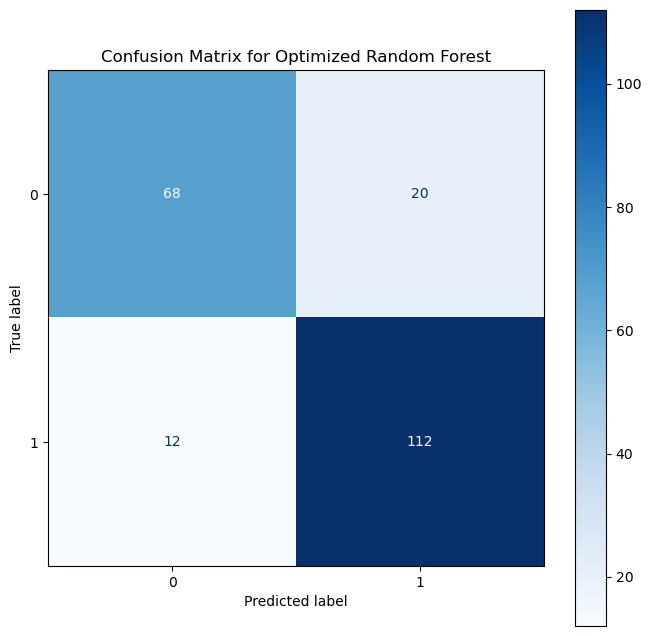

In [ ]:
# Random Forest model with the best parameters
optimized_rf = RandomForestClassifier(
    n_estimators=300,  
    random_state=42
)


# Fit the model to the training data
optimized_rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = optimized_rf.predict(X_test)

# Calculate metrics
optimized_accuracy_rf = accuracy_score(y_test, y_pred_rf)
optimized_precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
optimized_recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
optimized_f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print(f"Accuracy: {optimized_accuracy_rf}")
print(f"Precision: {optimized_precision_rf}")
print(f"Recall: {optimized_recall_rf}")
print(f"F1 Score: {optimized_f1_rf}")

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf)
disp_rf.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized Random Forest')
plt.show()

In [ ]:
# Number of bootstrap samples to create
n_bootstraps = 1000
# List to store the bootstrapped accuracies
bootstrap_accuracies = []

for _ in range(n_bootstraps):
    # Sample with replacement from X_test and y_test
    X_test_resampled, y_test_resampled = resample(X_test, y_test)
    # Make predictions with the optimized model
    y_pred_resampled = optimized_rf.predict(X_test_resampled)
    # Calculate accuracy for this bootstrap sample
    accuracy = accuracy_score(y_test_resampled, y_pred_resampled)
    bootstrap_accuracies.append(accuracy)

# Calculate the 2.5th and 97.5th percentiles to get the 95% confidence interval
confidence_lower = np.percentile(bootstrap_accuracies, 2.5)
confidence_upper = np.percentile(bootstrap_accuracies, 97.5)

confidence_lower, confidence_upper


(0.7971698113207547, 0.8962264150943396)

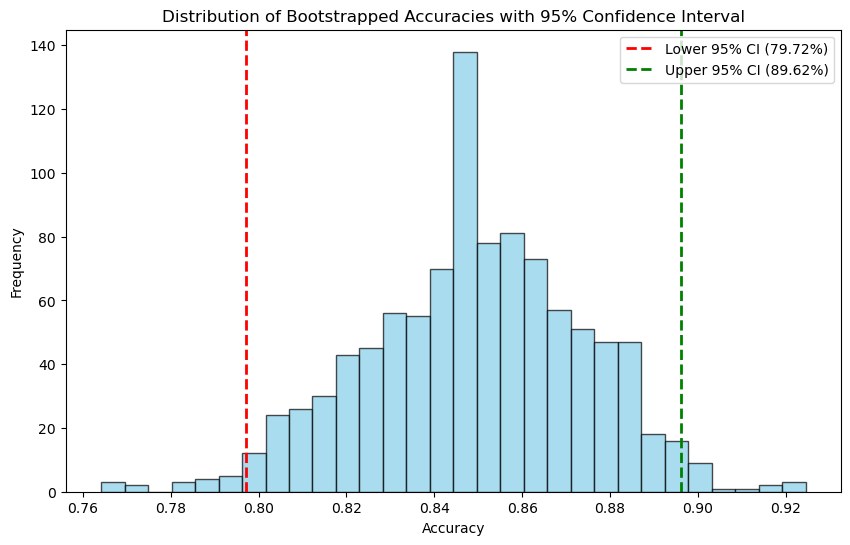

In [ ]:
# Plotting the distribution of bootstrapped accuracies
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_accuracies, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(confidence_lower, color='red', linestyle='dashed', linewidth=2, label=f'Lower 95% CI ({confidence_lower:.2%})')
plt.axvline(confidence_upper, color='green', linestyle='dashed', linewidth=2, label=f'Upper 95% CI ({confidence_upper:.2%})')

plt.title('Distribution of Bootstrapped Accuracies with 95% Confidence Interval')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Accuracy: 0.8490566037735849
Precision for each class: [0.85       0.84848485]
Recall for each class: [0.77272727 0.90322581]
F1 Score for each class: [0.80952381 0.875     ]


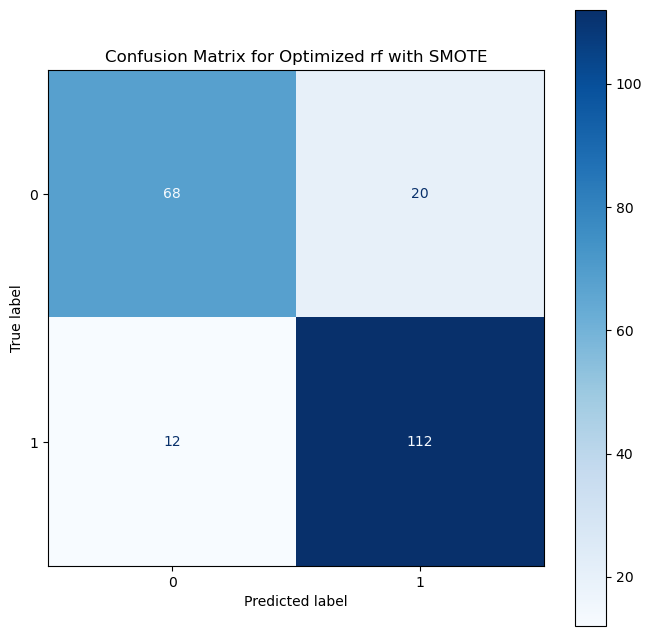

In [139]:

# Calculate evaluation metrics for each class
optimized_accuracy_rf = accuracy_score(y_test, y_pred_rf)
optimized_precision_rf = precision_score(y_test, y_pred_rf, average=None, zero_division=0)  # Scores for each class
optimized_recall_rf = recall_score(y_test, y_pred_rf, average=None, zero_division=0)  # Scores for each class
optimized_f1_rf = f1_score(y_test, y_pred_rf, average=None, zero_division=0)  # Scores for each class

# Print the metrics for each class
print(f"Accuracy: {optimized_accuracy_rf}")
print("Precision for each class:", optimized_precision_rf)
print("Recall for each class:", optimized_recall_rf)
print("F1 Score for each class:", optimized_f1_rf)

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the size as necessary
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf)
disp_rf.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized rf with SMOTE')
plt.show()


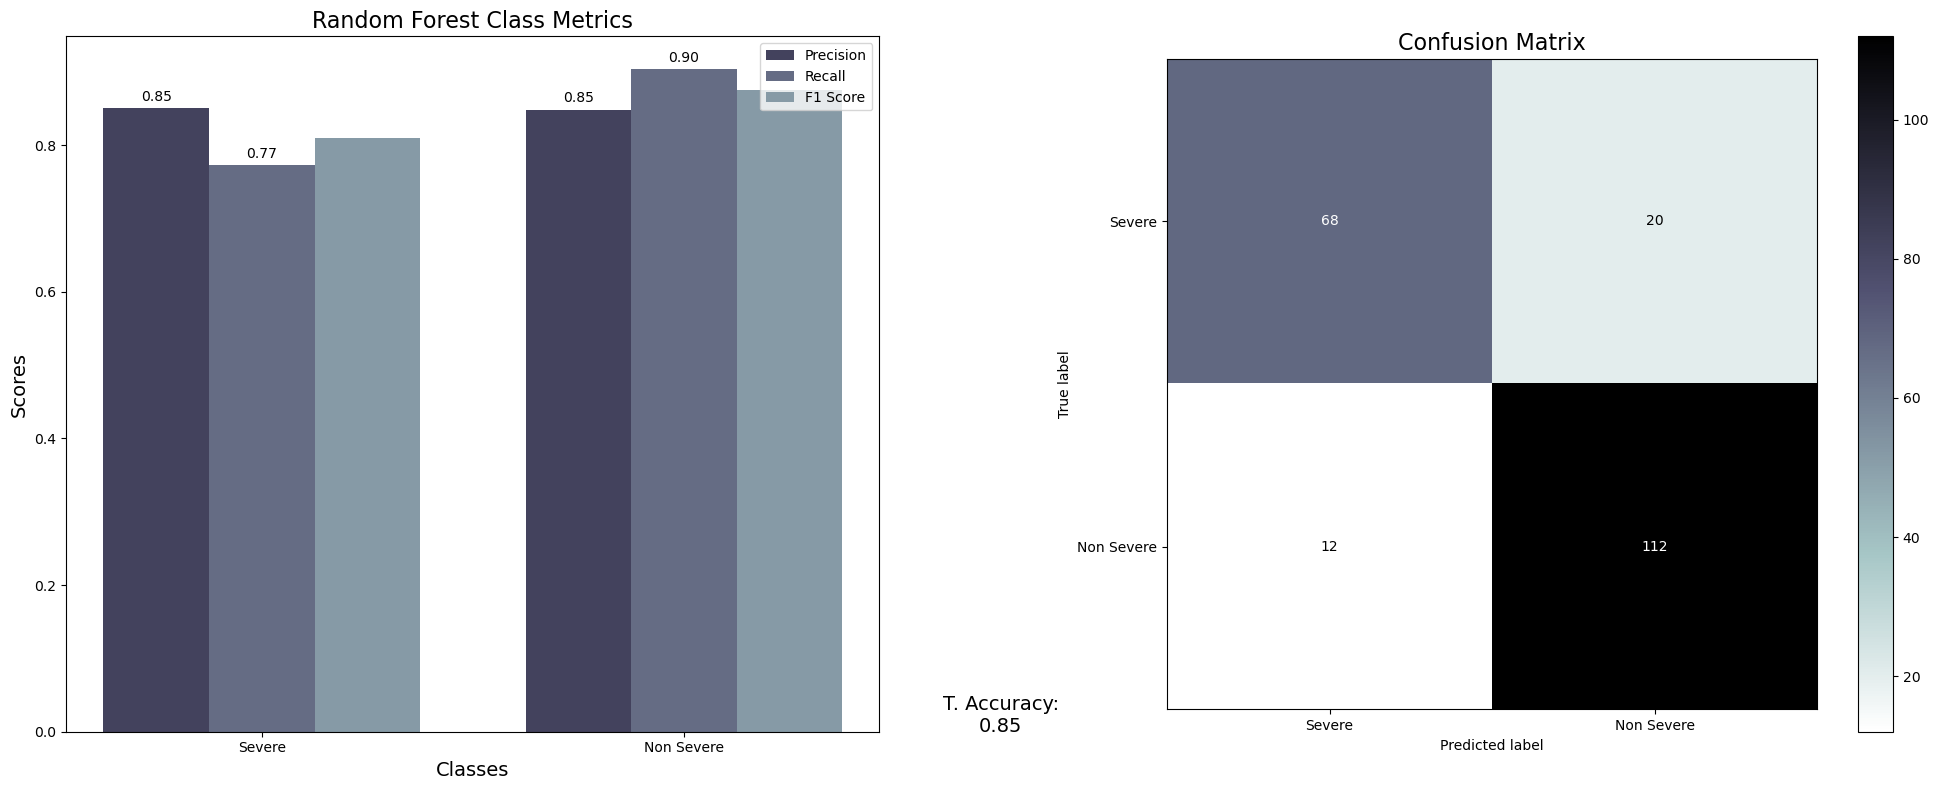

In [ ]:
# Setting up the subplot layout
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
class_labels = ['Severe', 'Non Severe']
# Metrics visualization (on the left)
bone_palette = plt.cm.bone(np.linspace(0.3, 0.6, 3)) 

# Plotting precision, recall, and F1-score for each class using rf metrics
bar_width = 0.25
index = np.arange(len(class_labels))
axes[0].bar(index, optimized_precision_rf, bar_width, color=bone_palette[0], label='Precision')
axes[0].bar(index + bar_width, optimized_recall_rf, bar_width, color=bone_palette[1], label='Recall')
axes[0].bar(index + 2 * bar_width, optimized_f1_rf, bar_width, color=bone_palette[2], label='F1 Score')

# Adding details to the rf metrics plot
axes[0].set_xlabel('Classes', fontsize=14)
axes[0].set_ylabel('Scores', fontsize=14)
axes[0].set_title('Random Forest Class Metrics', fontsize=16)
axes[0].set_xticks(index + bar_width)
axes[0].set_xticklabels(class_labels)
axes[0].legend()

# Annotate the bars with the actual values and add overall accuracy for rf
for i in index:
    axes[0].text(i, optimized_precision_rf[i] + 0.01, f'{optimized_precision_rf[i]:.2f}', ha='center')
    axes[0].text(i + bar_width, optimized_recall_rf[i] + 0.01, f'{optimized_recall_rf[i]:.2f}', ha='center')

# Adding the overall accuracy for rf
axes[0].text(len(class_labels), 0, f'T. Accuracy:\n{optimized_accuracy_rf:.2f}', fontsize=14, ha='center')

# Confusion matrix visualization (on the right) for rf
conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix_rf, display_labels=class_labels)
conf_matrix_disp.plot(cmap=plt.cm.bone_r, ax=axes[1], colorbar=True)
axes[1].set_title('Confusion Matrix', fontsize=16)

plt.tight_layout()
plt.show()


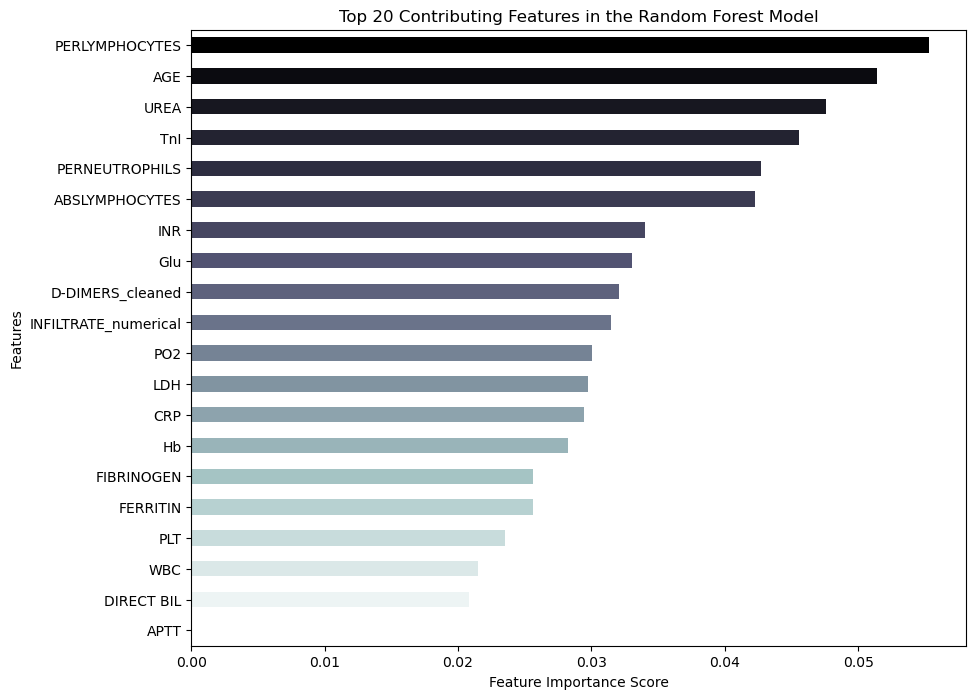

In [ ]:
# Access feature importance from the model
feature_importances = optimized_rf.feature_importances_

# Create a pandas series to hold the feature importances and their corresponding feature names
importances = pd.Series(feature_importances, index=X.columns)

# Sort the feature importances in descending order
sorted_importances = importances.sort_values(ascending=False)

# Select the top 20 features
top20_importances = sorted_importances[:20]

# Plotting
plt.figure(figsize=(10, 8))
bone_colors = plt.cm.bone(np.linspace(0, 1, 20))
top20_importances.plot(kind='barh', color=bone_colors)
plt.title('Top 20 Contributing Features in the Random Forest Model')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis() 
plt.show()


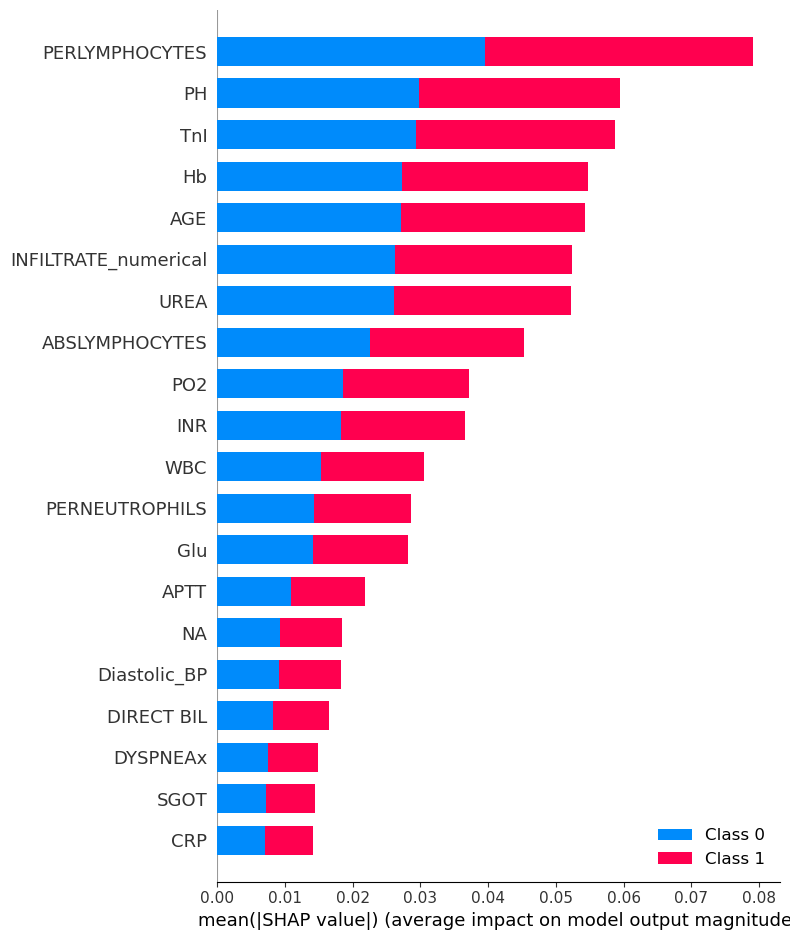

In [ ]:
import shap 

# Initialize a tree explainer with the optimized random forest model
explainer = shap.TreeExplainer(optimized_rf)

# Compute SHAP values for the test data
shap_values = explainer.shap_values(X_test_scaled)

# Summarize the SHAP values in a plot
# This shows the importance of each feature across all the test data
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


# Parameters for XGBoost

In [ ]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the GridSearchCV object for XGBoost
xgb_grid = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
                        param_grid=param_grid_xgb,
                        cv=10,
                        verbose=2,
                        n_jobs=-1,
                        scoring=make_scorer(f1_score, average='weighted'))

# Fit the grid search to the data
xgb_grid.fit(X_train_smote, y_train_smote)

# Extract best parameters and best score for XGBoost
best_params_xgb = xgb_grid.best_params_
best_score_xgb = xgb_grid.best_score_
print("Best parameters for XGBoost:", best_params_xgb)
print("Best weighted F1 score for XGBoost:", best_score_xgb)


# Optimized XGBoost

Accuracy: 0.8301886792452831
Precision: 0.8301886792452831
Recall: 0.8301886792452831
F1 Score: 0.8301886792452831


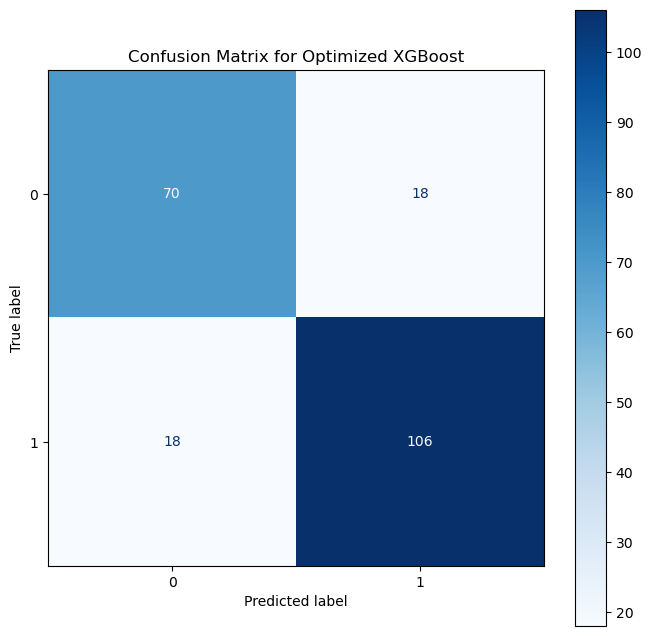

In [ ]:
optimized_xgb = XGBClassifier(
    learning_rate=0.1,    
    n_estimators=200,     
    max_depth=3,          
    min_child_weight=1,   
    subsample=0.8,        
    colsample_bytree=0.6, 
    use_label_encoder=False,  
)

# Fit the model to the training data
optimized_xgb.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
y_pred_xgb = optimized_xgb.predict(X_test)

# Calculate metrics
optimized_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
optimized_precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
optimized_recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
optimized_f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

# Calculate and display the confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print(f"Accuracy: {optimized_accuracy_xgb}")
print(f"Precision: {optimized_precision_xgb}")
print(f"Recall: {optimized_recall_xgb}")
print(f"F1 Score: {optimized_f1_xgb}")

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb)
disp_xgb.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized XGBoost')
plt.show()


Accuracy: 0.7735849056603774
Precision: 0.7814690026954179
Recall: 0.7735849056603774
F1 Score: 0.7750546033517273


X does not have valid feature names, but LogisticRegression was fitted with feature names


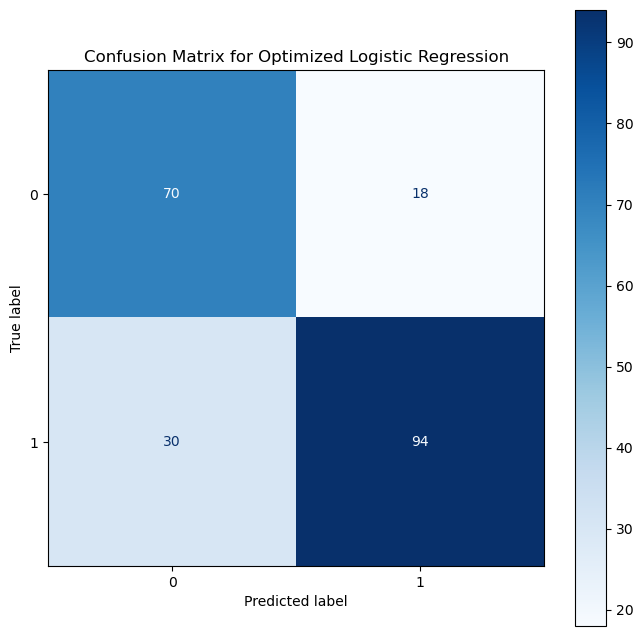

In [ ]:
# Best parameters for Logistic Regression 
best_params_lr = {
    'C': 0.1,  
    'penalty': 'l2',  
    'solver': 'liblinear' 
}

# initialized Logistic Regression model with the best parameters
optimized_lr = LogisticRegression(
    C=best_params_lr['C'],
    penalty=best_params_lr['penalty'],
    solver=best_params_lr['solver'],
    max_iter=50000,  
    random_state=42
)

# Fit the model to the SMOTE-enhanced training data
optimized_lr.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
y_pred_lr = optimized_lr.predict(X_test_scaled) 

# Calculate metrics
optimized_accuracy_lr = accuracy_score(y_test, y_pred_lr)
optimized_precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
optimized_recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
optimized_f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

# Calculate and display the confusion matrix
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

print(f"Accuracy: {optimized_accuracy_lr}")
print(f"Precision: {optimized_precision_lr}")
print(f"Recall: {optimized_recall_lr}")
print(f"F1 Score: {optimized_f1_lr}")

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp_lr = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_lr)
disp_lr.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized Logistic Regression')
plt.show()


In [ ]:
# Calculate metrics for each model
metrics = {}
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'XGBoost']  
predictions = [y_pred_lr, y_pred_rf, y_pred_gb,  y_pred_svm, y_pred_xgb]

for model, y_pred in zip(models, predictions):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    metrics[model] = [accuracy, precision, recall, f1]


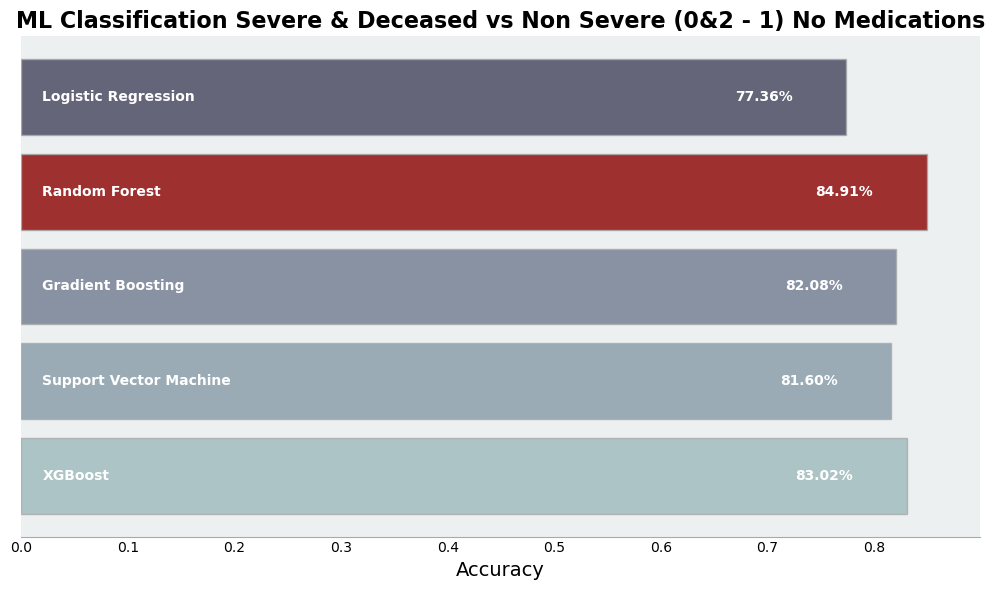

In [69]:
# Assuming 'models' and 'accuracies' are defined
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'XGBoost']  
accuracies = [metrics[model][0] for model in models] 

# Set up the figure for a horizontal bar chart
plt.figure(figsize=(10, 6))
ax = plt.subplot()

# Define a professional, muted color palette using 'bone'
colors = plt.cm.bone(np.linspace(0.3, 0.7, len(models)))

# Plot horizontal bars
y_positions = np.arange(len(models))
bars = ax.barh(y_positions, accuracies, color=colors, edgecolor='darkgrey', linewidth=1, alpha=0.8)

# Highlight the best performer by adjusting its properties
best_idx = np.argmax(accuracies)
bars[best_idx].set_color('#8B0000') 
bars[best_idx].set_edgecolor('darkgrey')

# Add text annotations for accuracy percentages inside the bars
for bar, accuracy in zip(bars, accuracies):
    ax.text(bar.get_width() - 0.05, bar.get_y() + bar.get_height() / 2, f'{accuracy:.2%}', 
            ha='right', va='center', color='white', fontweight='bold', fontsize=10)

# Add text annotations for the full names of each algorithm inside the bars
for bar, model_name in zip(bars, models):
    ax.text(0.02, bar.get_y() + bar.get_height() / 2, model_name, 
            ha='left', va='center', color='white', fontweight='bold', fontsize=10)

# Aesthetic improvements
ax.set_yticks([])  
ax.invert_yaxis()  
ax.set_xlabel('Accuracy', fontsize=14)
ax.set_xlim(0, max(accuracies) + 0.05)  
ax.set_title('ML Classification Severe & Deceased vs Non Severe (0&2 - 1) No Medications', fontsize=16, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  
ax.spines['bottom'].set_color('darkgrey')
ax.set_facecolor('#ecf0f1')  
ax.tick_params(axis='both', which='both', length=0)  

plt.tight_layout()
plt.show()


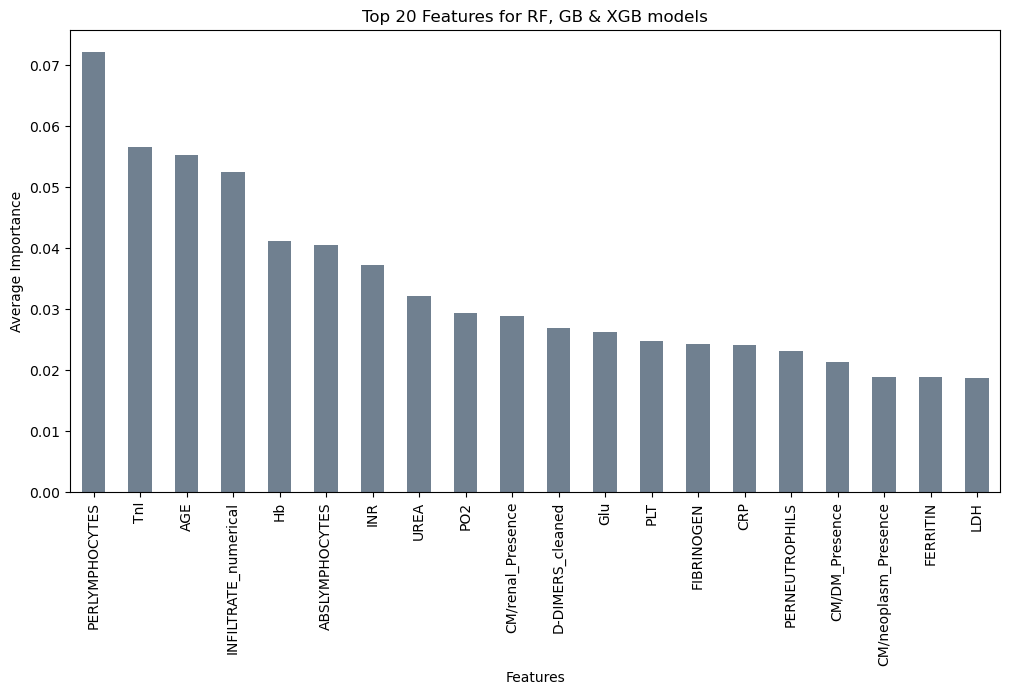

In [70]:
# Assuming X_train has feature names
feature_names = X_train.columns

# Placeholder dictionaries for feature importances from each model
feature_importances = {
    'rf': optimized_rf.feature_importances_,
    'gb': optimized_gb.feature_importances_,
    'xgb': optimized_xgb.feature_importances_
}

# Initialize a DataFrame to hold aggregated feature importances
importance_df = pd.DataFrame(index=feature_names)

# Fill the DataFrame with feature importances from each model
for model_name, importances in feature_importances.items():
    importance_df[model_name] = importances

# Calculate average importance for each feature
importance_df['average'] = importance_df.mean(axis=1)

# Sort features based on average importance
sorted_features = importance_df.sort_values(by='average', ascending=False)

# Visualize the top 20 features 
top_features = sorted_features.head(20)
top_features['average'].plot(kind='bar', figsize=(12, 6), color='slategray')
plt.title('Top 20 Features for RF, GB & XGB models')
plt.ylabel('Average Importance')
plt.xlabel('Features')
plt.show()


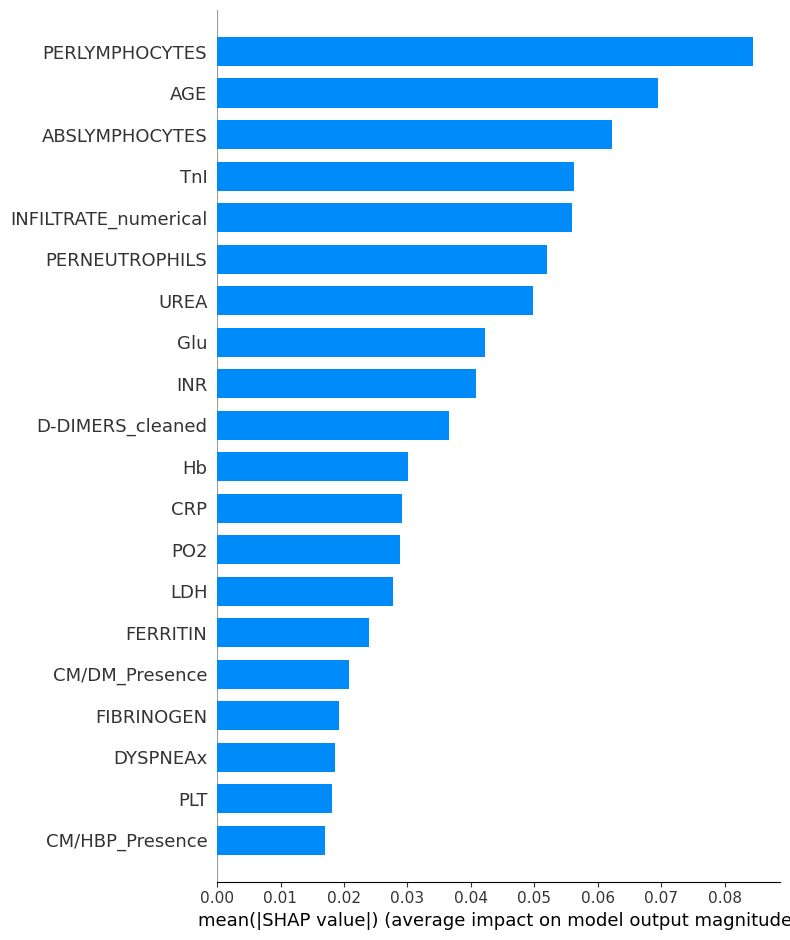

In [ ]:
shap.initjs()

# Initialize a SHAP TreeExplainer with the optimized Random Forest model
explainer_rf = shap.TreeExplainer(optimized_rf)

# Compute SHAP values for the test data for Random Forest
shap_values_rf = explainer_rf.shap_values(X_test)

# Check if SHAP values are in multi-class format 
if isinstance(shap_values_rf, list): 
    # Aggregate SHAP values across all classes for each sample
    values_aggregated_rf = np.sum(np.abs(shap_values_rf), axis=0)  
else:
    # Use directly if already in the correct format (binary classification or regression)
    values_aggregated_rf = shap_values_rf

# Ensure we have a 2D array for the summary plot
if len(values_aggregated_rf.shape) == 1:
    # This should not normally happen for Random Forest SHAP values, but we'll skip plotting if it does
    print("Error: Unexpected SHAP values shape.")
else:
    # Plotting the SHAP values with a bar chart
    shap.summary_plot(values_aggregated_rf, X_test, plot_type="bar", feature_names=X_test.columns, max_display=20)


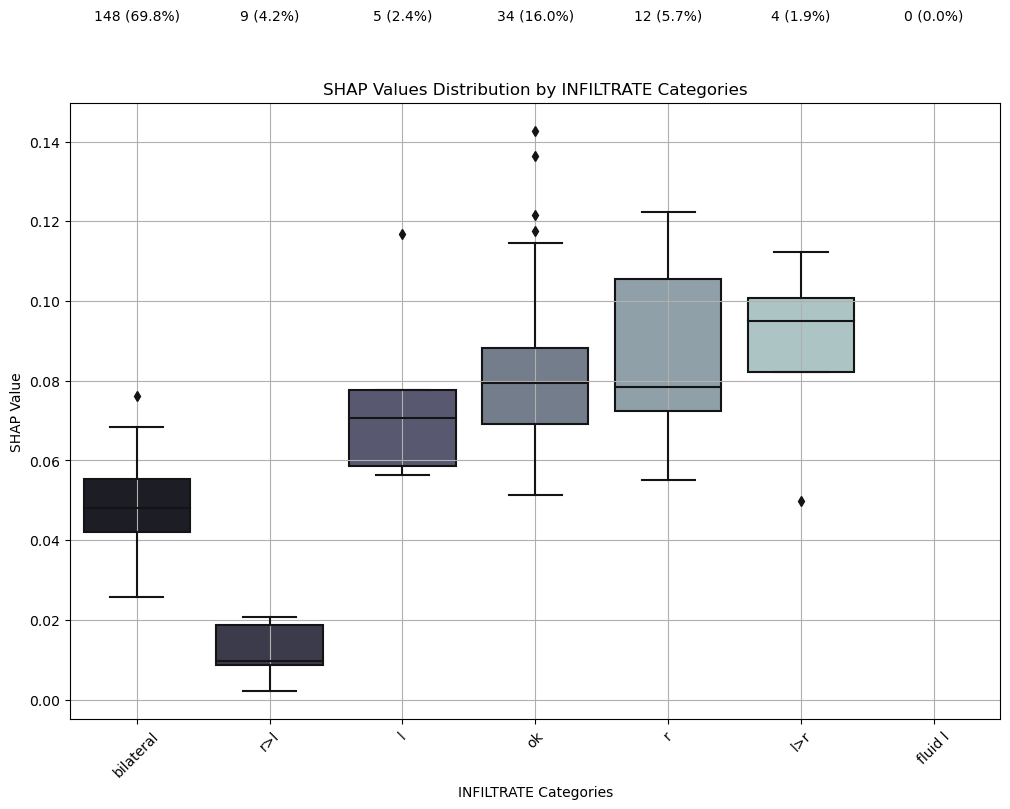

In [ ]:
category_map = {
    1: 'bilateral', 2: 'r>l', 3: 'l', 4: 'ok', 
    5: 'r', 6: 'l>r', 7: 'fluid l'
}

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'INFILTRATE_numerical': X_test['INFILTRATE_numerical'],
    'SHAP Value': values_aggregated_rf[:, X_test.columns.get_loc('INFILTRATE_numerical')]
})

# Using the category_map to create categorical labels for plotting
plot_data['INFILTRATE_category'] = plot_data['INFILTRATE_numerical'].map(lambda x: category_map.get(x, 'Unknown'))

### Step 2: Plotting the Data with 'Box Plot'

# Define the 'bone' color palette based on the number of categories
bone_palette = sns.color_palette("bone", len(category_map))

plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=plot_data, x='INFILTRATE_category', y='SHAP Value', palette=bone_palette, order=list(category_map.values()))

# Adding details to the plot
plt.title('SHAP Values Distribution by INFILTRATE Categories')
plt.xlabel('INFILTRATE Categories')
plt.ylabel('SHAP Value')
plt.xticks(rotation=45)  # Rotate category labels for better readability
plt.grid(True)

# Calculate and annotate count above each box
counts = plot_data['INFILTRATE_category'].value_counts()
total = len(plot_data)
for i, category in enumerate(category_map.values()):
    count = counts.get(category, 0)
    percentage = 100 * count / total
    text = f'{count} ({percentage:.1f}%)'
    ax.text(
        i,  # x-position 
        ax.get_ylim()[1] + 0.02,  # y-position 
        text,  # text to display
        horizontalalignment='center',  # center the text
        verticalalignment='bottom',  # align the bottom of the text
        fontsize=10,  # font size
        color='black'  # text color
    )

plt.show()



In [147]:
# New mapping dictionary based on broader categories
broader_category_map = {
    1: 'bilateral',  # bilateral remains the same
    2: 'one side',   # r>l
    3: 'one side',   # l
    4: 'ok',         # ok
    5: 'one side',   # r
    6: 'one side',   # l>r
    7: 'one side'    # fluid l
}

# Map the numerical values to these broader categories
plot_data['Broader_Category'] = plot_data['INFILTRATE_numerical'].map(lambda x: broader_category_map.get(x, 'Unknown'))


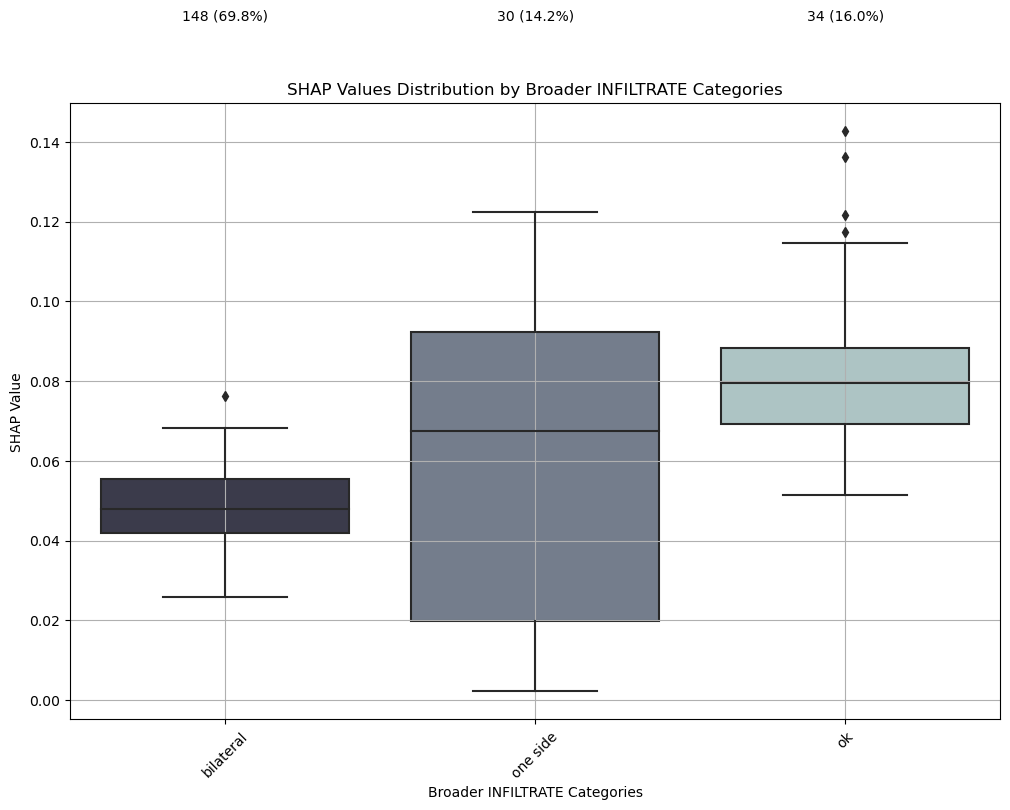

In [ ]:
bone_palette = sns.color_palette("bone", 3)

plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=plot_data, x='Broader_Category', y='SHAP Value', palette=bone_palette, order=['bilateral', 'one side', 'ok'])

# Adding details to the plot
plt.title('SHAP Values Distribution by Broader INFILTRATE Categories')
plt.xlabel('Broader INFILTRATE Categories')
plt.ylabel('SHAP Value')
plt.xticks(rotation=45)  # Rotate category labels for better readability
plt.grid(True)

# Calculate and annotate count above each box
counts = plot_data['Broader_Category'].value_counts()
total = len(plot_data)
for i, category in enumerate(['bilateral', 'one side', 'ok']):
    count = counts.get(category, 0)
    percentage = 100 * count / total
    text = f'{count} ({percentage:.1f}%)'
    ax.text(
        i,  # x-position 
        ax.get_ylim()[1] + 0.02,  # y-position 
        text,  # text to display
        horizontalalignment='center',  # center the text
        verticalalignment='bottom',  # align the bottom of the text
        fontsize=10,  # font size
        color='black'  # text color
    )

plt.show()


In [ ]:
import scipy.stats as stats
import statsmodels.api as sm

# List of top 8 features from your model's SHAP values
top_features = ['PERLYMPHOCYTES', 'TnI', 'INFILTRATE_numerical', 'PERNEUTROPHILS', 'AGE', 'INR', 'UREA', 'ABSLYMPHOCYTES']
outcome = 'Outcome_numerical'

# Perform analysis
results = []

for feature in top_features:
    # Check if the feature is categorical based on its data type or unique values count
    if dataset[feature].dtype == 'O' or len(dataset[feature].unique()) <= 2:
        # Categorical feature analysis using Chi-square test
        contingency_table = pd.crosstab(dataset[feature], dataset[outcome])
        chi2, p, dof, _ = stats.chi2_contingency(contingency_table)
        effect_size = np.sqrt(chi2 / (contingency_table.values.sum() * (min(contingency_table.shape) - 1)))
        results.append((feature, 'Chi-square', p, effect_size))
    else:
        # Continuous feature analysis using Logistic Regression
        model = sm.Logit(dataset[outcome], sm.add_constant(dataset[feature])).fit(disp=0)
        p = model.pvalues[feature]
        coeff = model.params[feature]
        results.append((feature, 'Logistic Regression', p, coeff))

# Print the results
print("Feature Analysis Results:")
for result in results:
    feature, analysis_type, p_value, effect_measure = result
    print(f"{feature} ({analysis_type}): p-value = {p_value:.4f}, Effect Measure = {effect_measure:.4f}")


Feature Analysis Results:
PERLYMPHOCYTES (Logistic Regression): p-value = 0.0000, Effect Measure = 0.0902
TnI (Logistic Regression): p-value = 0.0000, Effect Measure = -0.0328
INFILTRATE_numerical (Logistic Regression): p-value = 0.0000, Effect Measure = 0.5317
PERNEUTROPHILS (Logistic Regression): p-value = 0.0000, Effect Measure = -0.0773
AGE (Logistic Regression): p-value = 0.0000, Effect Measure = -0.0446
INR (Logistic Regression): p-value = 0.0000, Effect Measure = -3.7858
UREA (Logistic Regression): p-value = 0.0000, Effect Measure = -0.0536
ABSLYMPHOCYTES (Logistic Regression): p-value = 0.0858, Effect Measure = 0.2719


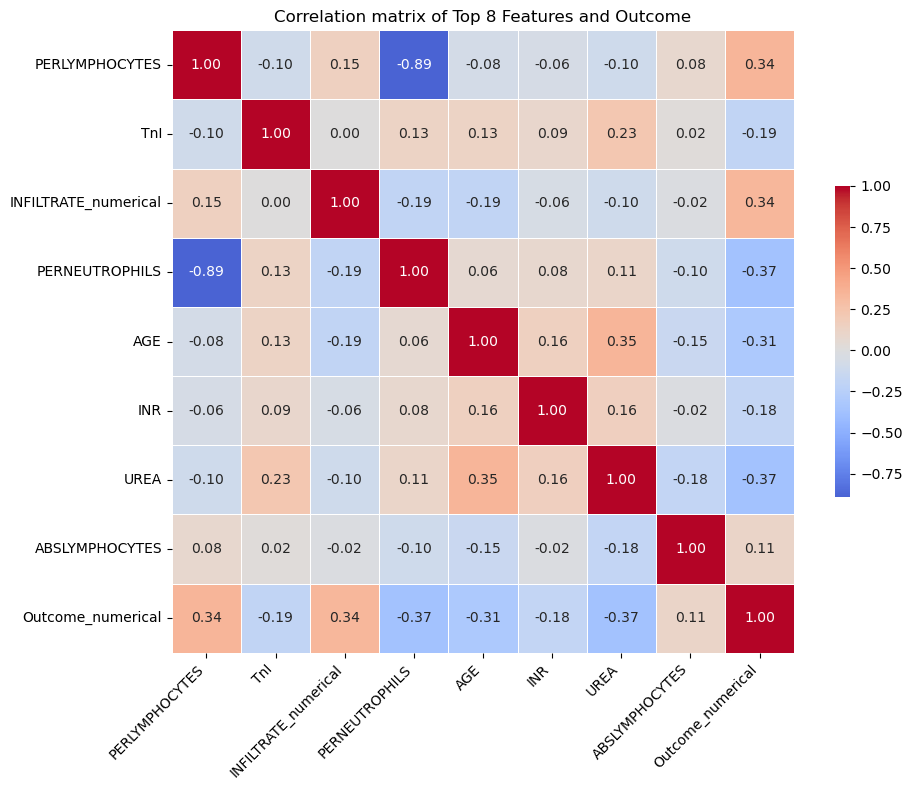

In [ ]:
top_features = ['PERLYMPHOCYTES', 'TnI', 'INFILTRATE_numerical', 'PERNEUTROPHILS', 'AGE', 'INR', 'UREA', 'ABSLYMPHOCYTES']
outcome = 'Outcome_numerical'

# Select only the relevant columns for correlation analysis
analysis_data = dataset[top_features + [outcome]]

# Compute the Pearson correlation matrix
correlation_matrix = analysis_data.corr(method='pearson')

# Set up the matplotlib figure (adjust figsize if needed)
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Customize the visualization
plt.title('Correlation matrix of Top 8 Features and Outcome')
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)
plt.tight_layout()  

# Show plot
plt.show()


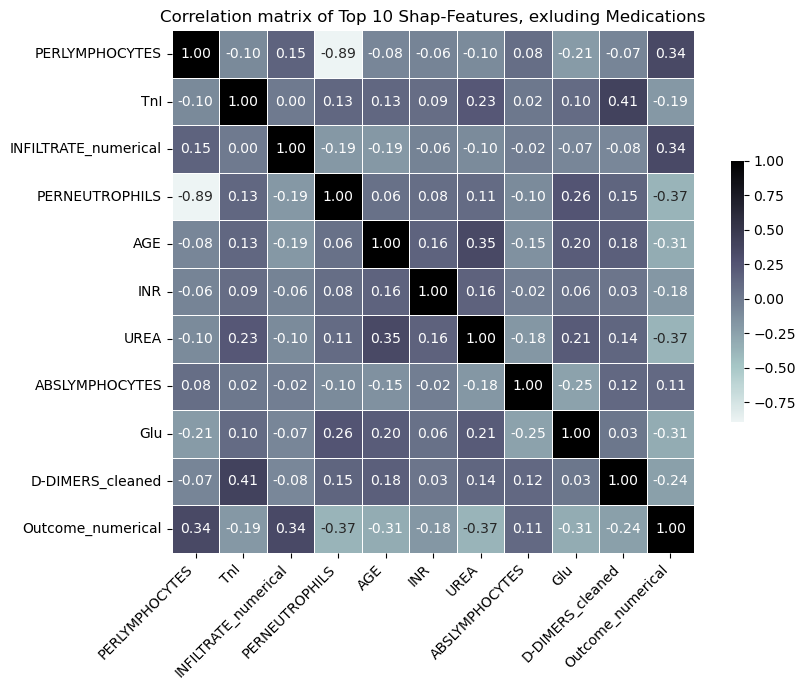

In [ ]:
top_features = ['PERLYMPHOCYTES', 'TnI', 'INFILTRATE_numerical', 'PERNEUTROPHILS', 'AGE', 'INR', 'UREA', 'ABSLYMPHOCYTES', 'Glu', 'D-DIMERS_cleaned']
outcome = 'Outcome_numerical'

# Select only the relevant columns for correlation analysis
analysis_data = dataset[top_features + [outcome]]

# Compute the Pearson correlation matrix
correlation_matrix = analysis_data.corr(method='pearson')

# Set up the matplotlib figure (adjust figsize if needed)
plt.figure(figsize=(9, 7))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='bone_r', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Customize the visualization
plt.title('Correlation matrix of Top 10 Shap-Features, exluding Medications')
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout()  

# Show plot
plt.show()


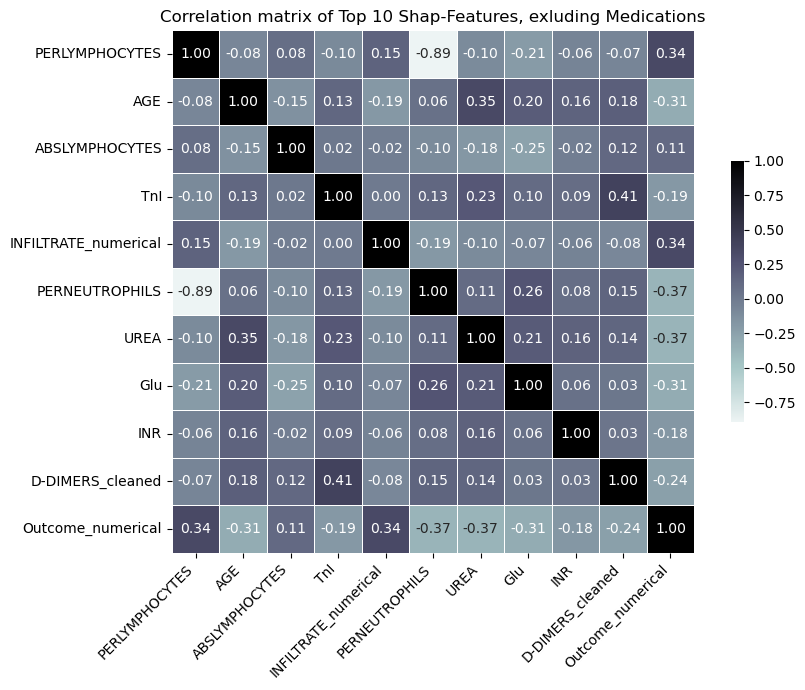

In [ ]:
top_features = [
    "PERLYMPHOCYTES",
    "AGE",
    "ABSLYMPHOCYTES",
    "TnI",
    "INFILTRATE_numerical",
    "PERNEUTROPHILS",
    "UREA",
    "Glu",
    "INR",
    "D-DIMERS_cleaned"
]

outcome = 'Outcome_numerical'

# Select only the relevant columns for correlation analysis
analysis_data = dataset[top_features + [outcome]]

# Compute the Pearson correlation matrix
correlation_matrix = analysis_data.corr(method='pearson')

# Set up the matplotlib figure (adjust figsize if needed)
plt.figure(figsize=(9, 7))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='bone_r', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Customize the visualization
plt.title('Correlation matrix of Top 10 Shap-Features, exluding Medications')
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout() 

# Show plot
plt.show()


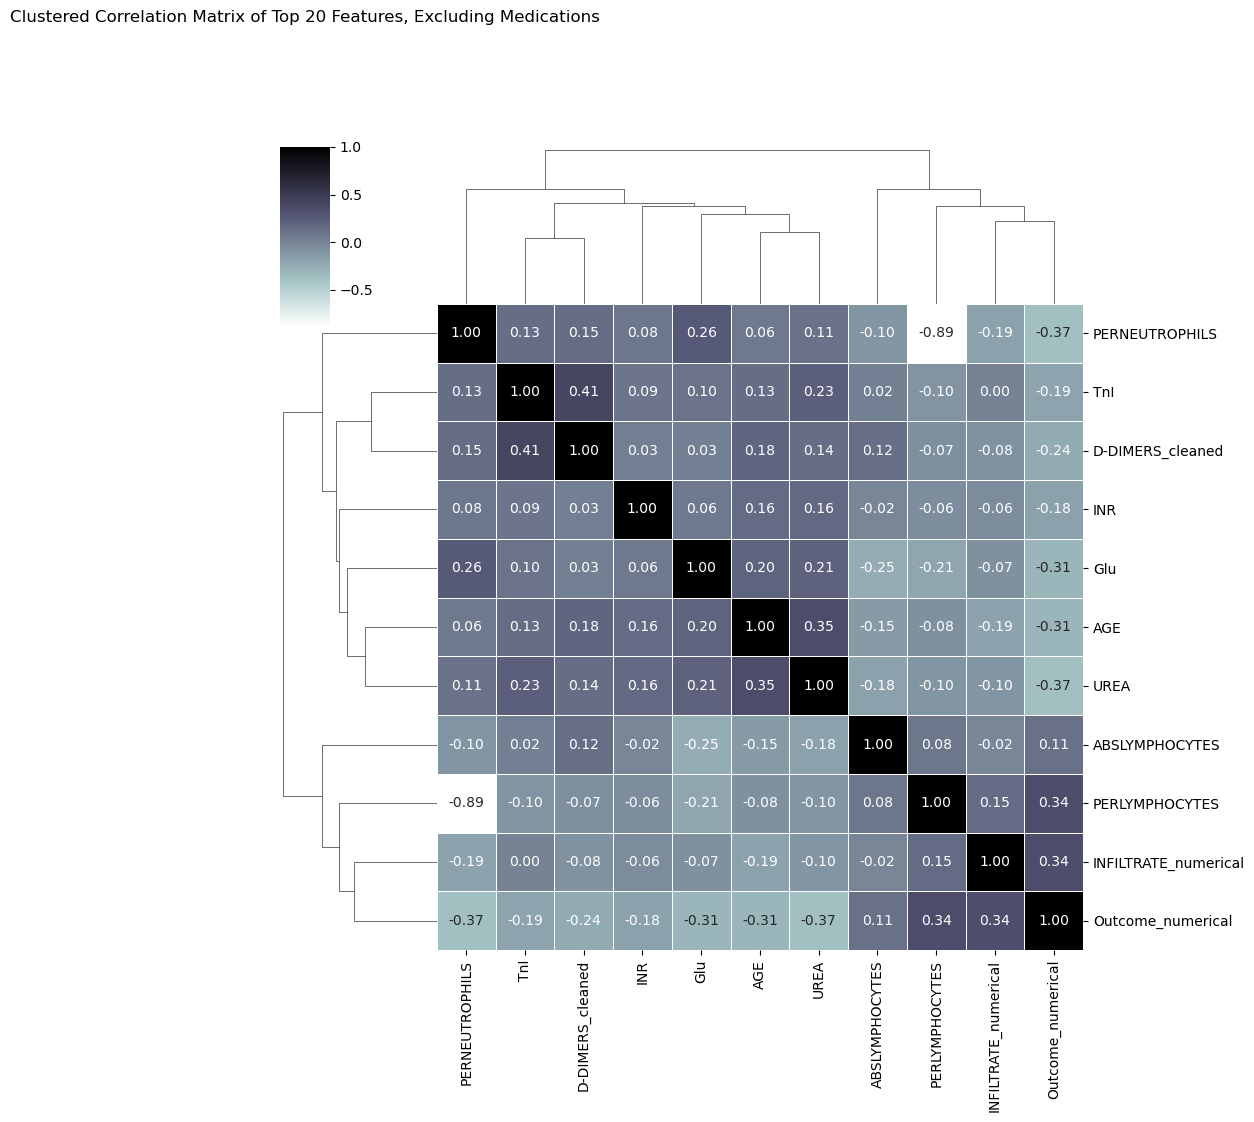

In [ ]:
top_features = [
    "PERLYMPHOCYTES",
    "AGE",
    "ABSLYMPHOCYTES",
    "TnI",
    "INFILTRATE_numerical",
    "PERNEUTROPHILS",
    "UREA",
    "Glu",
    "INR",
    "D-DIMERS_cleaned"
]
outcome = 'Outcome_numerical'

# Select only the relevant columns for correlation analysis
analysis_data = dataset[top_features + [outcome]]

# Compute the Pearson correlation matrix
correlation_matrix = analysis_data.corr(method='pearson')

# Use seaborn's clustermap to plot a clustered correlation matrix
sns.clustermap(correlation_matrix, annot=True, fmt=".2f", cmap='bone_r', figsize=(10, 10),
               linewidths=.5, cbar_kws={"shrink": .5})

# Customize the visualization
plt.title('Clustered Correlation Matrix of Top 20 Features, Excluding Medications', pad=90)
plt.xticks(rotation=45, ha='right')  # Improve readability for feature names
plt.yticks(rotation=0)

# Show plot
plt.show()


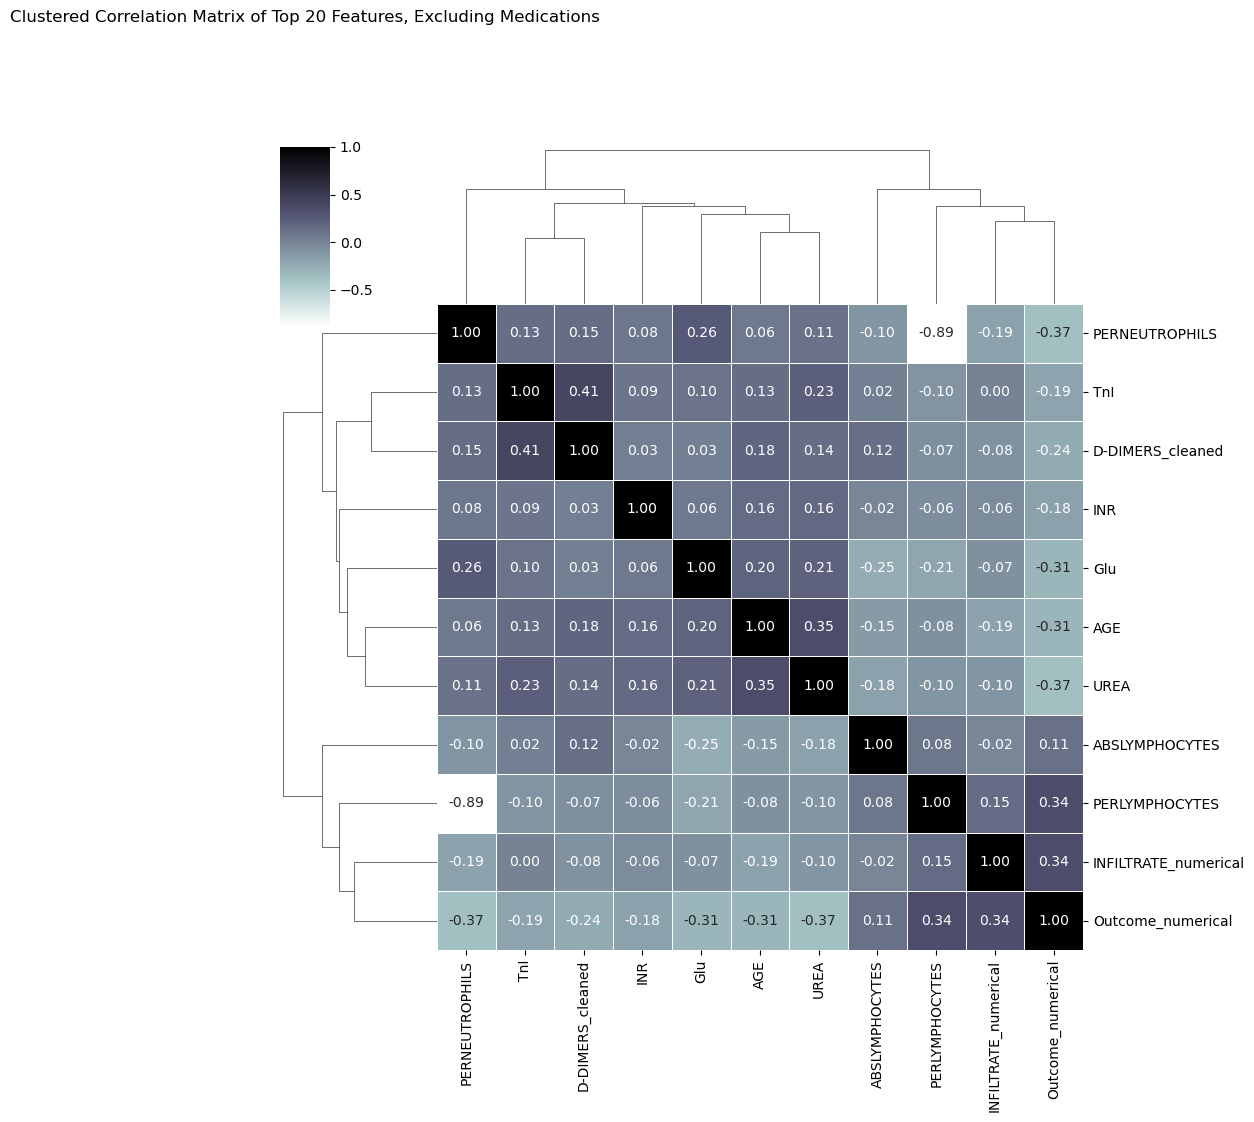

In [ ]:
top_features = ['PERLYMPHOCYTES', 'TnI', 'INFILTRATE_numerical', 'PERNEUTROPHILS', 'AGE', 'INR', 'UREA', 'ABSLYMPHOCYTES', 
                'Glu', 'D-DIMERS_cleaned',]
outcome = 'Outcome_numerical'

# Select only the relevant columns for correlation analysis
analysis_data = dataset[top_features + [outcome]]

# Compute the Pearson correlation matrix
correlation_matrix = analysis_data.corr(method='pearson')

# Use seaborn's clustermap to plot a clustered correlation matrix
sns.clustermap(correlation_matrix, annot=True, fmt=".2f", cmap='bone_r', figsize=(10, 10),
               linewidths=.5, cbar_kws={"shrink": .5})

# Customize the visualization
plt.title('Clustered Correlation Matrix of Top 20 Features, Excluding Medications', pad=90)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)

# Show plot
plt.show()


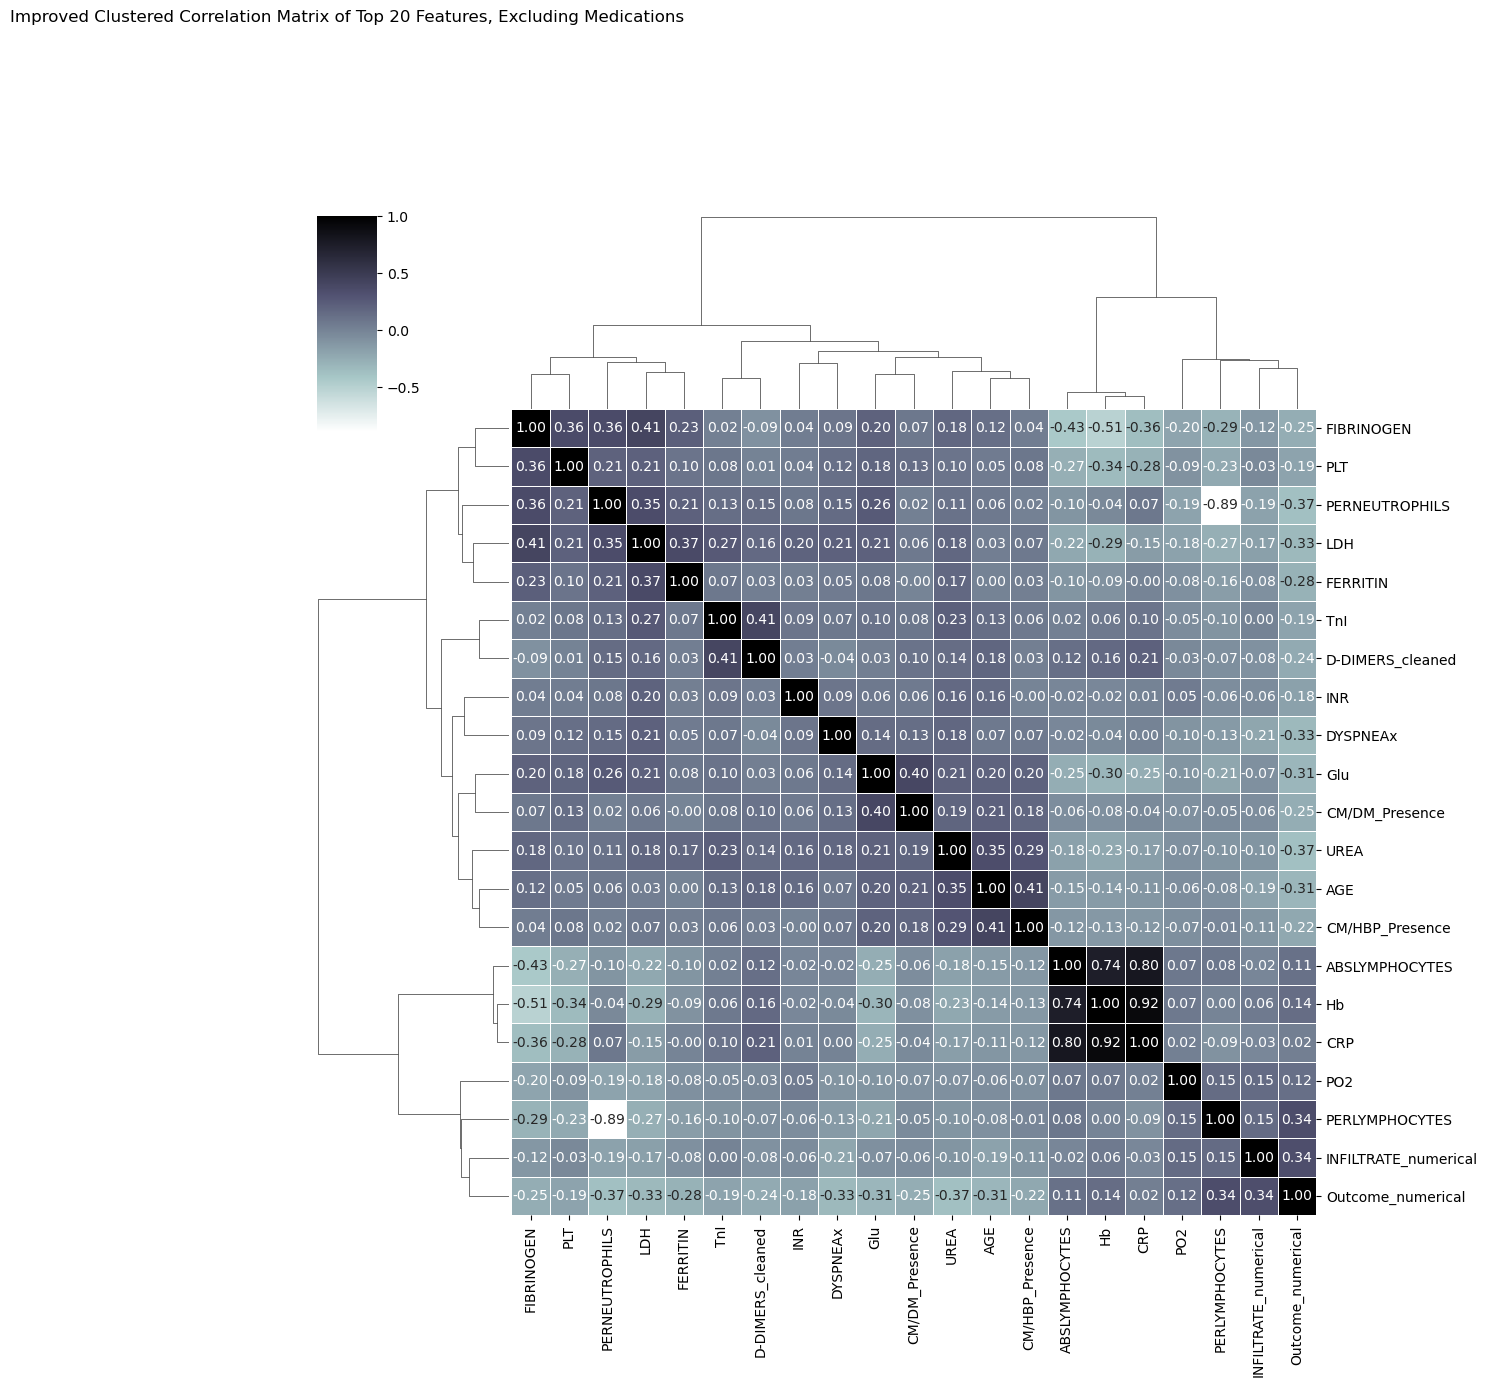

In [ ]:
top_features = [
    "PERLYMPHOCYTES",
    "AGE",
    "ABSLYMPHOCYTES",
    "TnI",
    "INFITRATE_numerical",
    "PERNEUTROPHILS",
    "UREA",
    "Glu",
    "INR",
    "D-DIMERS_cleaned",
    "Hb",
    "CRP",
    "PO2",
    "LDH",
    "FERRITIN",
    "CM/DM_Presence",
    "FIBRINOGEN",
    "DYSPNEAx",
    "PLT",
    "CM/HBP_Presence"
]

outcome = 'Outcome_numerical'

# Select only the relevant columns for correlation analysis
analysis_data = dataset[top_features + [outcome]]

# Compute the Pearson correlation matrix
correlation_matrix = analysis_data.corr(method='pearson')


# Use seaborn's clustermap to plot a clustered correlation matrix with improved clustering
g = sns.clustermap(correlation_matrix, annot=True, fmt=".2f", cmap='bone_r', figsize=(12, 12),
                   linewidths=.5, cbar_kws={"shrink": .5}, method='ward', metric='euclidean')

# Customize the visualization
plt.title('Improved Clustered Correlation Matrix of Top 20 Features, Excluding Medications', pad=140)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()


In [112]:
import shap
shap.initjs()
# Initialize SHAP explainers
explainers = {
    'Random Forest': shap.TreeExplainer(optimized_rf),
    'XGBoost': shap.TreeExplainer(optimized_xgb)
}

shap_values = {
    name: explainer.shap_values(X_test)
    for name, explainer in explainers.items()
}


Model: Random Forest


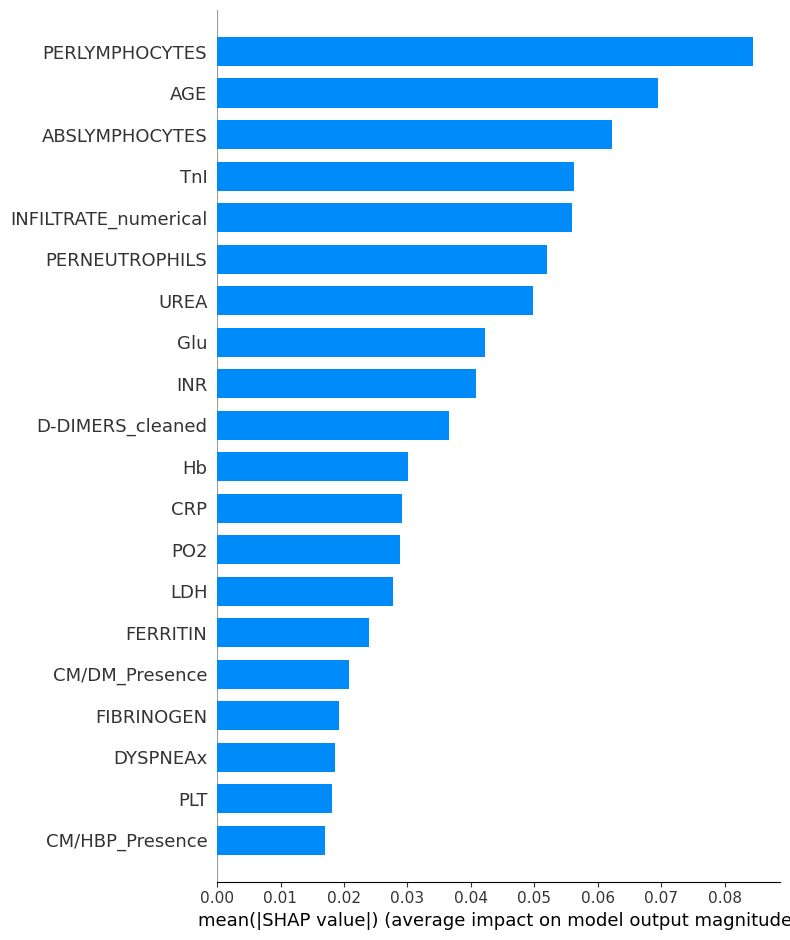

Model: XGBoost


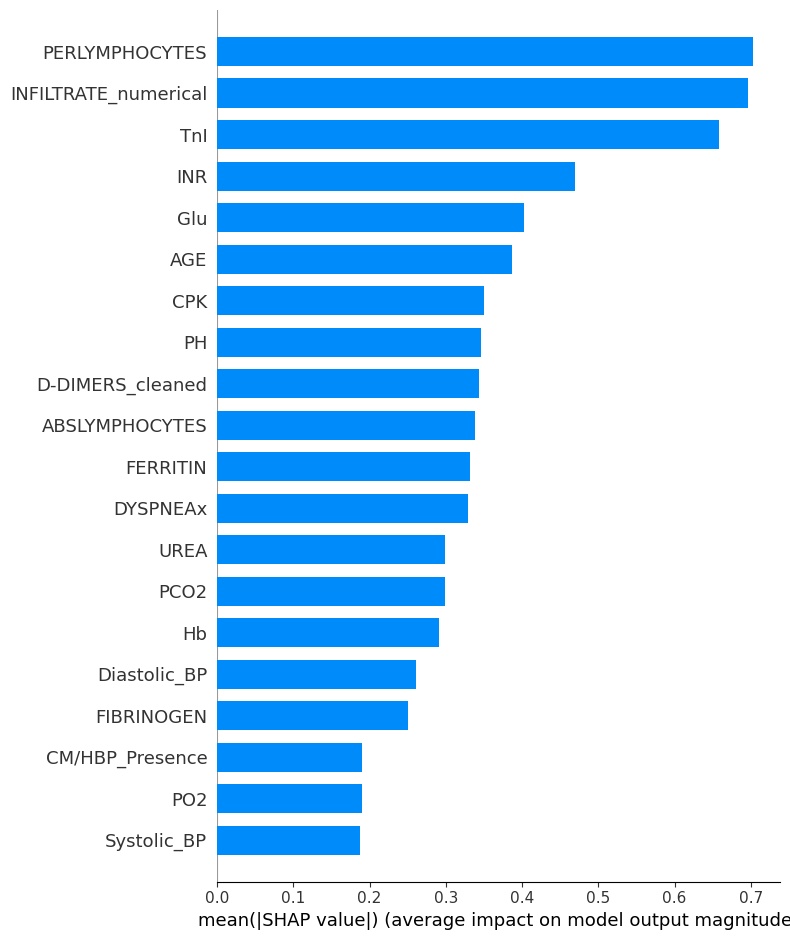

In [ ]:
# Visualization
for model_name, model_shap_values in shap_values.items():
    print(f"Model: {model_name}")
    # Check if SHAP values are in multi-class format (list of arrays)
    if isinstance(model_shap_values, list): 
        # Aggregate SHAP values across all classes for each sample
        values_aggregated = np.sum(np.abs(model_shap_values), axis=0) 
    else:
        # Use directly if already in the correct format
        values_aggregated = model_shap_values
    
    # Ensure we have a 2D array for the summary plot
    if len(values_aggregated.shape) == 1:
        # This means SHAP values are somehow still a vector; try reshaping or debugging how they were aggregated
        continue 
    
    # Now plotting with the aggregated (summed across classes) SHAP values
    shap.summary_plot(values_aggregated, X_test, plot_type="bar", feature_names=X_test.columns, max_display=20)


Model: Random Forest


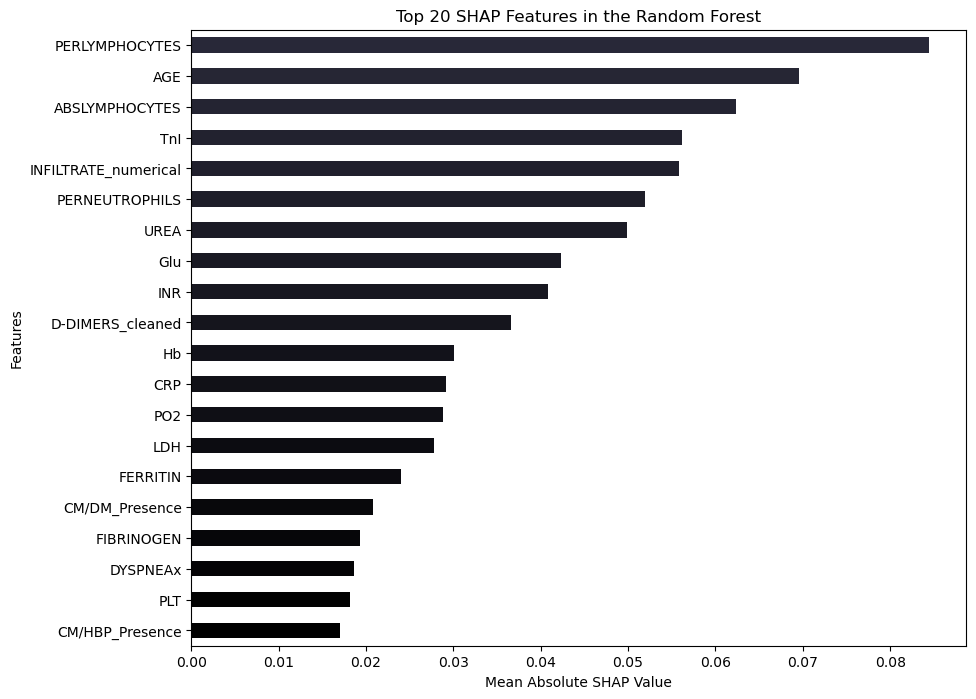

Model: XGBoost


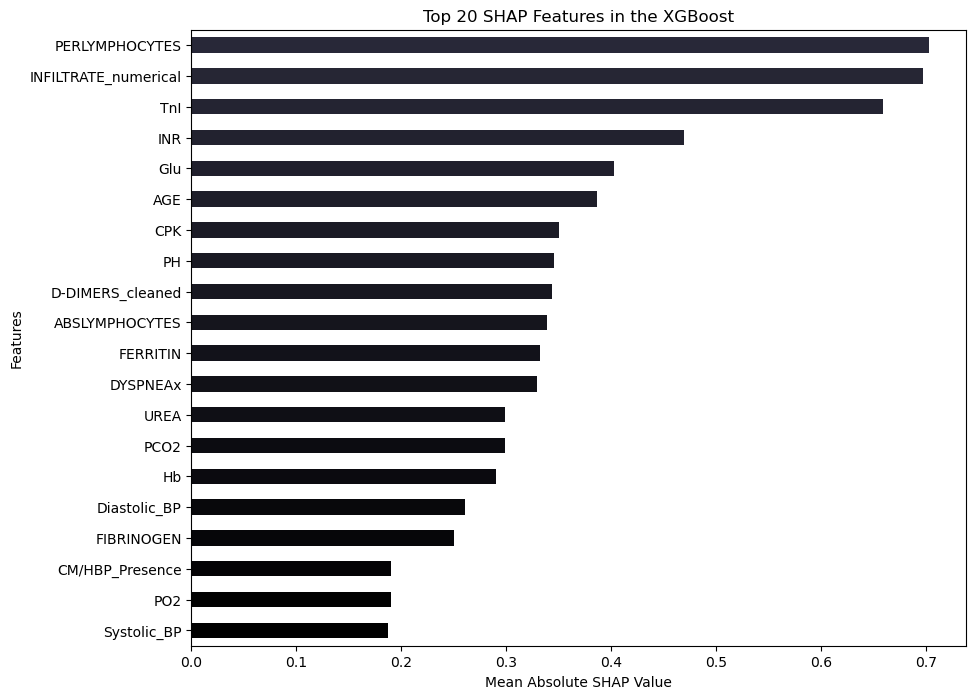

In [ ]:
for model_name, model_shap_values in shap_values.items():
    print(f"Model: {model_name}")
    if isinstance(model_shap_values, list):
        # Aggregate SHAP values across all classes for each sample
        values_aggregated = np.abs(np.array(model_shap_values)).sum(axis=0).mean(axis=0)
    else:
        # Use directly if already in the correct format (mean absolute values)
        values_aggregated = np.abs(model_shap_values).mean(axis=0)

    # Create a Series for easy plotting, ensuring feature names align
    importances = pd.Series(values_aggregated, index=X_test.columns).sort_values(ascending=True)

    # Plotting in a similar style to your example
    plt.figure(figsize=(10, 8))
    bone_colors = plt.cm.bone(np.linspace(0, 1, len(importances)))
    importances.tail(20).plot(kind='barh', color=bone_colors) 
    plt.title(f'Top 20 SHAP Features in the {model_name}')
    plt.xlabel('Mean Absolute SHAP Value')
    plt.ylabel('Features')
    plt.gca()  
    plt.show()


In [ ]:
feature_names = X_train.columns

# Get the top 8 features from the Random Forest model
top_features = pd.Series(optimized_rf.feature_importances_, index=feature_names).sort_values(ascending=False).head(8)

# Perform enrichment analysis
results = []

for feature in top_features.index:
    if dataset[feature].dtype == 'O' or len(dataset[feature].unique()) <= 2: 
        contingency_table = pd.crosstab(dataset[feature], dataset['Outcome_numerical'])
        chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
        effect_size = np.sqrt(chi2 / (contingency_table.values.sum() * (min(contingency_table.shape) - 1)))
        results.append((feature, 'Chi-square', p, effect_size))
    else:  # If the feature is continuous
        model = sm.Logit(dataset['Outcome_numerical'], sm.add_constant(dataset[feature])).fit(disp=0)
        p = model.pvalues[feature]
        coeff = model.params[feature]
        results.append((feature, 'Logistic Regression', p, coeff))

# Print the results
print("Feature Analysis Results:")
for result in results:
    feature, analysis_type, p_value, effect_measure = result
    print(f"{feature} ({analysis_type}): p-value = {p_value:.4f}, Effect Measure = {effect_measure:.4f}")


Feature Analysis Results:
PERLYMPHOCYTES (Logistic Regression): p-value = 0.0000, Effect Measure = 0.0902
AGE (Logistic Regression): p-value = 0.0000, Effect Measure = -0.0446
UREA (Logistic Regression): p-value = 0.0000, Effect Measure = -0.0536
TnI (Logistic Regression): p-value = 0.0000, Effect Measure = -0.0328
PERNEUTROPHILS (Logistic Regression): p-value = 0.0000, Effect Measure = -0.0773
ABSLYMPHOCYTES (Logistic Regression): p-value = 0.0858, Effect Measure = 0.2719
INR (Logistic Regression): p-value = 0.0000, Effect Measure = -3.7858
Glu (Logistic Regression): p-value = 0.0000, Effect Measure = -0.0159


In [ ]:
# List of top 5 features from your model's SHAP values
top_features = ['PERLYMPHOCYTES', 'TnI', 'INFILTRATE_numerical', 'PERNEUTROPHILS', 'AGE', 'INR', 'UREA', 'ABSLYMPHOCYTES']
outcome = 'Outcome_numerical'

# Perform enrichment analysis
results = []

for feature in top_features:
    if dataset[feature].dtype == 'O' or len(dataset[feature].unique()) <= 2:  
        contingency_table = pd.crosstab(dataset[feature], dataset[outcome])
        chi2, p, dof, _ = stats.chi2_contingency(contingency_table)
        effect_size = np.sqrt(chi2 / (contingency_table.values.sum() * (min(contingency_table.shape) - 1)))
        results.append((feature, 'Chi-square', p, effect_size))
    else:  # For continuous features
        model = sm.Logit(dataset[outcome], sm.add_constant(dataset[feature])).fit(disp=0)
        p = model.pvalues[feature]
        coeff = model.params[feature]
        results.append((feature, 'Logistic Regression', p, coeff))

# Print the results
print("Feature Analysis Results:")
for result in results:
    feature, analysis_type, p_value, effect_measure = result
    print(f"{feature} ({analysis_type}): p-value = {p_value:.4f}, Effect Measure = {effect_measure:.4f}")


Feature Analysis Results:
PERLYMPHOCYTES (Logistic Regression): p-value = 0.0000, Effect Measure = 0.0902
TnI (Logistic Regression): p-value = 0.0000, Effect Measure = -0.0328
INFILTRATE_numerical (Logistic Regression): p-value = 0.0000, Effect Measure = 0.5317
PERNEUTROPHILS (Logistic Regression): p-value = 0.0000, Effect Measure = -0.0773
AGE (Logistic Regression): p-value = 0.0000, Effect Measure = -0.0446
INR (Logistic Regression): p-value = 0.0000, Effect Measure = -3.7858
UREA (Logistic Regression): p-value = 0.0000, Effect Measure = -0.0536
ABSLYMPHOCYTES (Logistic Regression): p-value = 0.0858, Effect Measure = 0.2719


In [117]:
# Print all column names in the dataset
print(list(dataset.columns))


['AGE', 'GENDER', 'Systolic_BP', 'Diastolic_BP', 'PULSE RATE', 'TEMP', 'PH', 'PO2', 'PCO2', 'HCO3', 'WBC', 'LDH', 'CPK', 'CRP', 'FERRITIN', 'PERNEUTROPHILS', 'PERLYMPHOCYTES', 'ABSLYMPHOCYTES', 'Hb', 'PLT', 'INR', 'APTT', 'FIBRINOGEN', 'D-DIMERS_cleaned', 'K', 'NA', 'Glu', 'UREA', 'CR', 'BIL', 'DIRECT BIL', 'SGOT', 'SGPT', 'TnI', 'Outcome_numerical', 'INFILTRATE_numerical', 'FEVERx', 'COUGHx', 'FATIGUEx', 'DIARRHEASx', 'DYSPNEAx', 'URTIx', 'HEADACHE', 'ANOSMIA', 'NAUSEA', 'DIZZINESS-INSTABILITY-CONFUSION', 'PLEURAL EFFUSION', 'VOMITING', 'CM/CHF_Presence', 'CM/CAD_Presence', 'CM/AF_Presence', 'CM/HBP_Presence', 'CM/asthma_Presence', 'CM/COPD_Presence', 'CM/DM_Presence', 'DM REGISTRY_Presence', 'CM/neoplasm_Presence', 'CM/CNS_Presence', 'CM/GI_Presence', 'CM/renal_Presence', 'cm/autoimm_Presence', 'CM/lipid_Presence', 'CM/metabolic/other_Presence', 'Chronic_Kidney_Disease', 'Psychiatric_Disorder', 'Chronic_Lymphocytic_Leukemia', 'Hepatitis_B_Virus', 'Abdominal_Aortic_Aneurysm', 'Lymphom

In [118]:
print(shap_values.keys())


dict_keys(['Random Forest', 'XGBoost'])


In [ ]:
feature_index = 'INFILTRATE_numerical'
features_for_shap = dataset.drop(['Outcome_numerical'], axis=1)

# Confirm the operation
print("Adjusted dataset shape for SHAP:", features_for_shap.shape)

# Now retry generating the SHAP dependence plot
try:
    shap.dependence_plot(feature_index, model_shap_values, features_for_shap)
except IndexError as e:
    print("An IndexError occurred:", e)
    print("This usually means there is still a mismatch between dataset features and SHAP values.")


Adjusted dataset shape for SHAP: (470, 115)
An IndexError occurred: index 212 is out of bounds for axis 0 with size 212
This usually means there is still a mismatch between dataset features and SHAP values.


In [125]:
print("Shape or structure of SHAP values:", type(model_shap_values))
if isinstance(model_shap_values, list):
    print("Length of SHAP values list:", len(model_shap_values))
    print("Shape of first element:", model_shap_values[0].shape)
else:
    print("Shape of SHAP values array:", model_shap_values.shape)


Shape or structure of SHAP values: <class 'numpy.ndarray'>
Shape of SHAP values array: (212, 106)


In [126]:
if isinstance(model_shap_values, list):
    # Adjusting to select SHAP values for the positive class, which is often at index 1
    model_shap_values = model_shap_values[1]


In [128]:
# Re-check the correct index of 'INFILTRATE_numerical' in the adjusted dataset
new_feature_index = features_for_shap.columns.get_loc('INFILTRATE_numerical')
print("New Feature Index for 'INFILTRATE_numerical':", new_feature_index)

# Attempt to plot again using the feature name directly to avoid indexing issues
try:
    shap.dependence_plot('INFILTRATE_numerical', model_shap_values, features_for_shap)
except Exception as e:  # Catching any type of exception to diagnose
    print("An error occurred:", e)


New Feature Index for 'INFILTRATE_numerical': 34
An error occurred: index 212 is out of bounds for axis 0 with size 212


In [ ]:
# First, ensure you have the SHAP values for 'INFILTRATE_numerical'
shap_values_for_feature = model_shap_values[:, features_for_shap.columns.get_loc('INFILTRATE_numerical')]

# Then, ensure you have the feature values for 'INFILTRATE_numerical'
feature_values = features_for_shap['INFILTRATE_numerical']

# Now, check the lengths of both arrays to ensure they align
print("Length of SHAP values array:", len(shap_values_for_feature))
print("Length of feature values array:", len(feature_values))


Length of SHAP values array: 212
Length of feature values array: 470


Length of SHAP values array: 212
Length of feature values array: 470


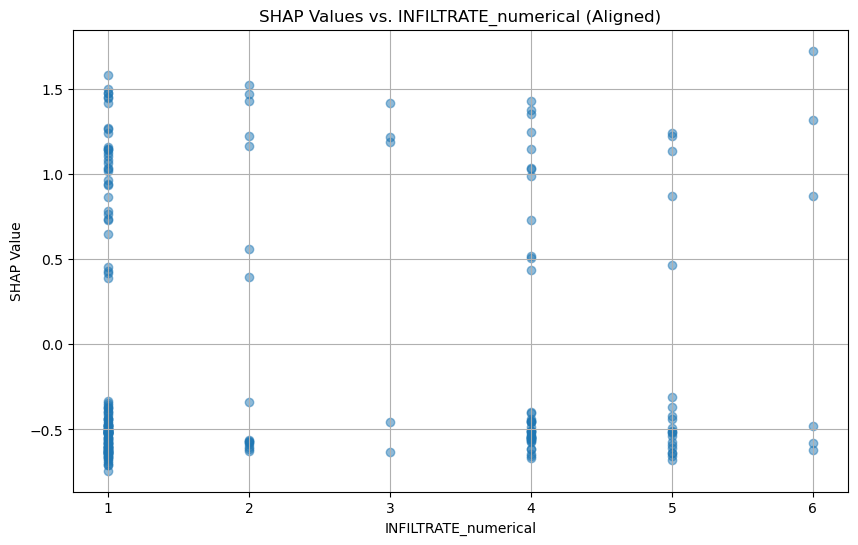

In [ ]:
# Check the lengths of the arrays
print("Length of SHAP values array:", len(shap_values_for_feature))
print("Length of feature values array:", len(feature_values))

min_length = min(len(shap_values_for_feature), len(feature_values))
shap_values_for_feature_aligned = shap_values_for_feature[:min_length]
feature_values_aligned = feature_values[:min_length]

# Now try plotting again with the aligned arrays
plt.figure(figsize=(10, 6))
plt.scatter(feature_values_aligned, shap_values_for_feature_aligned, alpha=0.5)
plt.xlabel('INFILTRATE_numerical')
plt.ylabel('SHAP Value')
plt.title('SHAP Values vs. INFILTRATE_numerical (Aligned)')
plt.grid(True)
plt.show()


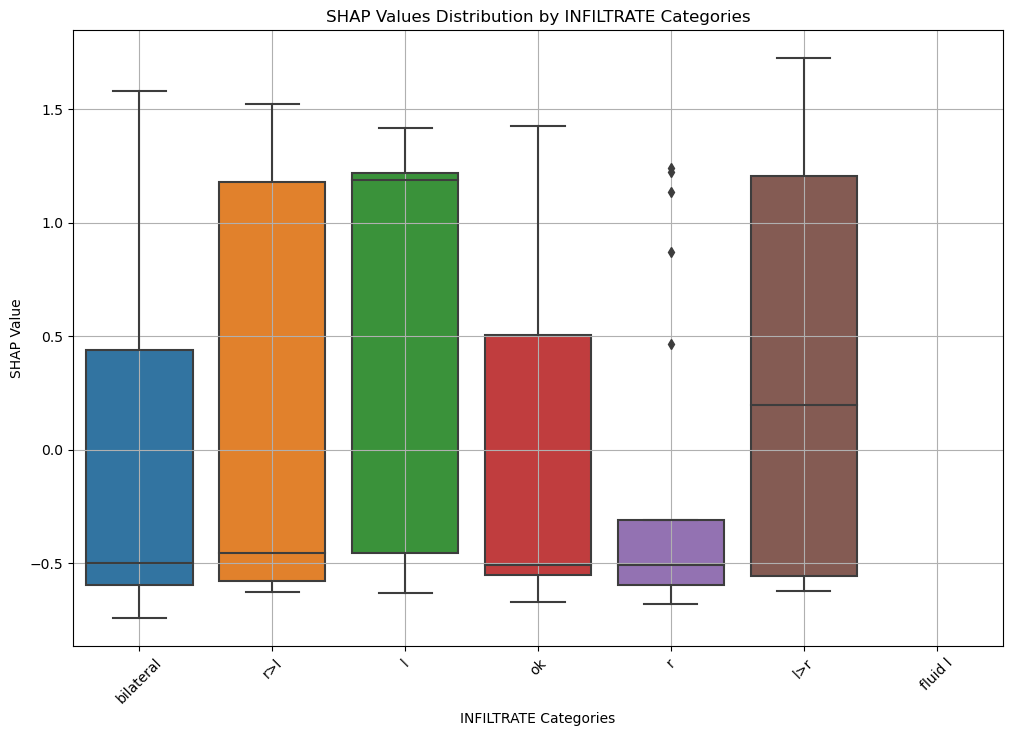

In [ ]:
plot_data = pd.DataFrame({
    'INFILTRATE_numerical': feature_values_aligned, 
    'SHAP Value': shap_values_for_feature_aligned
})

# Map numerical values back to their original categories for readability
category_map = {
    1: 'bilateral', 2: 'r>l', 3: 'l', 4: 'ok', 
    5: 'r', 6: 'l>r', 7: 'fluid l'
}
plot_data['INFILTRATE_category'] = plot_data['INFILTRATE_numerical'].map(category_map)

# Create the box plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='INFILTRATE_category', y='SHAP Value', data=plot_data, order=category_map.values())
plt.title('SHAP Values Distribution by INFILTRATE Categories')
plt.xlabel('INFILTRATE Categories')
plt.ylabel('SHAP Value')
plt.xticks(rotation=45)  
plt.grid(True)
plt.show()


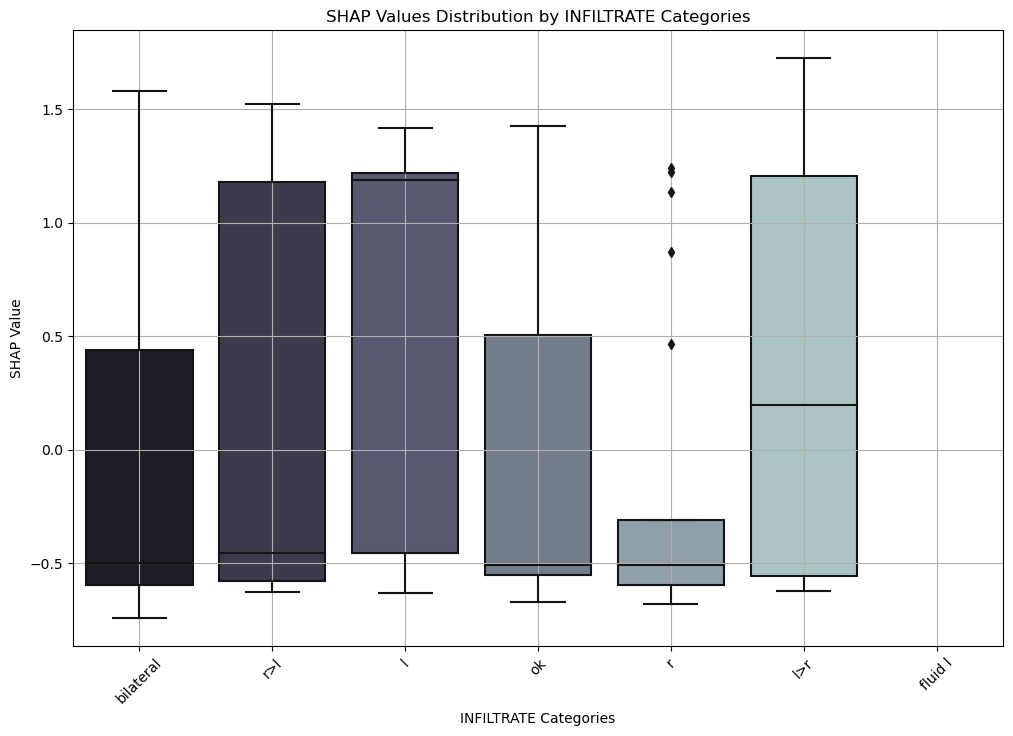

In [ ]:
bone_palette = sns.color_palette("bone", len(category_map.values())) 

# Create the box plot with the 'bone' color palette
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='INFILTRATE_category', y='SHAP Value', data=plot_data, 
                 order=category_map.values(), palette=bone_palette)
plt.title('SHAP Values Distribution by INFILTRATE Categories')
plt.xlabel('INFILTRATE Categories')
plt.ylabel('SHAP Value')
plt.xticks(rotation=45) 
plt.grid(True)

# Calculate and annotate count above each box
counts = plot_data['INFILTRATE_category'].value_counts().reindex(category_map.values(), fill_value=0)
total = len(plot_data)
for i, box in enumerate(ax.artists):
    box_count = counts[category_map[i+1]] 
    percentage = 100 * box_count / total
    # Formatting the annotation text
    text = f'{box_count} ({percentage:.1f}%)'
    # Setting the position and the text of the annotation
    ax.text(
        i,  
        ax.get_ylim()[1] + 0.02, 
        text,  
        horizontalalignment='center',  
        verticalalignment='bottom',  
        fontsize=10,  
        color='black' 
    )

plt.show()


In [ ]:
tni_shap_values = model_shap_values[:, features_for_shap.columns.get_loc('TnI')] 
tni_feature_values = features_for_shap['TnI'].values 

In [109]:
# Assuming actual_outcomes aligns with tni_feature_values before trimming
actual_outcomes_aligned = 'Outcome_numerical'[:min_length]
actual_outcomes_aligned

'Outcome_numerical'

Length of TnI feature values array: 470
Length of TnI SHAP values array: 212


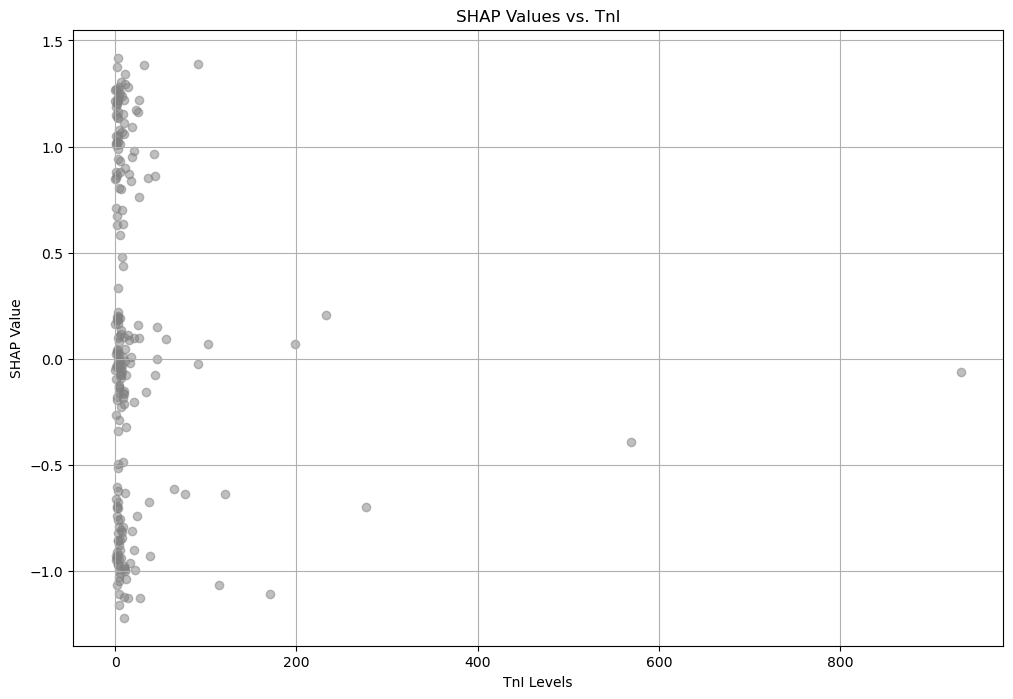

In [110]:
# Verify the lengths of the arrays
print("Length of TnI feature values array:", len(tni_feature_values))
print("Length of TnI SHAP values array:", len(tni_shap_values))

# Trim the longer array to match the shorter one, if necessary
min_length = min(len(tni_feature_values), len(tni_shap_values))
tni_feature_values_aligned = tni_feature_values[:min_length]
tni_shap_values_aligned = tni_shap_values[:min_length]

# Now try plotting again with the aligned arrays
plt.figure(figsize=(12, 8))
plt.scatter(tni_feature_values_aligned, tni_shap_values_aligned, alpha=0.5, c='grey')  # Using grey for individual points
plt.title('SHAP Values vs. TnI')
plt.xlabel('TnI Levels')
plt.ylabel('SHAP Value')
plt.grid(True)
plt.show()


In [111]:
# Assuming 'y' is your array or list of outcome labels and it's correctly ordered
# Trim it to match the length of the other aligned data
y_aligned = y[:min_length]

y_aligned

0      1
1      1
2      1
3      1
4      1
      ..
207    0
208    0
209    0
210    0
211    0
Name: Outcome_numerical, Length: 212, dtype: int64

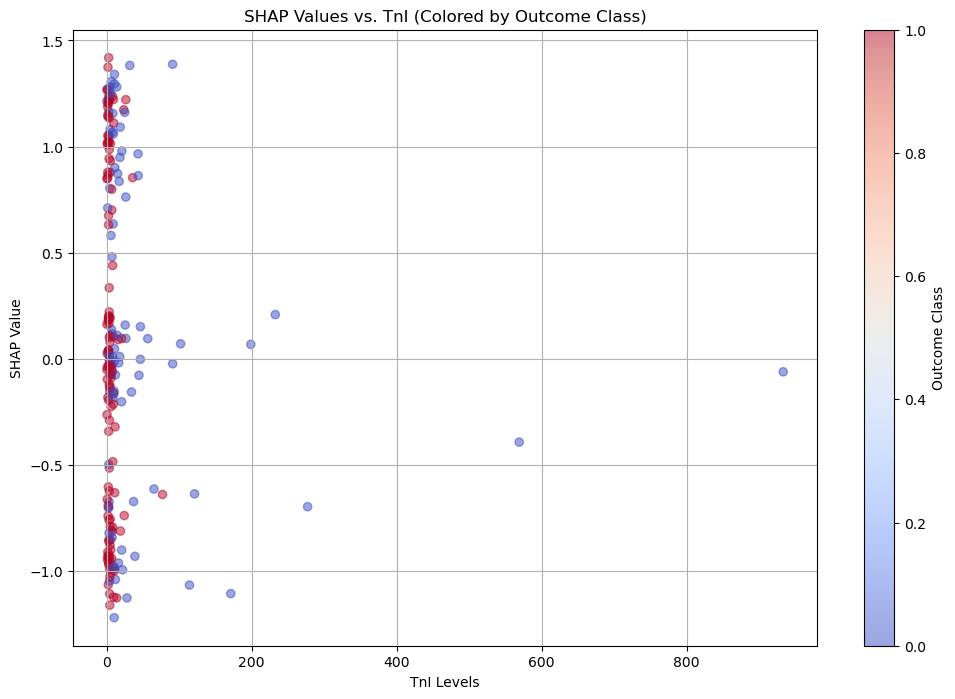

In [ ]:
# Assuming tni_feature_values_aligned and tni_shap_values_aligned are correctly aligned with these outcomes
import matplotlib.pyplot as plt

y_aligned = y.values[:min_length]  
plt.figure(figsize=(12, 8))
scatter = plt.scatter(tni_feature_values_aligned, tni_shap_values_aligned,
                      alpha=0.5, c=y_aligned, cmap='coolwarm')  
plt.title('SHAP Values vs. TnI (Colored by Outcome Class)')
plt.xlabel('TnI Levels')
plt.ylabel('SHAP Value')
plt.grid(True)
# Add a color bar to serve as a legend for the outcome classes
plt.colorbar(scatter, label='Outcome Class')  
plt.show()


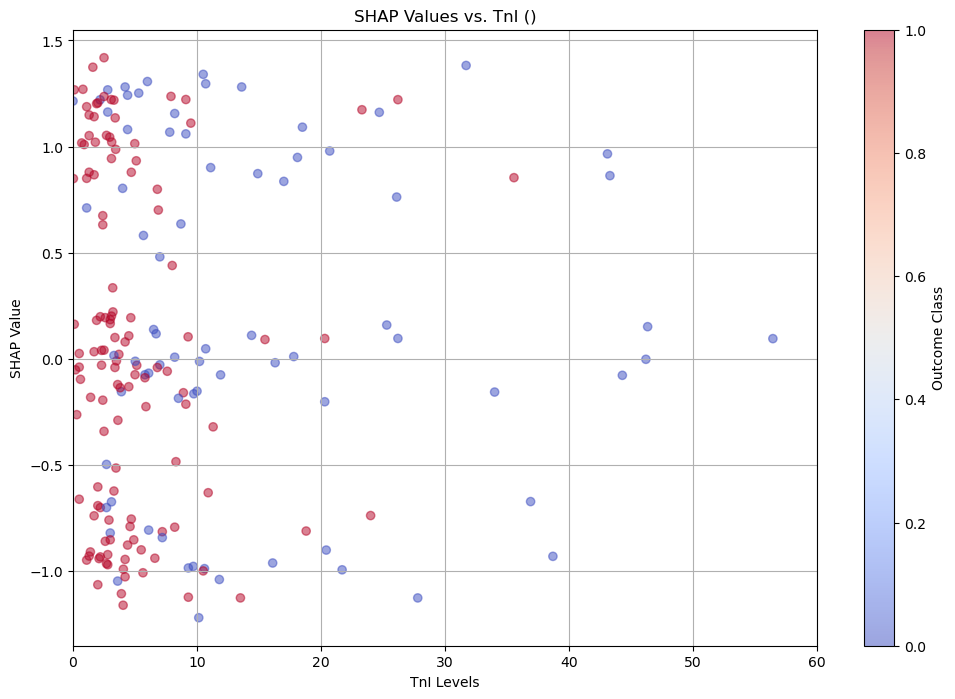

In [ ]:
# Plotting with the aligned arrays and outcome labels
plt.figure(figsize=(12, 8))
scatter = plt.scatter(tni_feature_values_aligned, tni_shap_values_aligned,
                      alpha=0.5, c=y_aligned, cmap='coolwarm') 
plt.title('SHAP Values vs. TnI ()')
plt.xlabel('TnI Levels')
plt.ylabel('SHAP Value')
plt.grid(True)
plt.xlim(0, 60)  
plt.colorbar(scatter, label='Outcome Class') 
plt.show()


In [ ]:
data = pd.DataFrame({
    'TnI Levels': tni_feature_values_aligned,
    'SHAP Values': tni_shap_values_aligned,
    'Outcome Class': y_aligned
})

# Define bins for 'TnI' levels
bins = np.arange(0, data['TnI Levels'].max() + 10, 10) 
data['TnI Bins'] = pd.cut(data['TnI Levels'], bins)

# Calculate average SHAP value for each bin
avg_shap_by_bin = data.groupby('TnI Bins')['SHAP Values'].mean()
print(avg_shap_by_bin)


TnI Bins
(0.0, 10.0]       0.107550
(10.0, 20.0]      0.024965
(20.0, 30.0]      0.128819
(30.0, 40.0]      0.094317
(40.0, 50.0]      0.379331
                    ...   
(890.0, 900.0]         NaN
(900.0, 910.0]         NaN
(910.0, 920.0]         NaN
(920.0, 930.0]         NaN
(930.0, 940.0]   -0.062092
Name: SHAP Values, Length: 94, dtype: float32


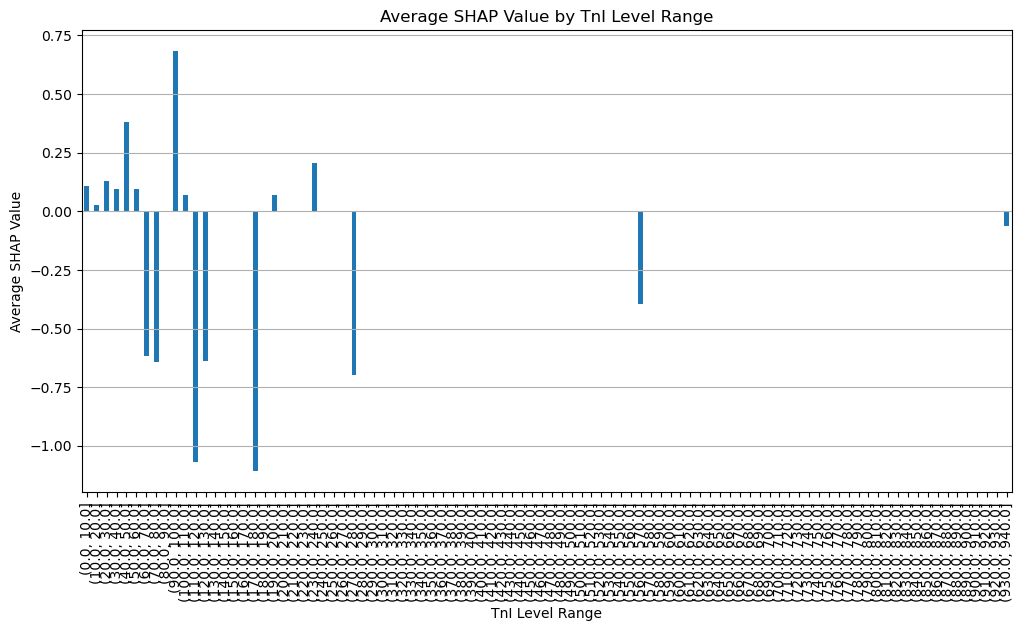

In [ ]:
# Binning 'TnI' levels and calculating average SHAP values again for clarity
bins = np.arange(0, data['TnI Levels'].max() + 10, 10) 
data['TnI Bins'] = pd.cut(data['TnI Levels'], bins)
avg_shap_by_bin = data.groupby('TnI Bins')['SHAP Values'].mean()

# Plotting
avg_shap_by_bin.plot(kind='bar', figsize=(12, 6))
plt.title('Average SHAP Value by TnI Level Range')
plt.xlabel('TnI Level Range')
plt.ylabel('Average SHAP Value')
plt.grid(axis='y')
plt.show()


In [157]:
# Calculate the count of each class by 'TnI' bin
class_distribution = data.groupby(['TnI Bins', 'Outcome Class']).size().unstack(fill_value=0)

# Calculate percentages
class_percentages = class_distribution.divide(class_distribution.sum(axis=1), axis=0)
print(class_percentages)


Outcome Class          0         1
TnI Bins                          
(0.0, 10.0]     0.246667  0.753333
(10.0, 20.0]    0.750000  0.250000
(20.0, 30.0]    0.692308  0.307692
(30.0, 40.0]    0.800000  0.200000
(40.0, 50.0]    1.000000  0.000000
...                  ...       ...
(890.0, 900.0]       NaN       NaN
(900.0, 910.0]       NaN       NaN
(910.0, 920.0]       NaN       NaN
(920.0, 930.0]       NaN       NaN
(930.0, 940.0]  1.000000  0.000000

[94 rows x 2 columns]


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


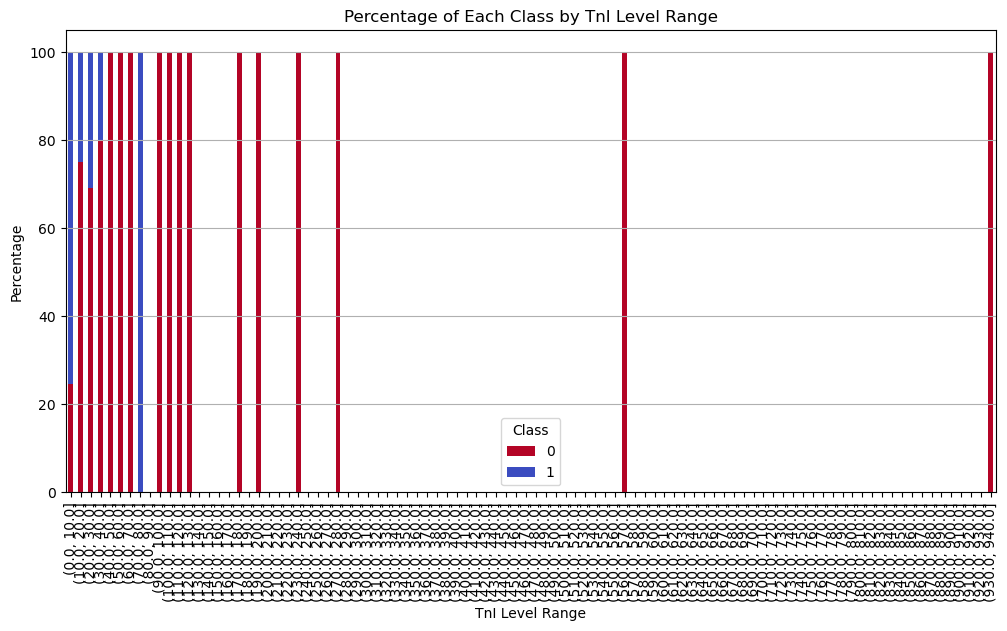

In [ ]:
# Calculate the percentage of each outcome class within each 'TnI' level range
class_percentages = class_distribution.divide(class_distribution.sum(axis=1), axis=0) * 100  
reversed_coolwarm = plt.cm.get_cmap('coolwarm_r')
# Plotting
class_percentages.plot(kind='bar', stacked=True, figsize=(12, 6), colormap=reversed_coolwarm) 
plt.title('Percentage of Each Class by TnI Level Range')
plt.xlabel('TnI Level Range')
plt.ylabel('Percentage')
plt.legend(title='Class')
plt.grid(axis='y')
plt.show()


In [159]:
y_aligned

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0])

In [ ]:
# Calculate evaluation metrics for each class
optimized_accuracy_ = accuracy_score(y_test, y_pred_)
optimized_precision_ = precision_score(y_test, y_pred_, average=None, zero_division=0)  
optimized_recall_ = recall_score(y_test, y_pred_, average=None, zero_division=0) 
optimized_f1_ = f1_score(y_test, y_pred_, average=None, zero_division=0) 

# Print the metrics for each class
print(f"Accuracy: {optimized_accuracy_}")
print("Precision for each class:", optimized_precision_)
print("Recall for each class:", optimized_recall_)
print("F1 Score for each class:", optimized_f1_)

# Calculate and display the confusion matrix
conf_matrix_ = confusion_matrix(y_test, y_pred_)
fig, ax = plt.subplots(figsize=(8, 8))  
disp_ = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_)
disp_.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized  with SMOTE')
plt.show()


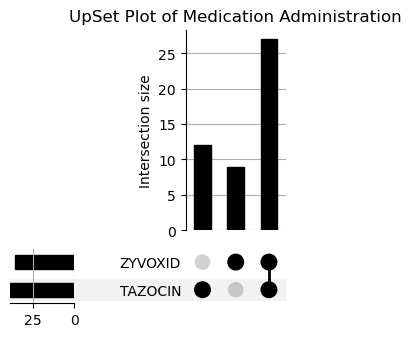

In [ ]:
from upsetplot import UpSet
from upsetplot import from_contents

data_dict = {
    'ZYVOXID': set(data_meds[data_meds['Medication_zyvoxid'] == 1].index),
    'TAZOCIN': set(data_meds[data_meds['Medication_tazocin'] == 1].index)
}

# Generate an UpSet data structure
upset_data = from_contents(data_dict)

# Create an UpSet plot
upset = UpSet(upset_data)
upset.plot()
plt.title('UpSet Plot of Medication Administration')
plt.show()


In [130]:
import plotly.express as px

# Create a simplified dataframe for the parallel categories plot
parallel_data = data_meds.assign(Med_Status=data_meds.apply(lambda x: f"{'ZYVOXID' if x['Medication_zyvoxid']==1 else 'No ZYVOXID'} -> {'TAZOCIN' if x['Medication_tazocin']==1 else 'No TAZOCIN'}", axis=1))

# Plotting
fig = px.parallel_categories(parallel_data, dimensions=['Medication_zyvoxid', 'Medication_tazocin'], color="Outcome",
                             labels={'Medication_zyvoxid': 'ZYVOXID Administered', 'Medication_tazocin': 'TAZOCIN Administered'},
                             color_continuous_scale=px.colors.sequential.Inferno)
fig.show()


In [ ]:
import plotly.express as px


# This combines the status of both medications into a single string for each patient
parallel_data = data_meds.assign(Med_Status=lambda df: df.apply(lambda x: f"{'ZYVOXID' if x['Medication_zyvoxid'] == 1 else 'No ZYVOXID'} -> {'TAZOCIN' if x['Medication_tazocin'] == 1 else 'No TAZOCIN'}", axis=1))

# Plotting the Parallel Categories Diagram
fig = px.parallel_categories(parallel_data, dimensions=['Medication_zyvoxid', 'Medication_tazocin', 'Outcome'],
                             color="Outcome",
                             labels={
                                 'Medication_zyvoxid': 'ZYVOXID Administered',
                                 'Medication_tazocin': 'TAZOCIN Administered',
                                 'Outcome': 'Patient Outcome'
                             },
                             color_continuous_scale=px.colors.sequential.Inferno  
                            )

# Update layout for better readability
fig.update_layout(
    title='Parallel Categories Diagram for Medication Administration and Patient Outcome',
    font_size=12,
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# Show the plot
fig.show()


In [ ]:
import plotly.express as px

# Define your updated faded blue-to-red color scale
blue_to_red_faded = [
    [0.0, '#6A7185'], 
    [1.0, '#A89B8C']   
]

# Plotting with the custom color scale
fig = px.parallel_categories(
    data_meds,
    dimensions=['Medication_zyvoxid', 'Medication_tazocin', 'Outcome_Text'],
    color='Outcome',  # Ensure this is the correct numeric column for outcomes
    color_continuous_scale=blue_to_red_faded  # Use the custom faded color scale
)

# Update layout for better readability
fig.update_layout(
    title='Parallel Categories Diagram for Medication Administration and Patient Severity',
    font_size=12,
    plot_bgcolor='white',
    paper_bgcolor='white',
    coloraxis_colorbar=dict(
        title=None,
        tickvals=[0, 1],
        ticktext=['Severe/Deceased', 'Non-Severe']
    )
)

# Show the plot
fig.show()


In [ ]:
import plotly.graph_objects as go

# Define a grayscale colorscale that can approximate 'bone'
grayscale = [
    [0.0, 'rgb(0, 0, 0)'],        # black
    [0.25, 'rgb(84, 84, 84)'],   # dark gray
    [0.5, 'rgb(169, 169, 169)'], # medium gray
    [0.75, 'rgb(211, 211, 211)'],# light gray
    [1.0, 'rgb(255, 255, 255)']  # white
]

fig = go.Figure(data=[
    go.Parcoords(
        line=dict(
            color=data_meds['Outcome'], 
            colorscale=grayscale,  
            showscale=True, 
            cmin=0, 
            cmax=1
        ),
        dimensions=[
            dict(label='ZYVOXID', values=data_meds['Medication_zyvoxid'], tickvals=[0, 1], ticktext=labels['Medication_zyvoxid']),
            dict(label='TAZOCIN', values=data_meds['Medication_tazocin'], tickvals=[0, 1], ticktext=labels['Medication_tazocin']),
            dict(label='Outcome', values=data_meds['Outcome'], tickvals=[0, 1], ticktext=labels['Outcome_Text'])
        ]
    )
])

# Customizing the layout
fig.update_layout(
    title='Parallel Sets Diagram for Medication Administration and Outcomes',
    font_size=10,
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# Show the plot
fig.show()


In [ ]:
import statsmodels.api as sm

features_to_analyze = ['ABSLYMPHOCYTES', 'PERLYMPHOCYTES', 'PERNEUTROPHILS']
outcome = 'Outcome_numerical'

# Perform logistic regression for each feature and print results
for feature in features_to_analyze:
    # Add a constant to the feature for the intercept
    X_with_const = sm.add_constant(dataset[feature].fillna(dataset[feature].median()))  # Fill NA with median for simplicity, adjust as needed
    model = sm.Logit(dataset[outcome], X_with_const).fit(disp=0)
    print(f"Logistic Regression Results for {feature}:")
    print(model.summary())
    print("\n")


Logistic Regression Results for ABSLYMPHOCYTES:
                           Logit Regression Results                           
Dep. Variable:      Outcome_numerical   No. Observations:                  470
Model:                          Logit   Df Residuals:                      468
Method:                           MLE   Df Model:                            1
Date:                Tue, 26 Mar 2024   Pseudo R-squ.:                 0.02314
Time:                        12:48:18   Log-Likelihood:                -312.21
converged:                       True   LL-Null:                       -319.61
Covariance Type:            nonrobust   LLR p-value:                 0.0001201
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0057      0.193     -0.030      0.976      -0.384       0.372
ABSLYMPHOCYTES     0.2719      0.158      1.718      0.086      -0.038 

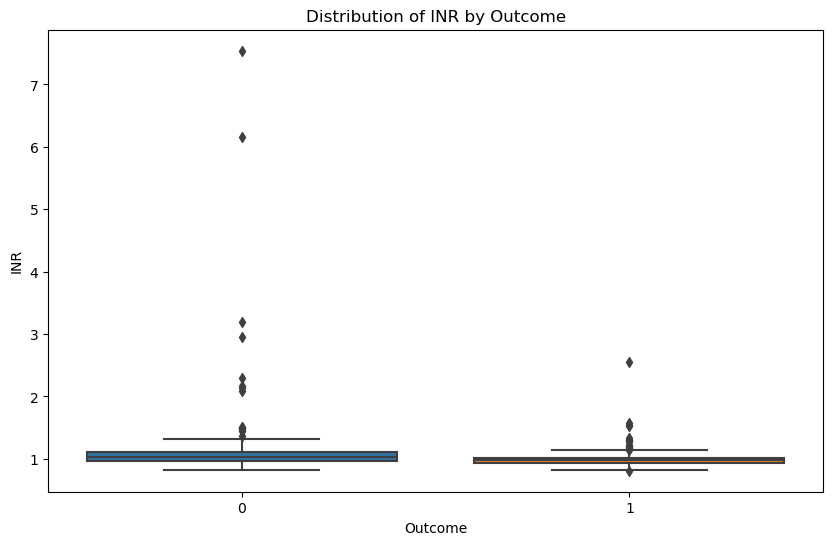

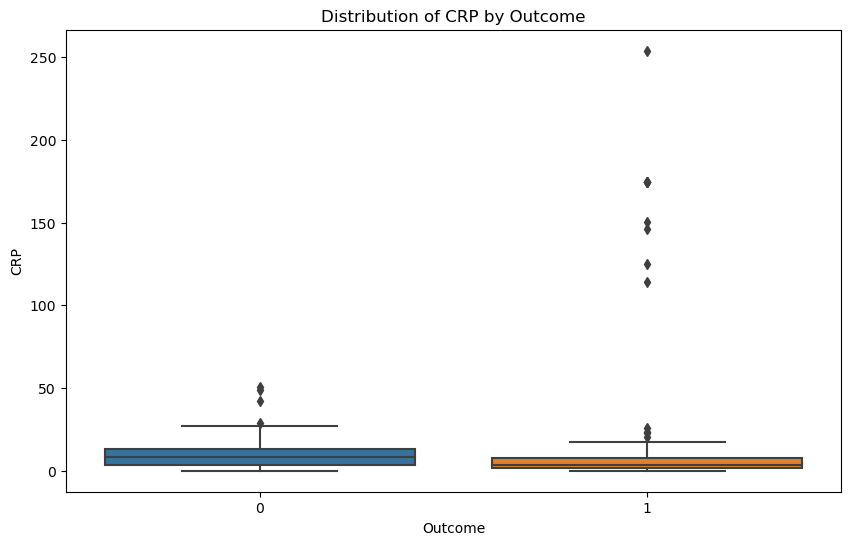

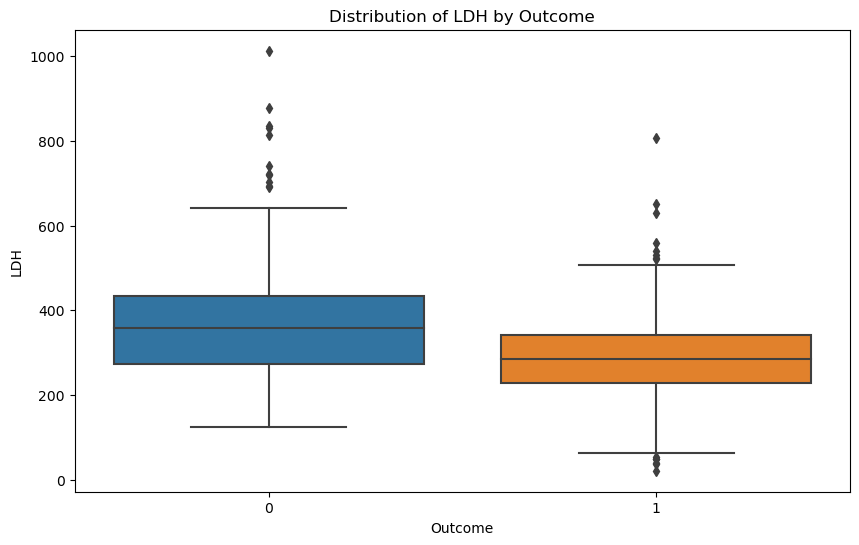

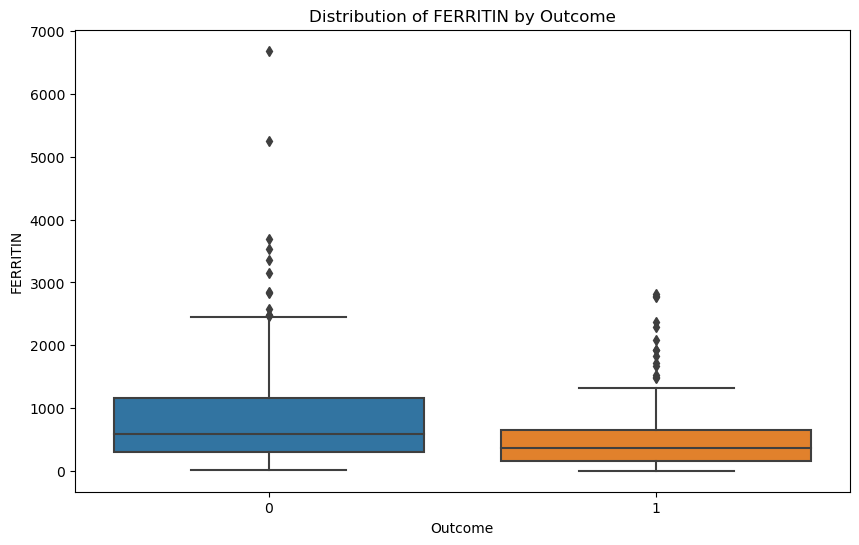

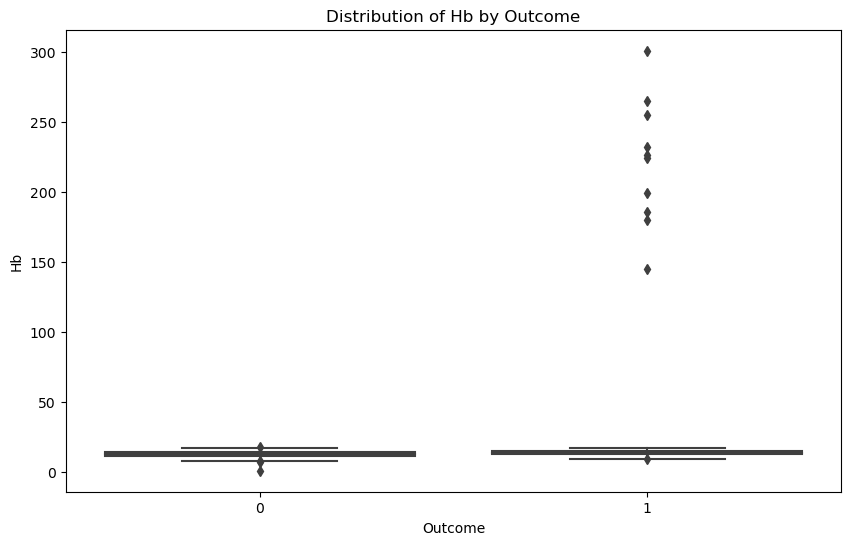

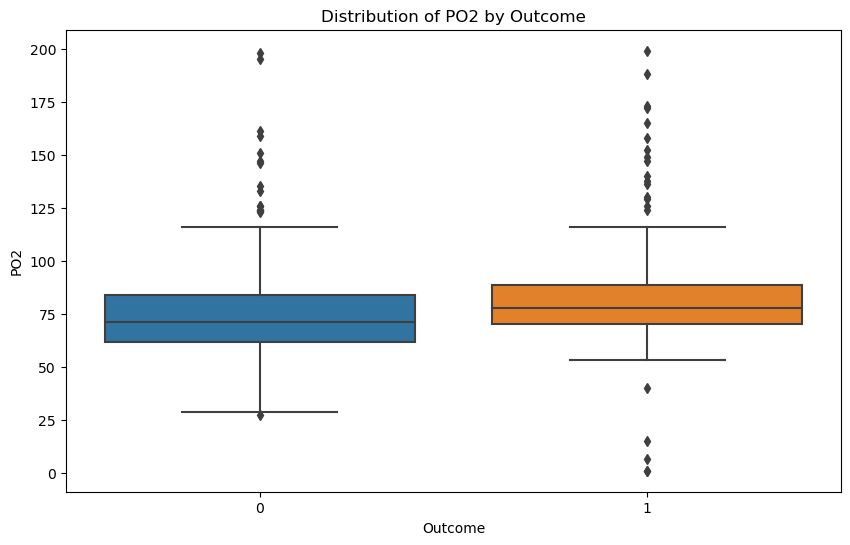

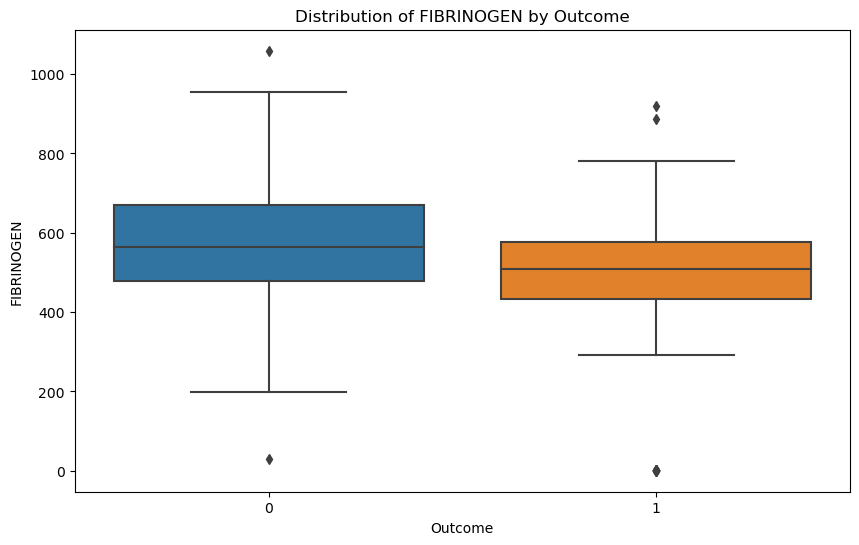

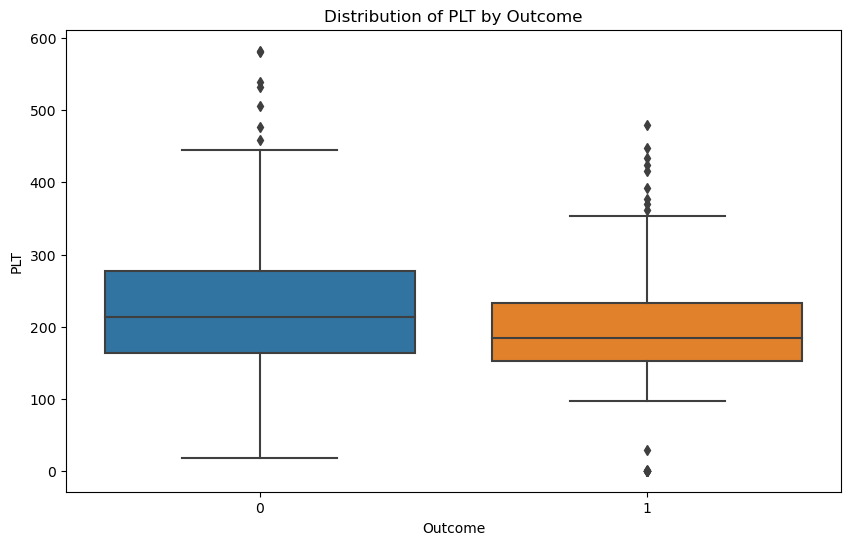

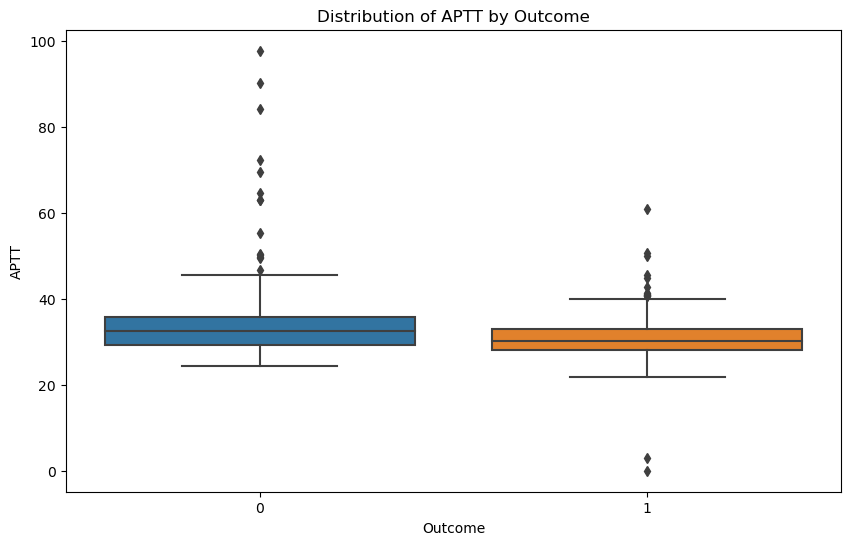

In [ ]:
# Plot distribution of features for different outcome classes
for feature in features_to_analyze:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=dataset[outcome], y=dataset[feature].fillna(dataset[feature].median())) 
    plt.title(f'Distribution of {feature} by Outcome')
    plt.xlabel('Outcome')
    plt.ylabel(feature)
    plt.show()


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


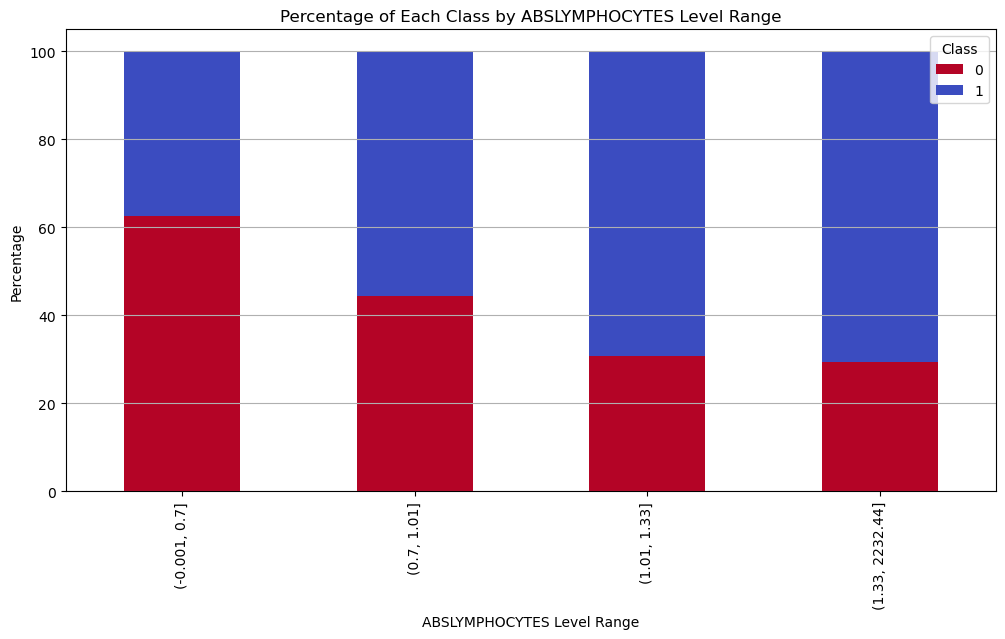

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


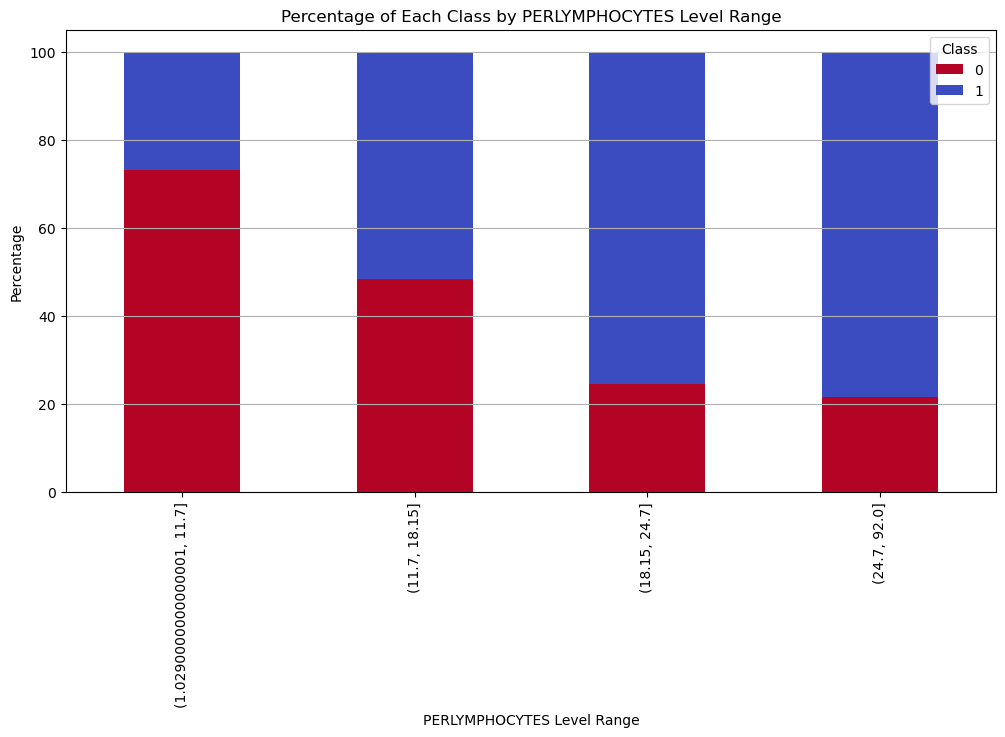

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


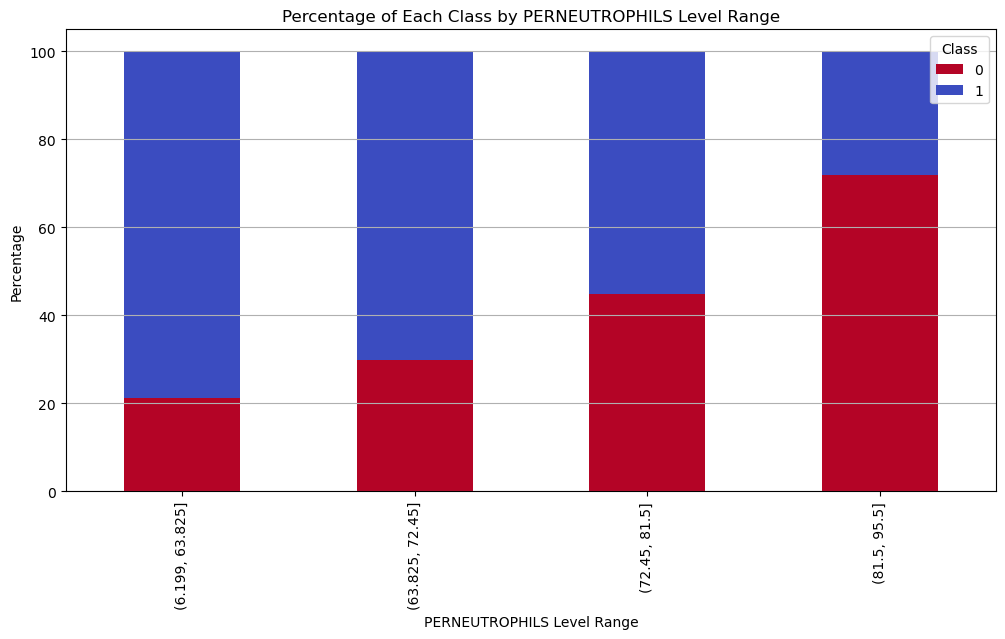

In [ ]:
# List of features to analyze
features_to_analyze = ['ABSLYMPHOCYTES', 'PERLYMPHOCYTES', 'PERNEUTROPHILS']
outcome = 'Outcome_numerical'  

# Loop through each feature and perform the analysis
for feature in features_to_analyze:
    # Bin the feature values into ranges
    dataset[f'{feature}_bins'] = pd.qcut(dataset[feature], 4, duplicates='drop') 
    # Calculate distribution of outcome within each bin
    class_distribution = dataset.groupby(f'{feature}_bins')[outcome].value_counts().unstack(fill_value=0)
    class_percentages = class_distribution.divide(class_distribution.sum(axis=1), axis=0) * 100  

    # Plotting
    reversed_coolwarm = plt.cm.get_cmap('coolwarm_r')
    class_percentages.plot(kind='bar', stacked=True, figsize=(12, 6), colormap=reversed_coolwarm)
    plt.title(f'Percentage of Each Class by {feature} Level Range')
    plt.xlabel(f'{feature} Level Range')
    plt.ylabel('Percentage')
    plt.legend(title='Class', loc='upper right')
    plt.grid(axis='y')
    plt.show()




`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



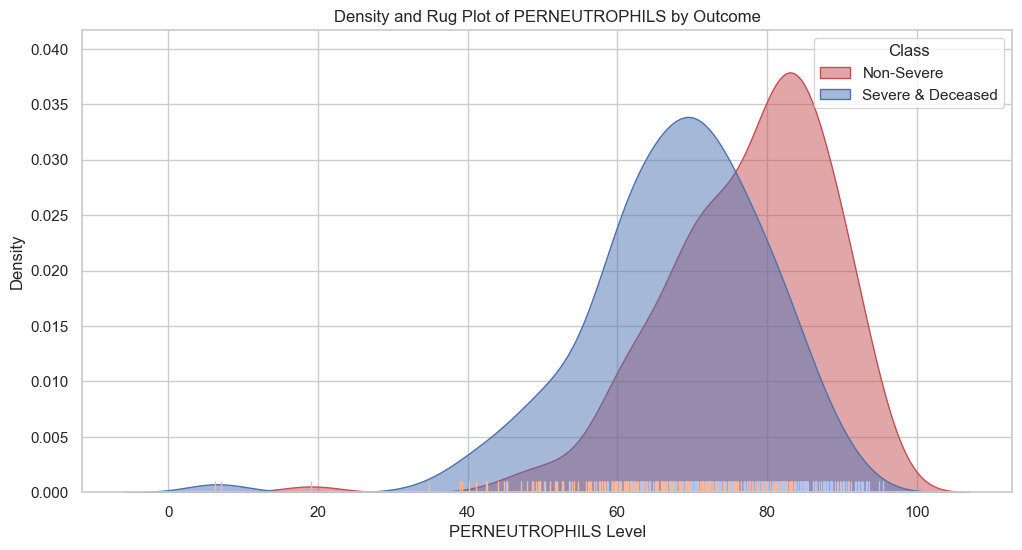

In [ ]:
# Set the style and size of the plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plot density plots for each outcome category with a rug plot
sns.kdeplot(data=dataset[dataset[outcome] == 0], x=feature, shade=True, label='Non-Severe', color="r", alpha=0.5)
sns.kdeplot(data=dataset[dataset[outcome] == 1], x=feature, shade=True, label='Severe & Deceased', color="b", alpha=0.5)
sns.rugplot(data=dataset, x=feature, hue=outcome, palette="coolwarm")

plt.title(f'Density and Rug Plot of {feature} by Outcome')
plt.xlabel(f'{feature} Level')
plt.ylabel('Density')
plt.legend(title='Class')
plt.show()


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


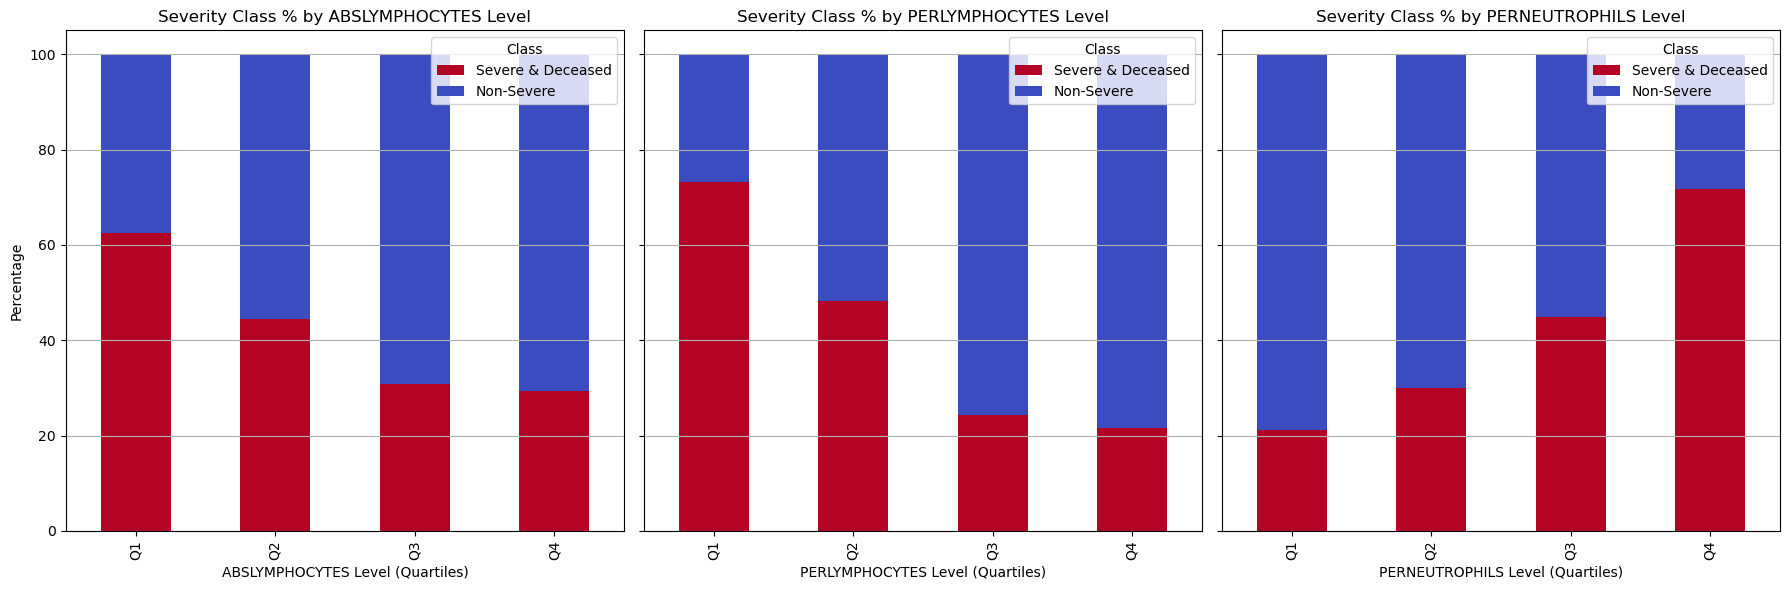

In [ ]:
features_to_analyze = ['ABSLYMPHOCYTES', 'PERLYMPHOCYTES', 'PERNEUTROPHILS']
outcome = 'Outcome_numerical' 

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for idx, feature in enumerate(features_to_analyze):
    # Create quartile bins for the current feature
    dataset[f'{feature}_bins'] = pd.qcut(dataset[feature], 4, duplicates='drop', labels=['Q1', 'Q2', 'Q3', 'Q4'])  # Quartiles with labels

    # Calculate distribution of outcome within each bin
    class_distribution = dataset.groupby(f'{feature}_bins')[outcome].value_counts().unstack(fill_value=0)
    class_percentages = class_distribution.divide(class_distribution.sum(axis=1), axis=0) * 100  
    
    # Plotting using the subplot axis
    reversed_coolwarm = plt.cm.get_cmap('coolwarm_r')
    ax = class_percentages.plot(kind='bar', stacked=True, colormap=reversed_coolwarm, ax=axes[idx])
    axes[idx].set_title(f'Severity Class % by {feature} Level')
    axes[idx].set_xlabel(f'{feature} Level (Quartiles)')
    axes[idx].set_ylabel('Percentage')
    axes[idx].grid(axis='y')
    
    # Update the legend
    ax.legend(title='Class', labels=['Severe & Deceased', 'Non-Severe'])

# Adjust layout
plt.tight_layout()
plt.show()

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


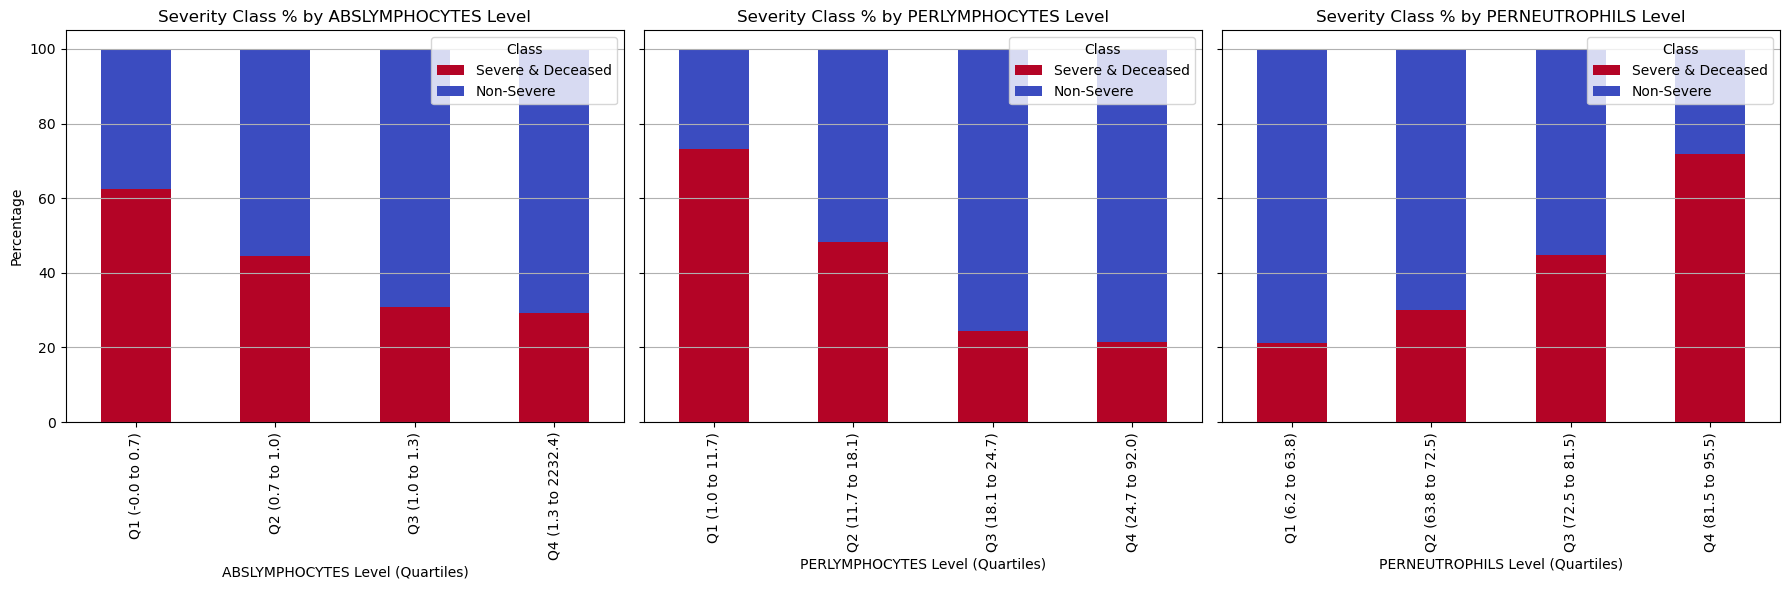

In [ ]:
features_to_analyze = ['ABSLYMPHOCYTES', 'PERLYMPHOCYTES', 'PERNEUTROPHILS']
outcome = 'Outcome_numerical'  # Adjust if your outcome column name is different

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # 1 row, 3 columns

for idx, feature in enumerate(features_to_analyze):
    # Create quartile bins for the current feature and also generate range labels for each quartile
    quartiles = pd.qcut(dataset[feature], 4, duplicates='drop')
    range_labels = quartiles.cat.categories.to_list() 
    label_names = [f'Q{i+1} ({range_label.left:.1f} to {range_label.right:.1f})' for i, range_label in enumerate(range_labels)]  
    
    dataset[f'{feature}_bins'] = pd.qcut(dataset[feature], 4, duplicates='drop', labels=label_names)  

    # Calculate distribution of outcome within each bin
    class_distribution = dataset.groupby(f'{feature}_bins')[outcome].value_counts().unstack(fill_value=0)
    class_percentages = class_distribution.divide(class_distribution.sum(axis=1), axis=0) * 100  
    
    # Plotting using the subplot axis
    reversed_coolwarm = plt.cm.get_cmap('coolwarm_r')
    ax = class_percentages.plot(kind='bar', stacked=True, colormap=reversed_coolwarm, ax=axes[idx])
    axes[idx].set_title(f'Severity Class % by {feature} Level')
    axes[idx].set_xlabel(f'{feature} Level (Quartiles)')
    axes[idx].set_ylabel('Percentage')
    axes[idx].grid(axis='y')
    
    # Update the legend
    ax.legend(title='Class', labels=['Severe & Deceased', 'Non-Severe'])

# Adjust layout
plt.tight_layout()
plt.show()


Skipping FIO2 eisagwgh_cleaned due to error: Bin labels must be one fewer than the number of bin edges


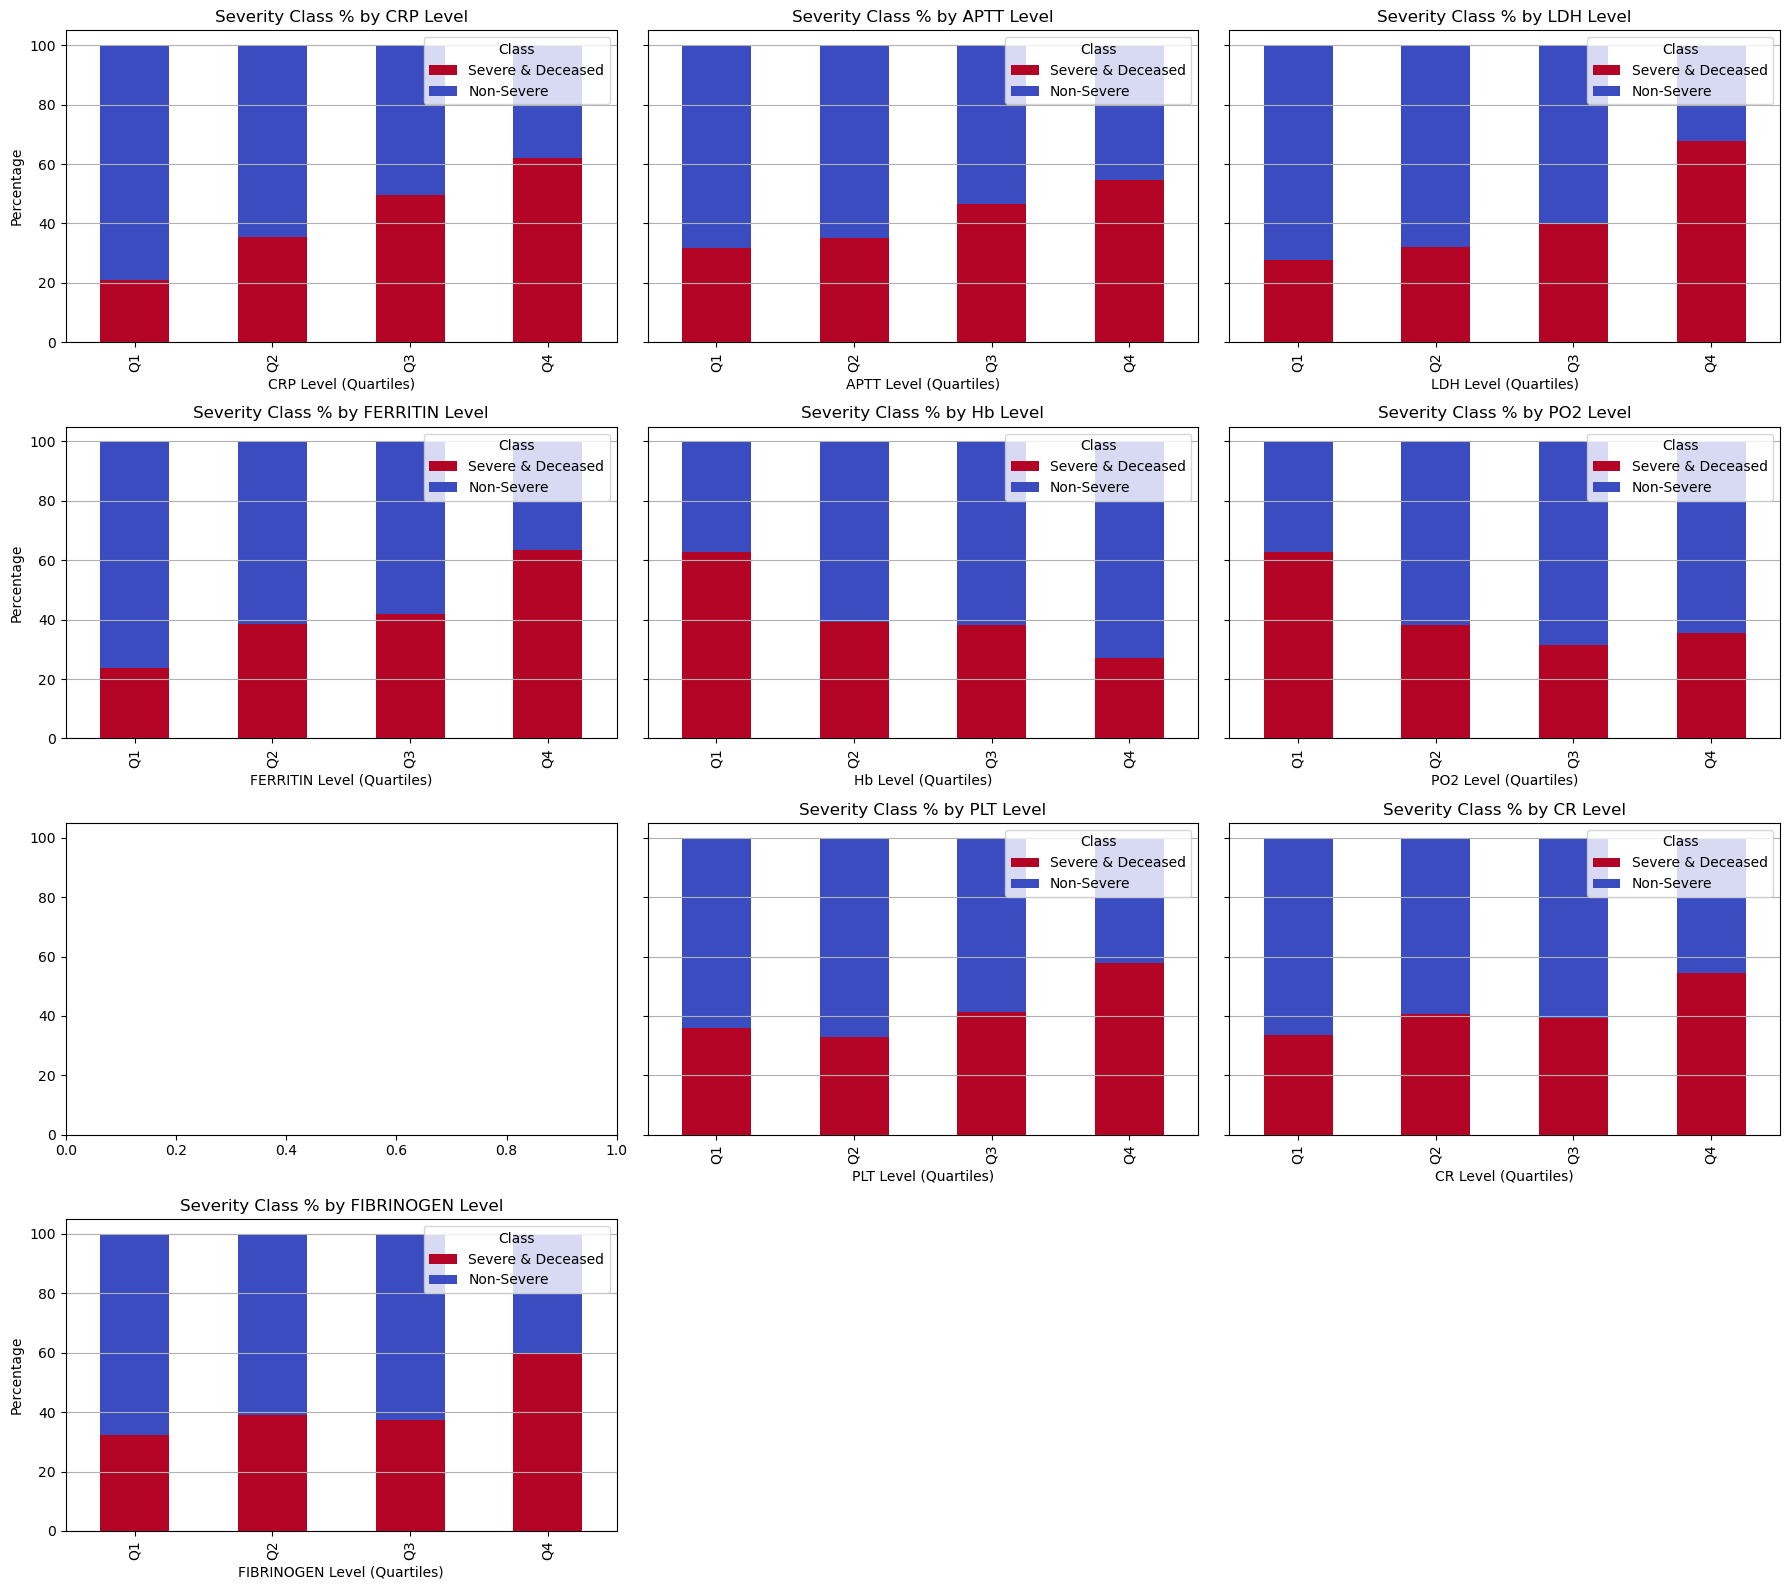

In [ ]:
features_to_analyze = [
    'CRP', 'APTT', 'LDH', 'FERRITIN', 'Hb', 'PO2', 
    'FIO2 eisagwgh_cleaned', 'PLT', 'CR', 'FIBRINOGEN'
]

outcome = 'Outcome_numerical' 

# Calculate the number of plots needed (1 plot per feature)
num_plots = len(features_to_analyze)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols 

# Set up the matplotlib figure
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 4), sharey=True)

for idx, feature in enumerate(features_to_analyze):
    row = idx // num_cols
    col = idx % num_cols

    # Attempt to create quartile bins for the current feature
    try:
        num_unique_values = dataset[feature].nunique()
        num_bins = min(4, num_unique_values) 
        if num_bins < 2:  
            continue
        labels = [f'Q{i+1}' for i in range(num_bins)]
        dataset[f'{feature}_bins'] = pd.qcut(dataset[feature], q=num_bins, duplicates='drop', labels=labels)
        
        # Calculate distribution of outcome within each bin
        class_distribution = dataset.groupby(f'{feature}_bins')[outcome].value_counts().unstack(fill_value=0)
        class_percentages = class_distribution.divide(class_distribution.sum(axis=1), axis=0) * 100  # Convert to percentage
        
        # Plotting
        reversed_coolwarm = matplotlib.colormaps['coolwarm_r']
        ax = class_percentages.plot(kind='bar', stacked=True, colormap=reversed_coolwarm, ax=axes[row, col])
        ax.set_title(f'Severity Class % by {feature} Level')
        ax.set_xlabel(f'{feature} Level (Quartiles)')
        ax.set_ylabel('Percentage')
        ax.grid(axis='y')
        ax.legend(title='Class', labels=['Severe & Deceased', 'Non-Severe'])
    except ValueError as e:
        print(f"Skipping {feature} due to error: {e}")

# Hide unused axes if any
for i in range(idx + 1, num_rows * num_cols):
    fig.axes[i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


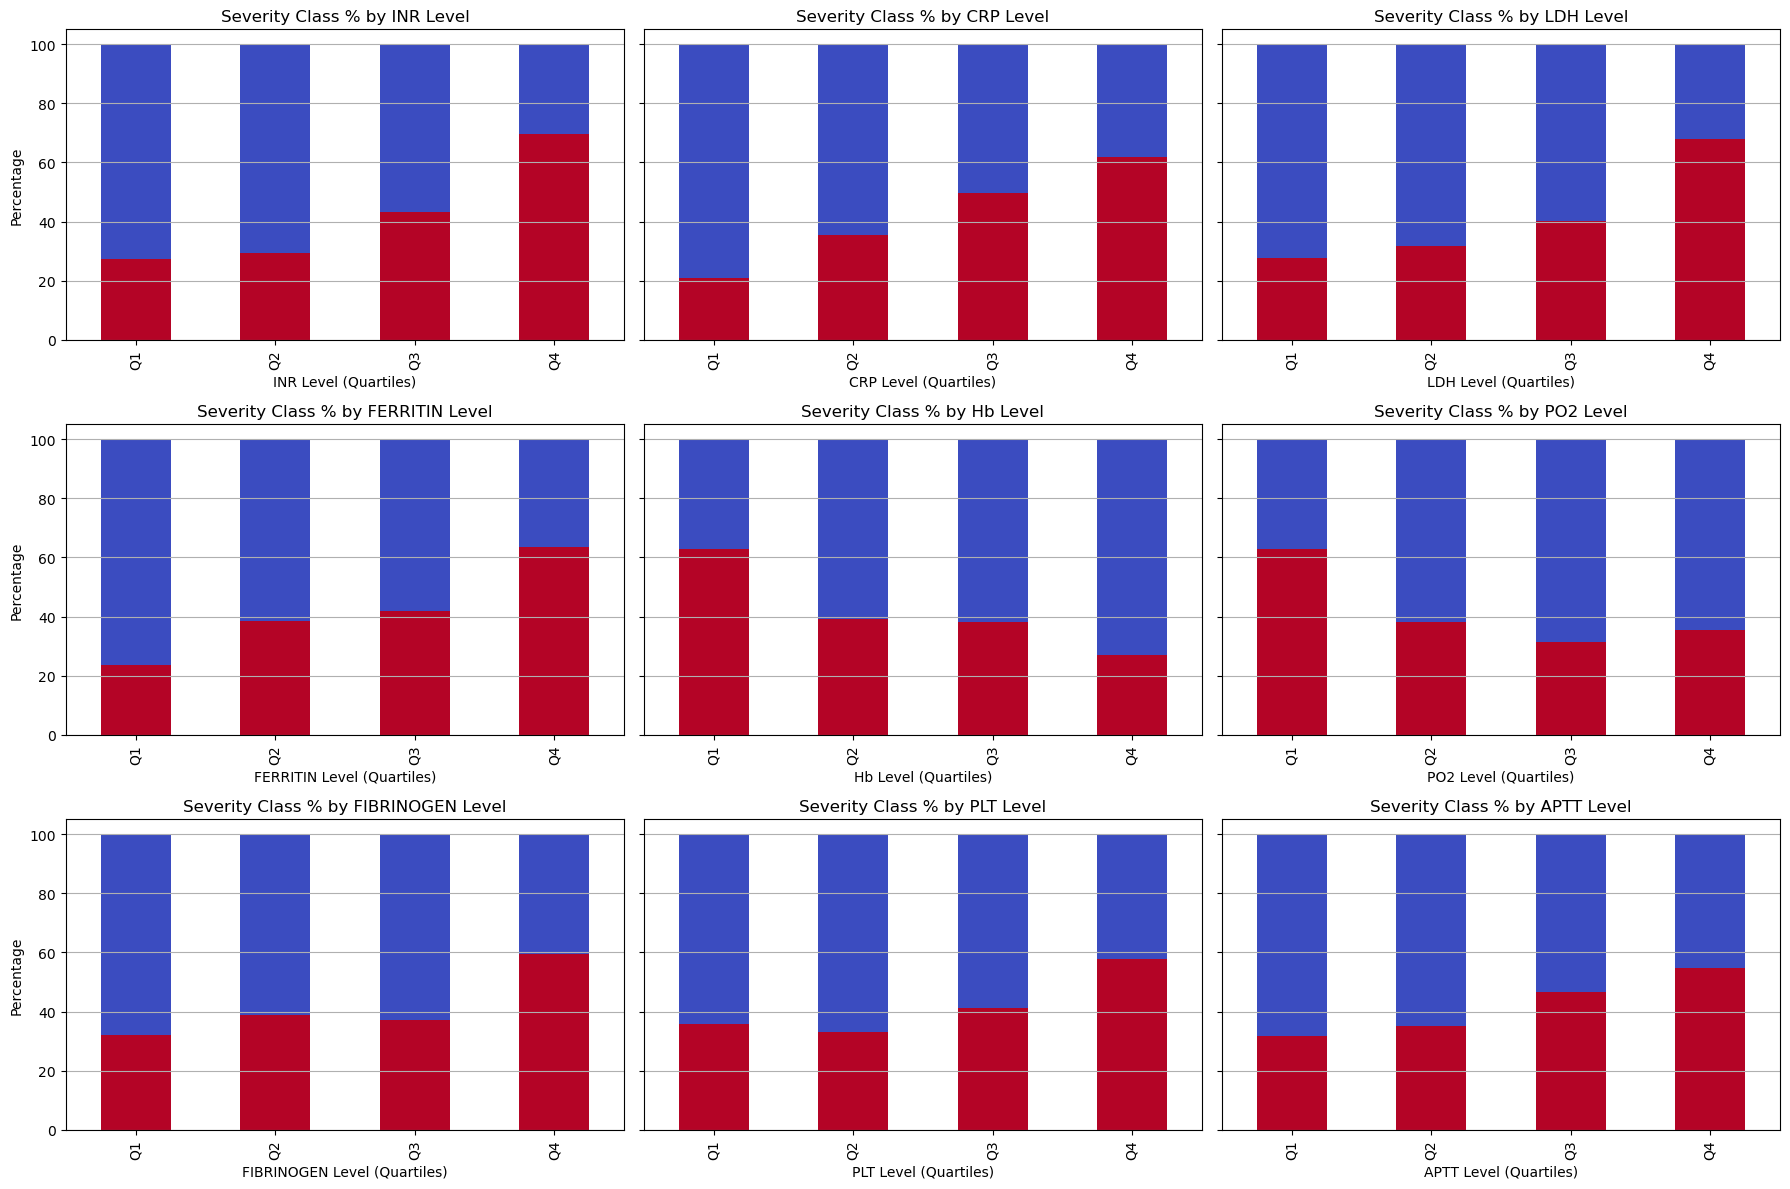

In [ ]:
features_to_analyze = [
    'INR', 'CRP', 'LDH', 'FERRITIN',  'Hb', 'PO2', 
    'FIBRINOGEN', 'PLT', 'APTT'
]

outcome = 'Outcome_numerical'

# Calculate the number of plots needed (1 plot per feature)
num_plots = len(features_to_analyze)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols 

# Set up the matplotlib figure
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 4), sharey=True)

for idx, feature in enumerate(features_to_analyze):
    row = idx // num_cols
    col = idx % num_cols

    # Check if there are sufficient unique values
    num_unique_values = dataset[feature].nunique()
    if num_unique_values < 2:
        print(f"Skipping {feature} due to insufficient unique values.")
        continue
    
    # Define bins based on quantiles if possible
    try:
        # Using numpy's percentile to define bin edges manually
        quantiles = np.percentile(dataset[feature].dropna(), [0, 25, 50, 75, 100])
        bins = np.unique(quantiles)  # Ensure unique bin edges
        if len(bins) > 1:
            dataset[f'{feature}_bins'] = pd.cut(dataset[feature], bins=bins, labels=[f'Q{i+1}' for i in range(len(bins)-1)], include_lowest=True)
        else:
            print(f"Skipping {feature} due to insufficient variation for binning.")
            continue

        # Calculate distribution of outcome within each bin
        class_distribution = dataset.groupby(f'{feature}_bins')[outcome].value_counts().unstack(fill_value=0)
        class_percentages = class_distribution.divide(class_distribution.sum(axis=1), axis=0) * 100
        
        # Plotting
        reversed_coolwarm = matplotlib.colormaps['coolwarm_r']
        ax = class_percentages.plot(kind='bar', stacked=True, colormap=reversed_coolwarm, ax=axes[row, col])
        ax.set_title(f'Severity Class % by {feature} Level')
        ax.set_xlabel(f'{feature} Level (Quartiles)')
        ax.set_ylabel('Percentage')
        ax.grid(axis='y')
        ax.legend().remove()
    except Exception as e:
        print(f"Skipping {feature} due to error: {e}")

# Hide unused axes if any
for i in range(idx + 1, num_rows * num_cols):
    fig.axes[i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


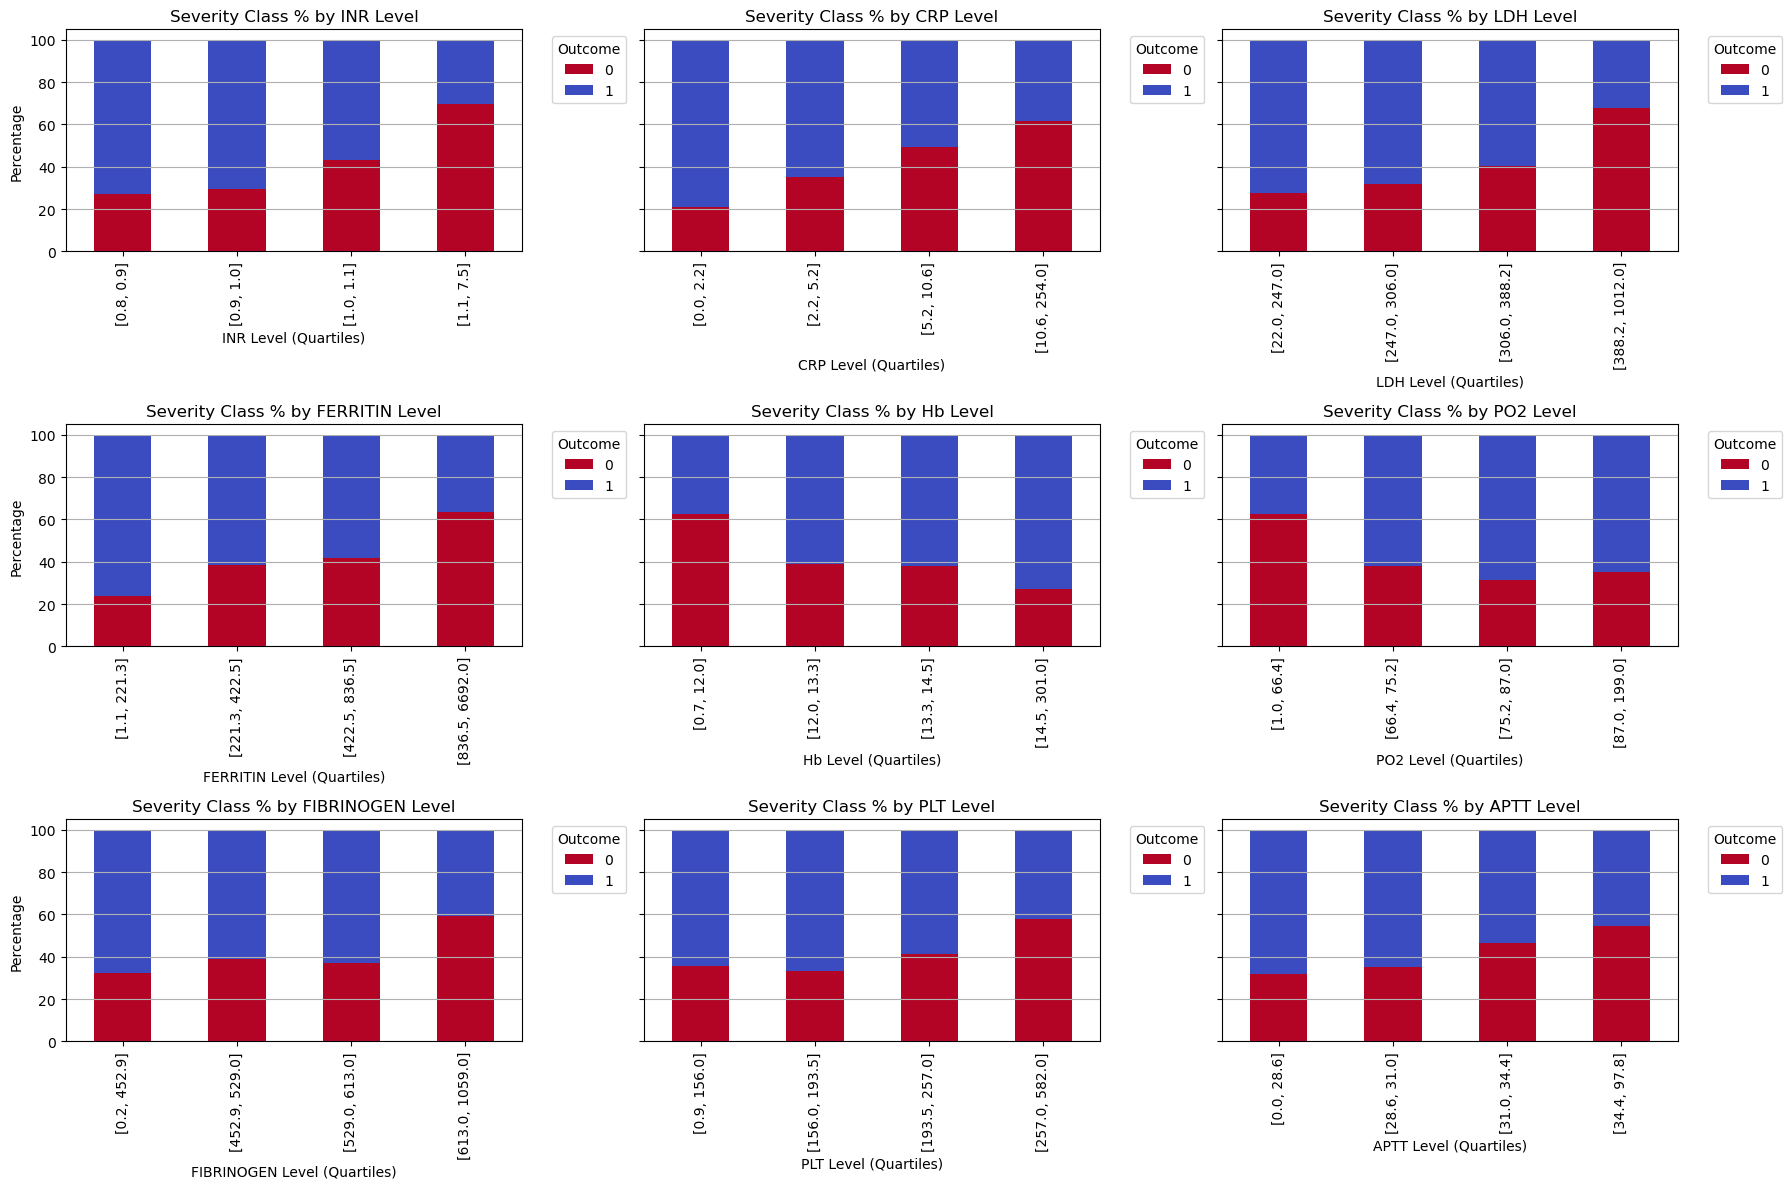

In [ ]:
features_to_analyze = [
    'INR', 'CRP', 'LDH', 'FERRITIN',  'Hb', 'PO2', 
    'FIBRINOGEN', 'PLT', 'APTT'
]

outcome = 'Outcome_numerical'

# Calculate the number of plots needed (1 plot per feature)
num_plots = len(features_to_analyze)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols 

# Set up the matplotlib figure
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 4), sharey=True)

for idx, feature in enumerate(features_to_analyze):
    row = idx // num_cols
    col = idx % num_cols

    # Check if there are sufficient unique values
    num_unique_values = dataset[feature].nunique()
    if num_unique_values < 2:
        print(f"Skipping {feature} due to insufficient unique values.")
        continue
    
    # Define bins based on quantiles if possible
    try:
        # Using numpy's percentile to define bin edges manually
        quantiles = np.percentile(dataset[feature].dropna(), [0, 25, 50, 75, 100])
        bins = np.unique(quantiles)  # Ensure unique bin edges
        if len(bins) > 1:
            # Assigning quartile labels with the actual range for clarity
            bin_labels = [f'[{bins[i]:.1f}, {bins[i+1]:.1f}]' for i in range(len(bins)-1)]
            dataset[f'{feature}_bins'] = pd.cut(dataset[feature], bins=bins, labels=bin_labels, include_lowest=True)
        else:
            print(f"Skipping {feature} due to insufficient variation for binning.")
            continue

        # Calculate distribution of outcome within each bin
        class_distribution = dataset.groupby(f'{feature}_bins')[outcome].value_counts().unstack(fill_value=0)
        class_percentages = class_distribution.divide(class_distribution.sum(axis=1), axis=0) * 100
        
        # Plotting
       
        ax = class_percentages.plot(kind='bar', stacked=True, colormap='coolwarm_r', ax=axes[row, col])
        ax.set_title(f'Severity Class % by {feature} Level')
        ax.set_xlabel(f'{feature} Level (Quartiles)')
        ax.set_ylabel('Percentage')
        ax.grid(axis='y')
        ax.legend(title='Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
    except Exception as e:
        print(f"Skipping {feature} due to error: {e}")

# Hide unused axes if any
for i in range(idx + 1, num_rows * num_cols):
    fig.axes[i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


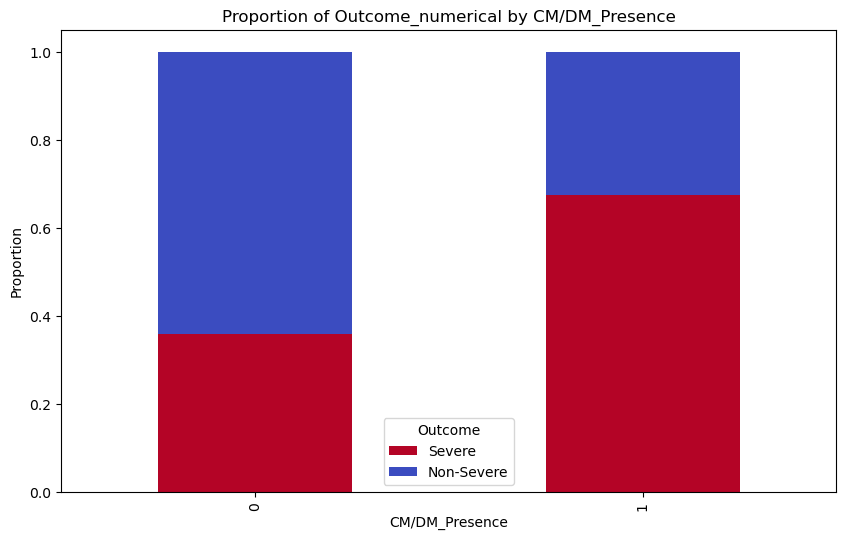

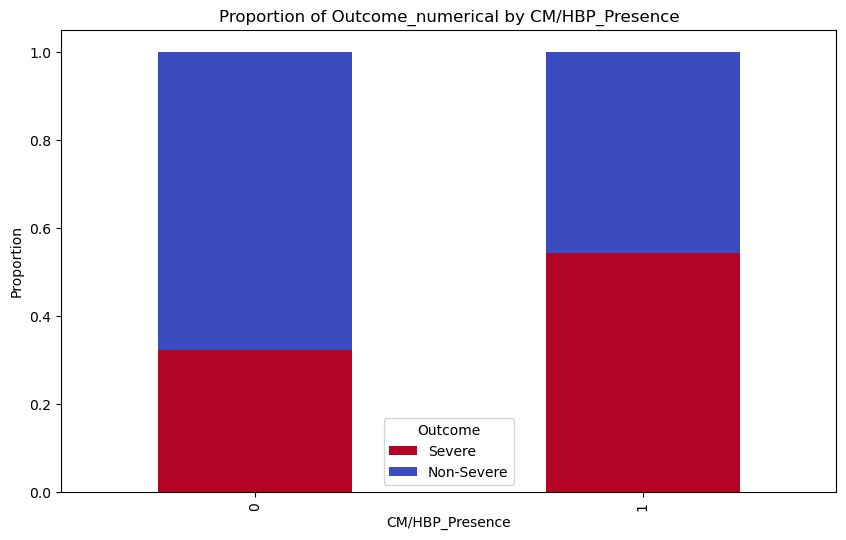

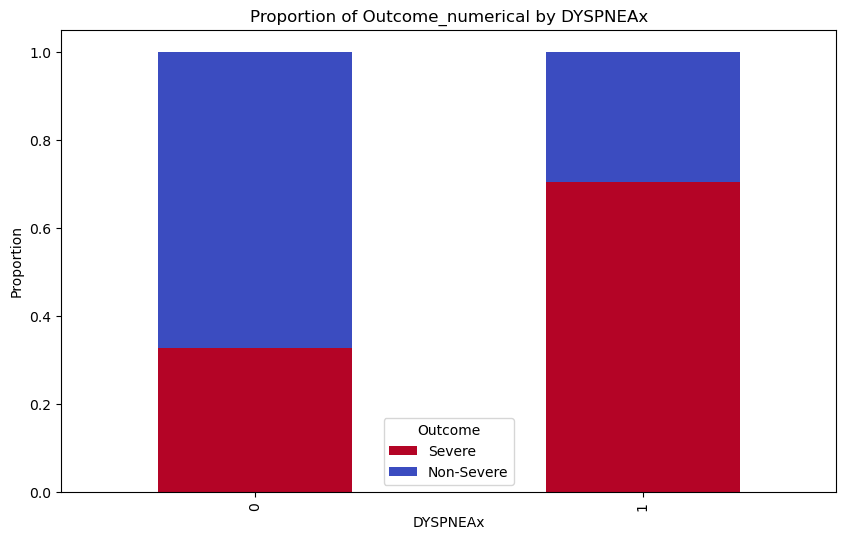

In [81]:
for feature in categorical_features:
    cross_tab = pd.crosstab(index=dataset[feature], columns=dataset[outcome], normalize='index')
    ax = cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm_r')

 

    # Customize legend labels
    handles, labels = ax.get_legend_handles_labels()
    labels = ['Severe', 'Non-Severe']
    ax.legend(handles=handles, labels=labels, title='Outcome')

    plt.title(f'Proportion of {outcome} by {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Proportion')
    plt.show()


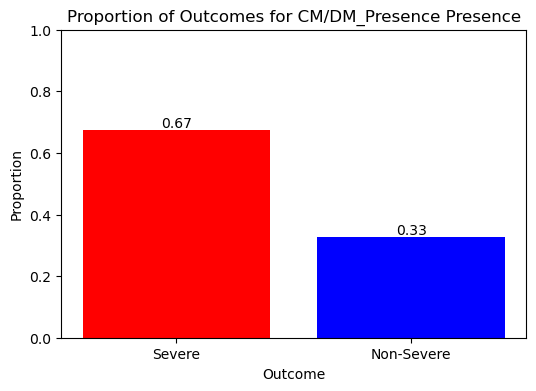

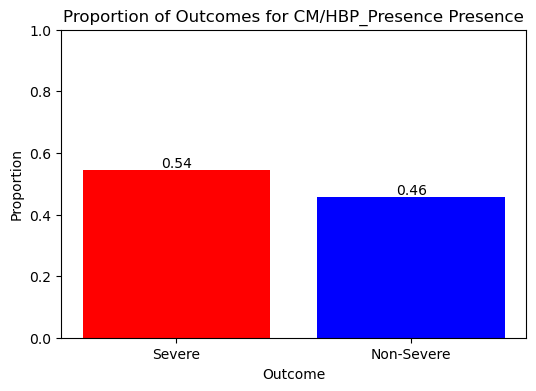

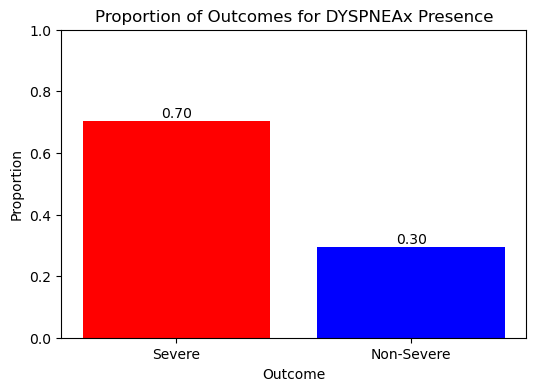

In [ ]:
categorical_features = ['CM/DM_Presence', 'CM/HBP_Presence', 'DYSPNEAx']
outcome = 'Outcome_numerical'

# Filter to include only the presence category (assuming 'Presence' is coded as 1 or a similar flag)
for feature in categorical_features:
    # Filter dataset for presence
    presence_data = dataset[dataset[feature] == 1]  
    
    # Calculate the proportion of each outcome within the presence category
    outcome_counts = presence_data[outcome].value_counts(normalize=True)
    outcome_counts = outcome_counts.reindex([0, 1])  # Ensure both categories are present

    # Plotting
    plt.figure(figsize=(6, 4))
    bars = plt.bar(outcome_counts.index, outcome_counts.values, color=['red', 'blue']) 

    # Customize labels and title
    plt.xlabel('Outcome')
    plt.ylabel('Proportion')
    plt.title(f'Proportion of Outcomes for {feature} Presence')
    plt.xticks(outcome_counts.index, ['Severe', 'Non-Severe'])  
    plt.ylim(0, 1)  

    # Add percentage annotations
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

    plt.show()


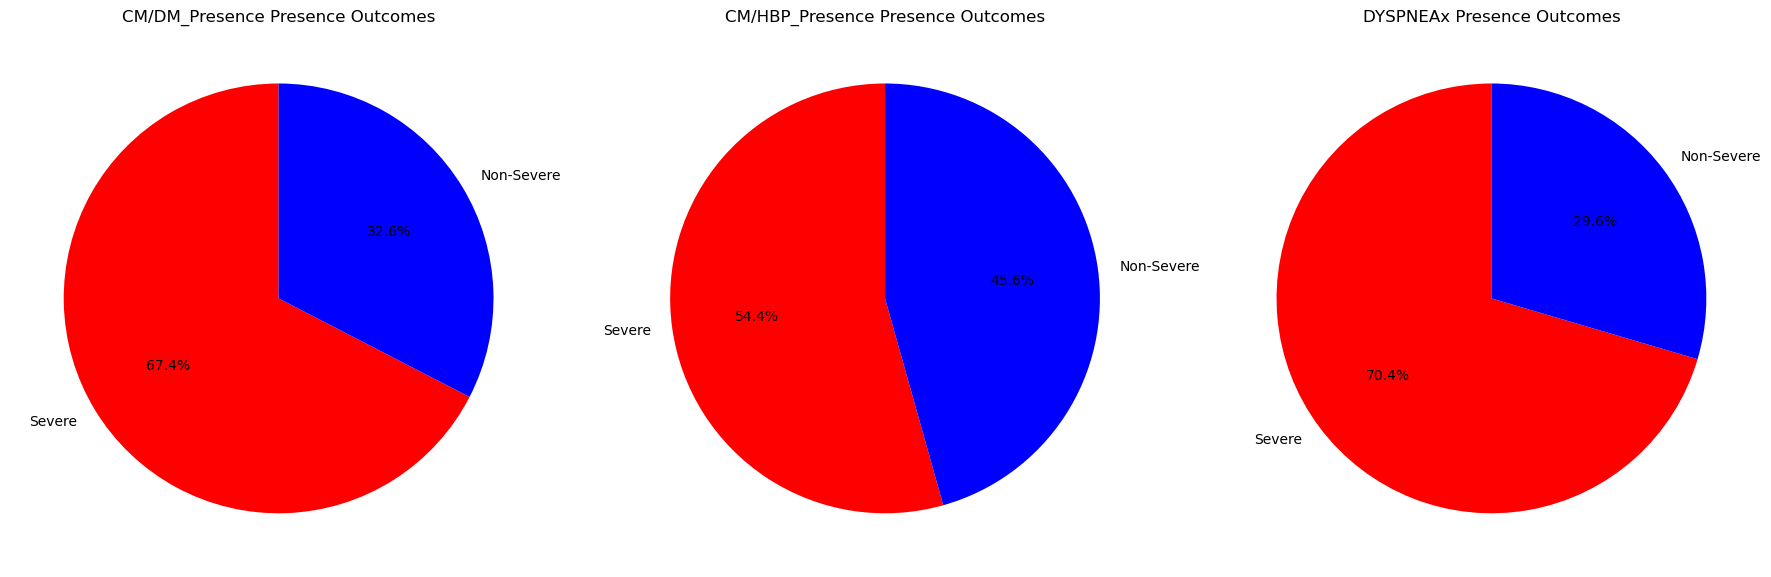

In [ ]:
categorical_features = ['CM/DM_Presence', 'CM/HBP_Presence', 'DYSPNEAx']
outcome = 'Outcome_numerical' 

# Setup the subplot layout: 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Filter and plot only presence data in pie charts
for idx, feature in enumerate(categorical_features):
    # Filter dataset for presence (assuming 'Presence' is coded as 1 or a similar flag)
    presence_data = dataset[dataset[feature] == 1]  

    # Calculate the proportion of each outcome within the presence category
    outcome_counts = presence_data[outcome].value_counts(normalize=True)
    outcome_counts = outcome_counts.reindex([0, 1], fill_value=0) 

    # Colors and labels for the pie chart
    colors = ['red', 'blue']  # Red for Severe, Blue for Non-Severe
    labels = ['Severe', 'Non-Severe'] 

    # Plotting the pie chart for the current feature
    axes[idx].pie(outcome_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
    axes[idx].set_title(f'{feature} Presence Outcomes')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


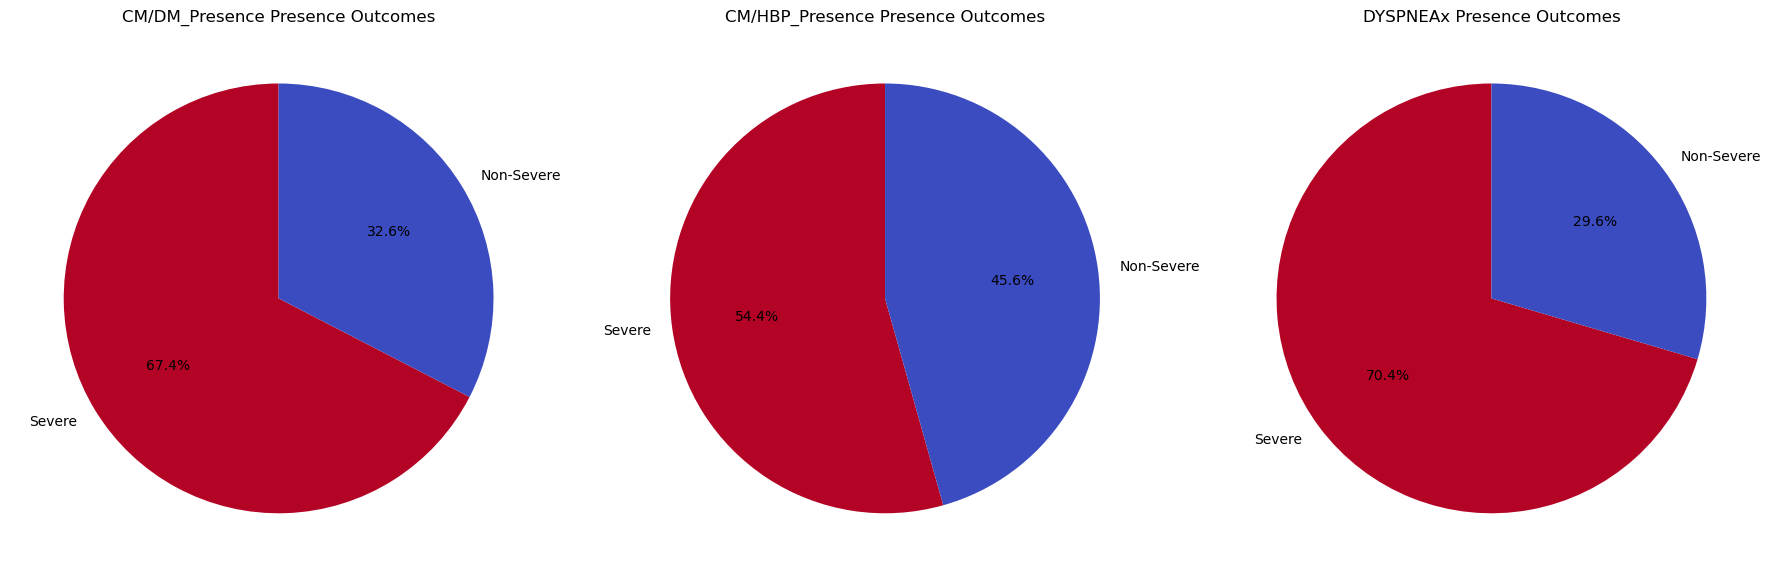

In [ ]:
categorical_features = ['CM/DM_Presence', 'CM/HBP_Presence', 'DYSPNEAx']
outcome = 'Outcome_numerical' 

# Setup the subplot layout: 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Access the colormap
colormap = matplotlib.colormaps['coolwarm_r']

# Compute colors from the colormap
colors = [colormap(i) for i in np.linspace(0, 1, 2)]  # For two categories

for idx, feature in enumerate(categorical_features):
    # Filter dataset for presence (assuming 'Presence' is coded as 1 or a similar flag)
    presence_data = dataset[dataset[feature] == 1] 

    # Calculate the proportion of each outcome within the presence category
    outcome_counts = presence_data[outcome].value_counts(normalize=True)
    outcome_counts = outcome_counts.reindex([0, 1], fill_value=0) 

    # Labels for each slice
    labels = ['Severe', 'Non-Severe'] 

    # Plotting the pie chart for the current feature
    axes[idx].pie(outcome_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
    axes[idx].set_title(f'{feature} Presence Outcomes')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


<Figure size 800x600 with 0 Axes>

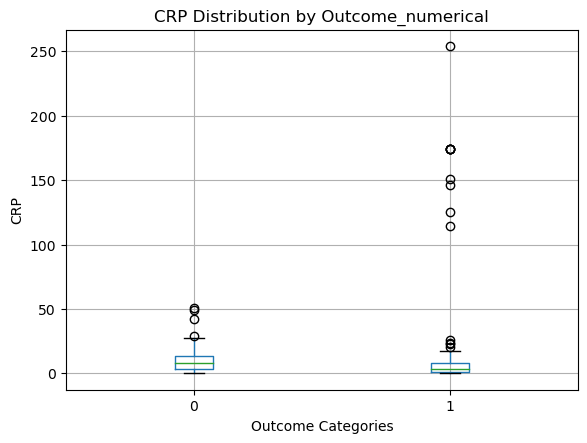

<Figure size 800x600 with 0 Axes>

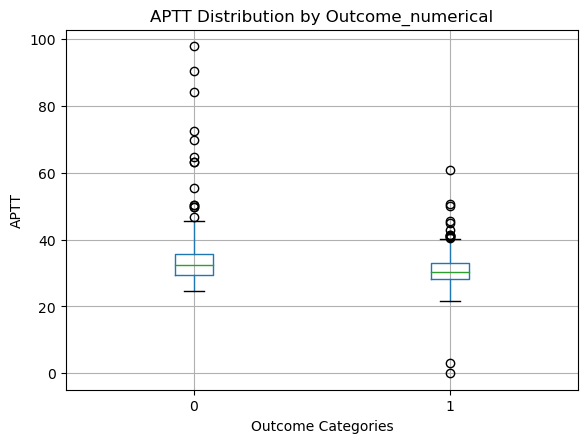

<Figure size 800x600 with 0 Axes>

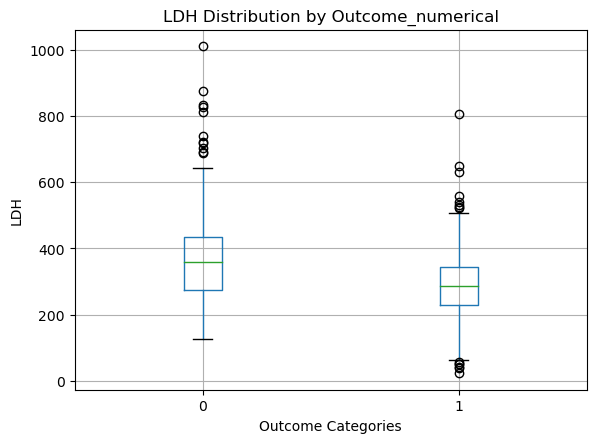

<Figure size 800x600 with 0 Axes>

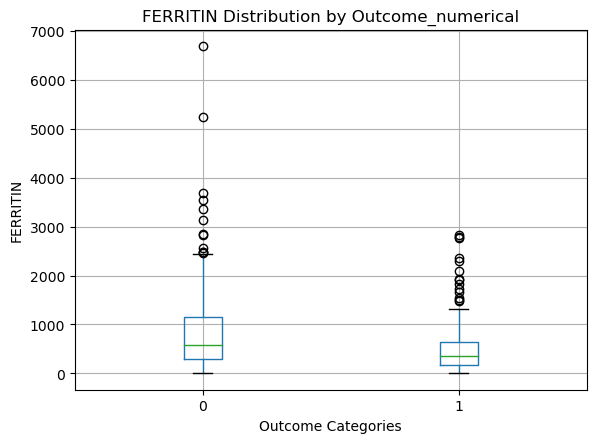

<Figure size 800x600 with 0 Axes>

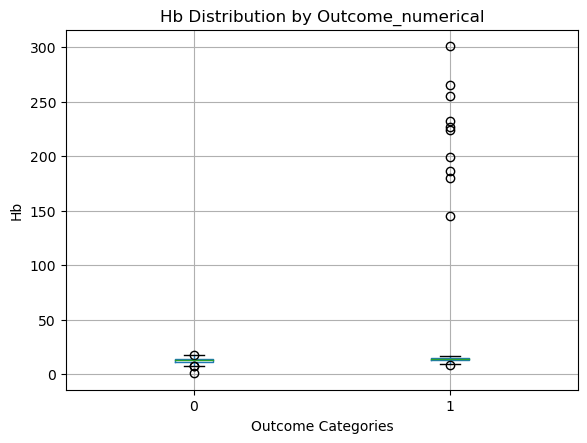

<Figure size 800x600 with 0 Axes>

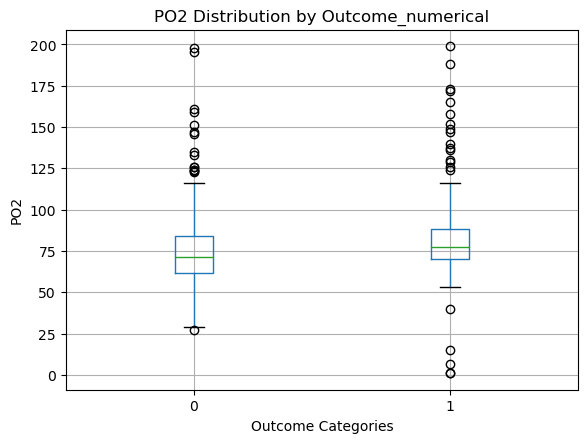

<Figure size 800x600 with 0 Axes>

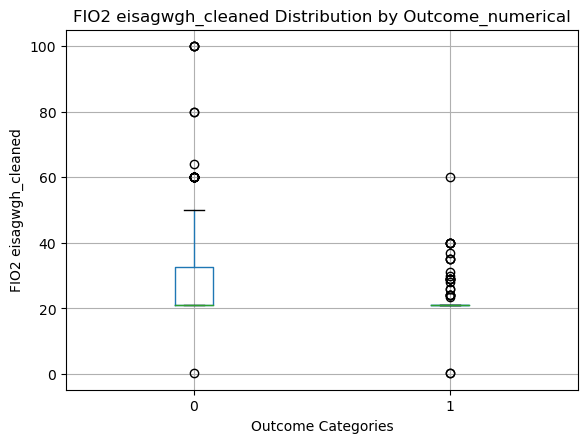

<Figure size 800x600 with 0 Axes>

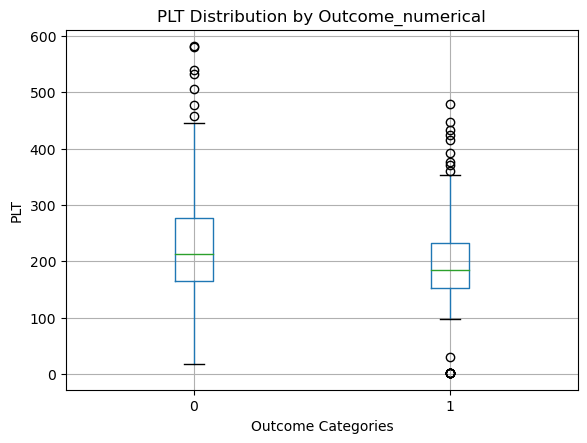

<Figure size 800x600 with 0 Axes>

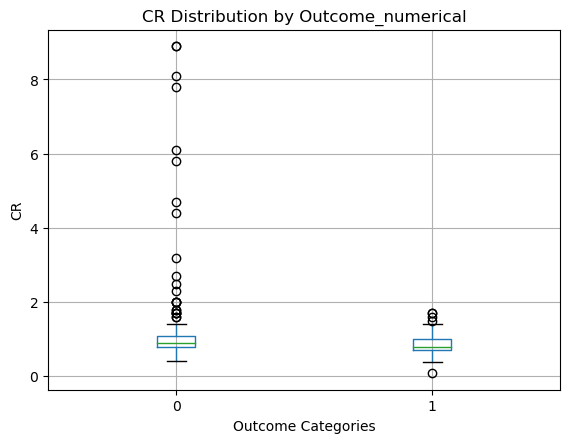

<Figure size 800x600 with 0 Axes>

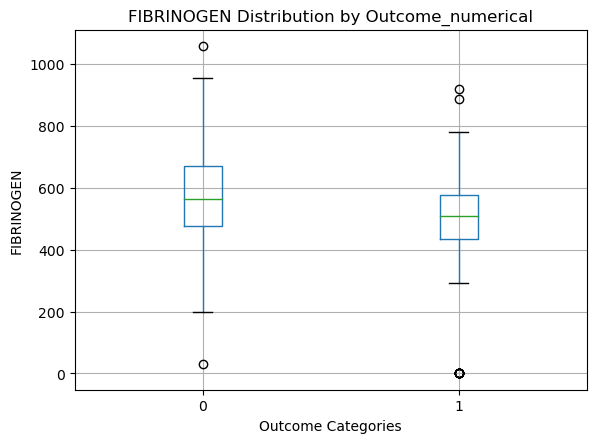

In [59]:
for feature in features_to_analyze:
    plt.figure(figsize=(8, 6))
    dataset.boxplot(column=feature, by=outcome)
    plt.title(f'{feature} Distribution by {outcome}')
    plt.xlabel('Outcome Categories')
    plt.ylabel(feature)
    plt.suptitle('')
    plt.show()




`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



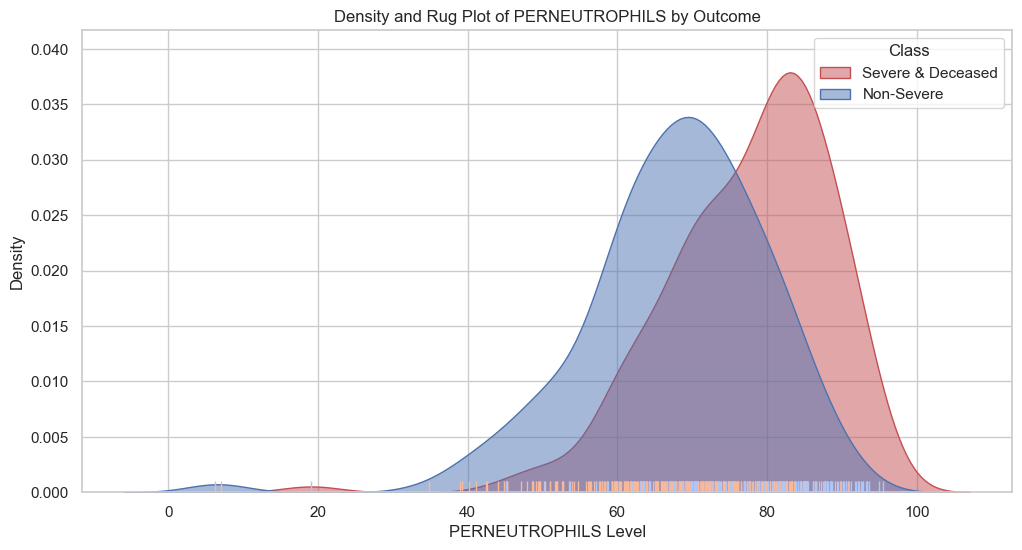

In [ ]:
# Set the style and size of the plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plot density plots for each outcome category with a rug plot
sns.kdeplot(data=dataset[dataset[outcome] == 0], x=feature, shade=True, label='Severe & Deceased', color="r", alpha=0.5)
sns.kdeplot(data=dataset[dataset[outcome] == 1], x=feature, shade=True, label='Non-Severe', color="b", alpha=0.5)
sns.rugplot(data=dataset, x=feature, hue=outcome, palette="coolwarm")

plt.title(f'Density and Rug Plot of {feature} by Outcome')
plt.xlabel(f'{feature} Level')
plt.ylabel('Density')
plt.legend(title='Class')
plt.show()


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


<Figure size 1200x600 with 0 Axes>

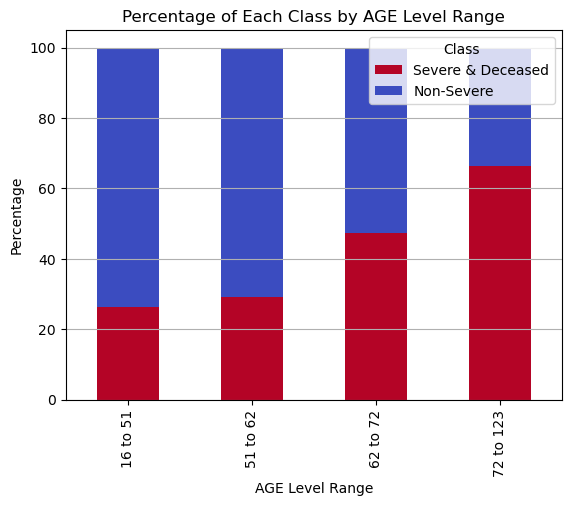

In [ ]:
feature = 'AGE'
outcome = 'Outcome_numerical'

# Set up the figure for plotting
plt.figure(figsize=(12, 6))

# Create quartile bins for the 'Age' feature and ensure custom labels with two decimal places
dataset[f'{feature}_bins'], bin_edges = pd.qcut(dataset[feature], 4, duplicates='drop', retbins=True)  # Quartiles

# Custom bin labels with two decimal places
bin_labels = [f"{bin_edges[i]:.0f} to {bin_edges[i + 1]:.0f}" for i in range(len(bin_edges) - 1)]
dataset[f'{feature}_bins'] = pd.cut(dataset[feature], bins=bin_edges, labels=bin_labels, include_lowest=True)

# Calculate distribution of outcome within each bin
class_distribution = dataset.groupby(f'{feature}_bins')[outcome].value_counts().unstack(fill_value=0)
class_percentages = class_distribution.divide(class_distribution.sum(axis=1), axis=0) * 100 

# Plotting using the reversed coolwarm colormap for binary data
reversed_coolwarm = plt.cm.get_cmap('coolwarm_r')
class_percentages.plot(kind='bar', stacked=True, colormap=reversed_coolwarm)
plt.title(f'Percentage of Each Class by {feature} Level Range')
plt.xlabel(f'{feature} Level Range')
plt.ylabel('Percentage')
plt.grid(axis='y')

# Update the legend with custom labels
plt.legend(title='Class', labels=['Severe & Deceased', 'Non-Severe'])

# Show the plot
plt.show()


In [ ]:
feature = 'INR'
outcome = 'Outcome_numerical'

# Adjust the label generation to ensure uniqueness
bin_labels = [f"{bin_edges[i]:.2f} to {bin_edges[i + 1]:.2f}" for i in range(len(bin_edges) - 1)]

# Set up the figure for plotting
plt.figure(figsize=(12, 6))

# Create quartile bins for the 'Age' feature and ensure custom labels with two decimal places
dataset[f'{feature}_bins'], bin_edges = pd.qcut(dataset[feature], 4, duplicates='drop', retbins=True)  # Quartiles

# Custom bin labels with two decimal places
bin_labels = [f"{bin_edges[i]:.0f} to {bin_edges[i + 1]:.0f}" for i in range(len(bin_edges) - 1)]
dataset[f'{feature}_bins'] = pd.cut(dataset[feature], bins=bin_edges, labels=bin_labels, include_lowest=True)

# Calculate distribution of outcome within each bin
class_distribution = dataset.groupby(f'{feature}_bins')[outcome].value_counts().unstack(fill_value=0)
class_percentages = class_distribution.divide(class_distribution.sum(axis=1), axis=0) * 100 

# Plotting using the reversed coolwarm colormap for binary data
reversed_coolwarm = plt.cm.get_cmap('coolwarm_r')
class_percentages.plot(kind='bar', stacked=True, colormap=reversed_coolwarm)
plt.title(f'Percentage of Each Class by {feature} Level Range')
plt.xlabel(f'{feature} Level Range')
plt.ylabel('Percentage')
plt.grid(axis='y')

# Update the legend with custom labels
plt.legend(title='Class', labels=['Severe & Deceased', 'Non-Severe'])

# Show the plot
plt.show()


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


<Figure size 1200x600 with 0 Axes>

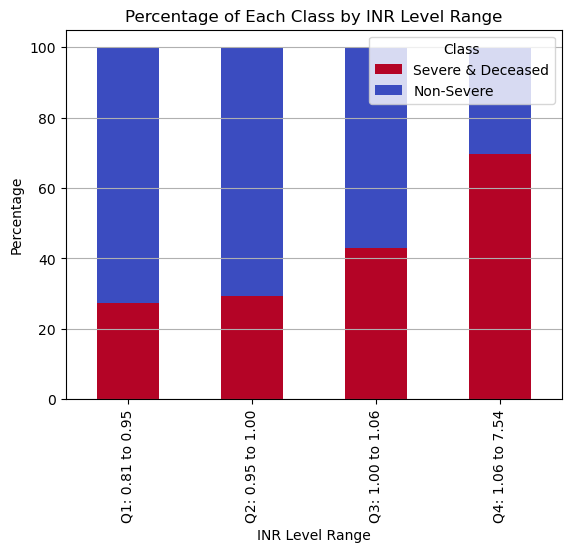

In [ ]:
feature = 'INR'
outcome = 'Outcome_numerical'

# Set up the figure for plotting
plt.figure(figsize=(12, 6))

# Create quartile bins for the feature and ensure custom labels
dataset[f'{feature}_bins'], bin_edges = pd.qcut(dataset[feature], 4, duplicates='drop', retbins=True)  # Quartiles

# Generate unique bin labels with an index to ensure uniqueness
bin_labels = [f"Q{i+1}: {bin_edges[i]:.2f} to {bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)]
dataset[f'{feature}_bins'] = pd.cut(dataset[feature], bins=bin_edges, labels=bin_labels, include_lowest=True)

# Calculate distribution of outcome within each bin
class_distribution = dataset.groupby(f'{feature}_bins')[outcome].value_counts().unstack(fill_value=0)
class_percentages = class_distribution.divide(class_distribution.sum(axis=1), axis=0) * 100  # Convert to percentage

# Plotting using the reversed coolwarm colormap for binary data
reversed_coolwarm = plt.cm.get_cmap('coolwarm_r')
class_percentages.plot(kind='bar', stacked=True, colormap=reversed_coolwarm)
plt.title(f'Percentage of Each Class by {feature} Level Range')
plt.xlabel(f'{feature} Level Range')
plt.ylabel('Percentage')
plt.grid(axis='y')

# Update the legend with custom labels
plt.legend(title='Class', labels=['Severe & Deceased', 'Non-Severe'])

# Show the plot
plt.show()


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


<Figure size 1200x600 with 0 Axes>

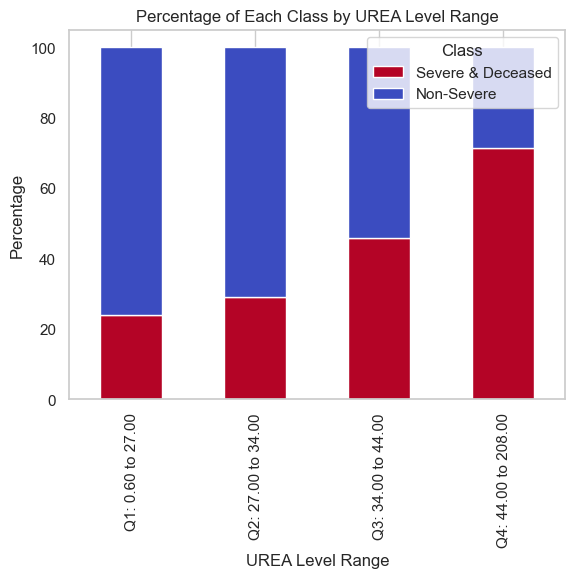

In [ ]:
feature = 'UREA'
outcome = 'Outcome_numerical'

# Set up the figure for plotting
plt.figure(figsize=(12, 6))

# Create quartile bins for the feature and ensure custom labels
dataset[f'{feature}_bins'], bin_edges = pd.qcut(dataset[feature], 4, duplicates='drop', retbins=True)  

# Generate unique bin labels with an index to ensure uniqueness
bin_labels = [f"Q{i+1}: {bin_edges[i]:.2f} to {bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)]
dataset[f'{feature}_bins'] = pd.cut(dataset[feature], bins=bin_edges, labels=bin_labels, include_lowest=True)

# Calculate distribution of outcome within each bin
class_distribution = dataset.groupby(f'{feature}_bins')[outcome].value_counts().unstack(fill_value=0)
class_percentages = class_distribution.divide(class_distribution.sum(axis=1), axis=0) * 100 

# Plotting using the reversed coolwarm colormap for binary data
reversed_coolwarm = plt.cm.get_cmap('coolwarm_r')
class_percentages.plot(kind='bar', stacked=True, colormap=reversed_coolwarm)
plt.title(f'Percentage of Each Class by {feature} Level Range')
plt.xlabel(f'{feature} Level Range')
plt.ylabel('Percentage')
plt.grid(axis='y')

# Update the legend with custom labels
plt.legend(title='Class', labels=['Severe & Deceased', 'Non-Severe'])

# Show the plot
plt.show()




`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



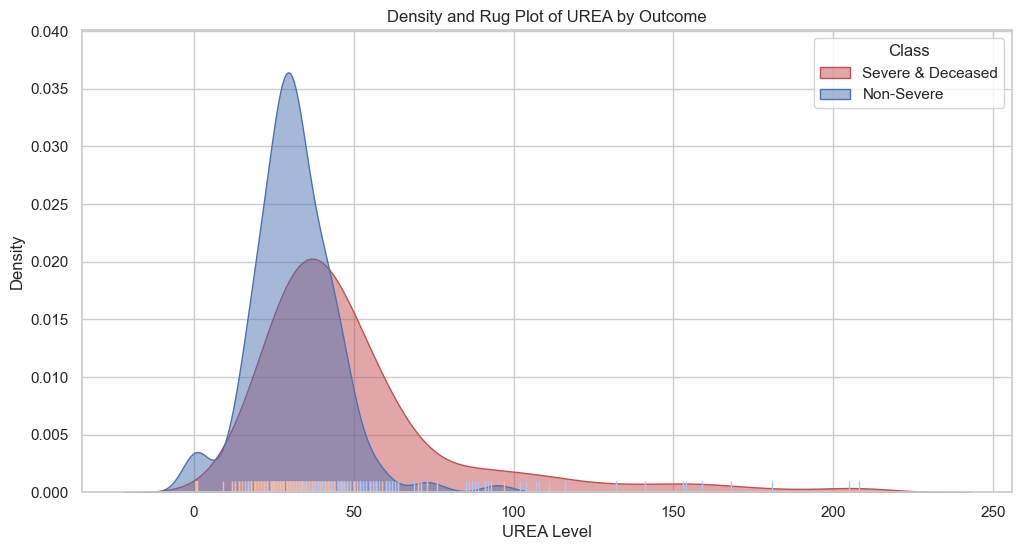

In [ ]:
# Set the style and size of the plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plot density plots for each outcome category with a rug plot
sns.kdeplot(data=dataset[dataset[outcome] == 0], x=feature, shade=True, label='Severe & Deceased', color="r", alpha=0.5)
sns.kdeplot(data=dataset[dataset[outcome] == 1], x=feature, shade=True, label='Non-Severe', color="b", alpha=0.5)
sns.rugplot(data=dataset, x=feature, hue=outcome, palette="coolwarm")

plt.title(f'Density and Rug Plot of {feature} by Outcome')
plt.xlabel(f'{feature} Level')
plt.ylabel('Density')
plt.legend(title='Class')
plt.show()


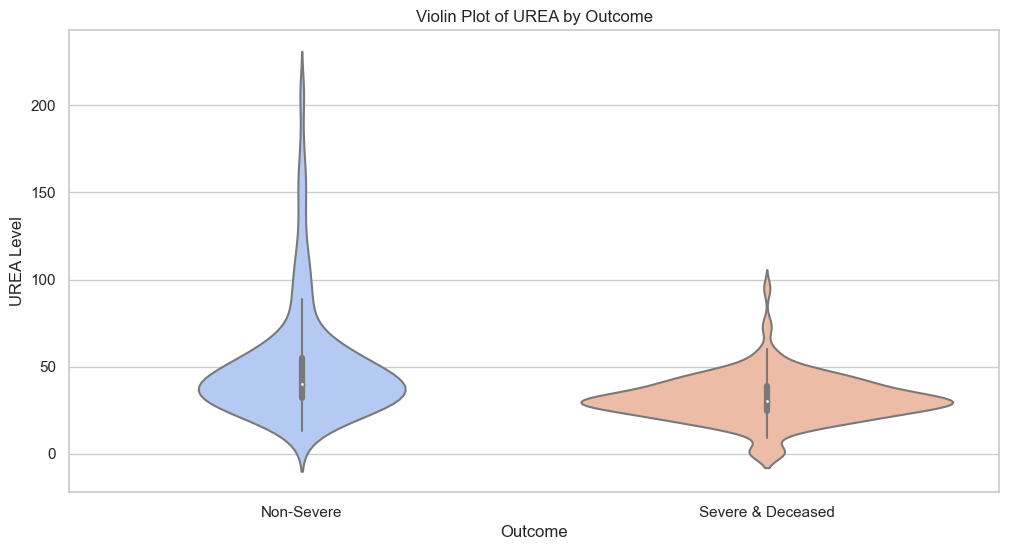

In [ ]:
plt.figure(figsize=(12, 6))

# Create a violin plot
sns.violinplot(x=outcome, y=feature, data=dataset, palette="coolwarm", split=True)

plt.title(f'Violin Plot of {feature} by Outcome')
plt.xlabel('Outcome')
plt.ylabel(f'{feature} Level')
plt.xticks(ticks=[0, 1], labels=['Non-Severe', 'Severe & Deceased']) 

plt.show()


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


<Figure size 1200x600 with 0 Axes>

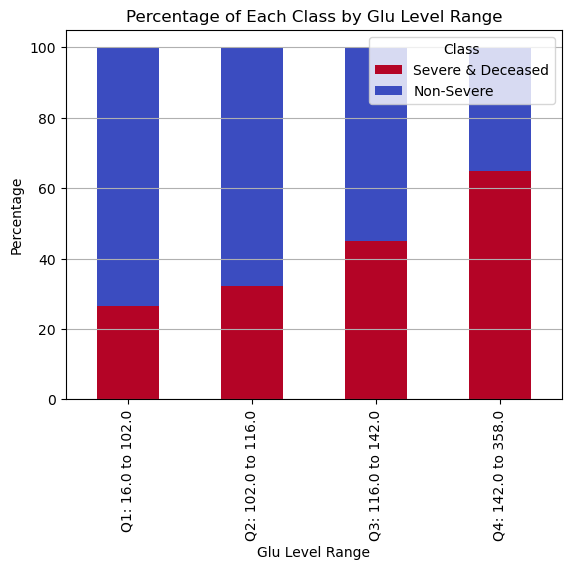

In [ ]:
feature = 'Glu'
outcome = 'Outcome_numerical'

# Set up the figure for plotting
plt.figure(figsize=(12, 6))

# Create quartile bins for the feature and ensure custom labels
dataset[f'{feature}_bins'], bin_edges = pd.qcut(dataset[feature], 4, duplicates='drop', retbins=True) 

# Generate unique bin labels with an index to ensure uniqueness
bin_labels = [f"Q{i+1}: {bin_edges[i]:.1f} to {bin_edges[i+1]:.1f}" for i in range(len(bin_edges)-1)]
dataset[f'{feature}_bins'] = pd.cut(dataset[feature], bins=bin_edges, labels=bin_labels, include_lowest=True)

# Calculate distribution of outcome within each bin
class_distribution = dataset.groupby(f'{feature}_bins')[outcome].value_counts().unstack(fill_value=0)
class_percentages = class_distribution.divide(class_distribution.sum(axis=1), axis=0) * 100 

# Plotting using the reversed coolwarm colormap for binary data
reversed_coolwarm = plt.cm.get_cmap('coolwarm_r')
class_percentages.plot(kind='bar', stacked=True, colormap=reversed_coolwarm)
plt.title(f'Percentage of Each Class by {feature} Level Range')
plt.xlabel(f'{feature} Level Range')
plt.ylabel('Percentage')
plt.grid(axis='y')

# Update the legend with custom labels
plt.legend(title='Class', labels=['Severe & Deceased', 'Non-Severe'])

# Show the plot
plt.show()


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


<Figure size 1200x600 with 0 Axes>

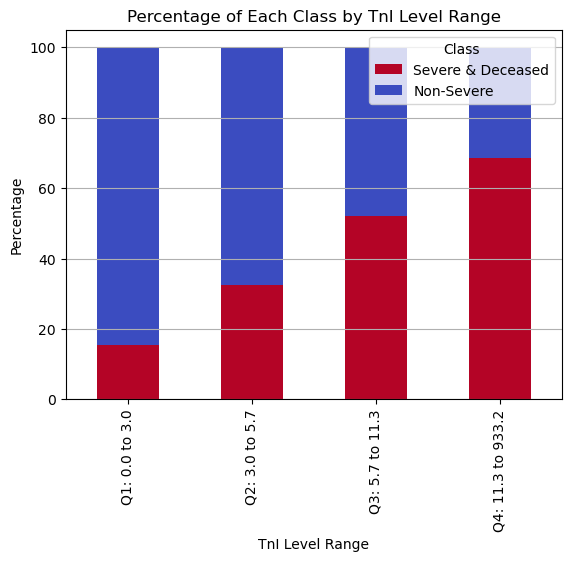

In [ ]:
feature = 'TnI'
outcome = 'Outcome_numerical'

# Set up the figure for plotting
plt.figure(figsize=(12, 6))

# Create quartile bins for the feature and ensure custom labels
dataset[f'{feature}_bins'], bin_edges = pd.qcut(dataset[feature], 4, duplicates='drop', retbins=True)  

# Generate unique bin labels with an index to ensure uniqueness
bin_labels = [f"Q{i+1}: {bin_edges[i]:.1f} to {bin_edges[i+1]:.1f}" for i in range(len(bin_edges)-1)]
dataset[f'{feature}_bins'] = pd.cut(dataset[feature], bins=bin_edges, labels=bin_labels, include_lowest=True)

# Calculate distribution of outcome within each bin
class_distribution = dataset.groupby(f'{feature}_bins')[outcome].value_counts().unstack(fill_value=0)
class_percentages = class_distribution.divide(class_distribution.sum(axis=1), axis=0) * 100 

# Plotting using the reversed coolwarm colormap for binary data
reversed_coolwarm = plt.cm.get_cmap('coolwarm_r')
class_percentages.plot(kind='bar', stacked=True, colormap=reversed_coolwarm)
plt.title(f'Percentage of Each Class by {feature} Level Range')
plt.xlabel(f'{feature} Level Range')
plt.ylabel('Percentage')
plt.grid(axis='y')

# Update the legend with custom labels
plt.legend(title='Class', labels=['Severe & Deceased', 'Non-Severe'])

# Show the plot
plt.show()




`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



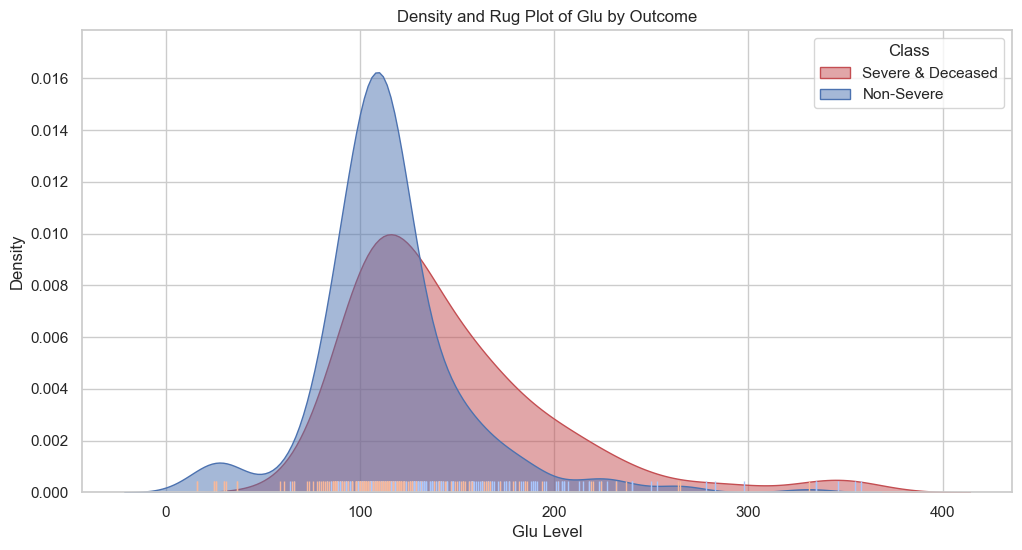

In [ ]:
# Set the style and size of the plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plot density plots for each outcome category with a rug plot
sns.kdeplot(data=dataset[dataset[outcome] == 0], x=feature, shade=True, label='Severe & Deceased', color="r", alpha=0.5)
sns.kdeplot(data=dataset[dataset[outcome] == 1], x=feature, shade=True, label='Non-Severe', color="b", alpha=0.5)
sns.rugplot(data=dataset, x=feature, hue=outcome, palette="coolwarm")

plt.title(f'Density and Rug Plot of {feature} by Outcome')
plt.xlabel(f'{feature} Level')
plt.ylabel('Density')
plt.legend(title='Class')
plt.show()


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


<Figure size 1200x600 with 0 Axes>

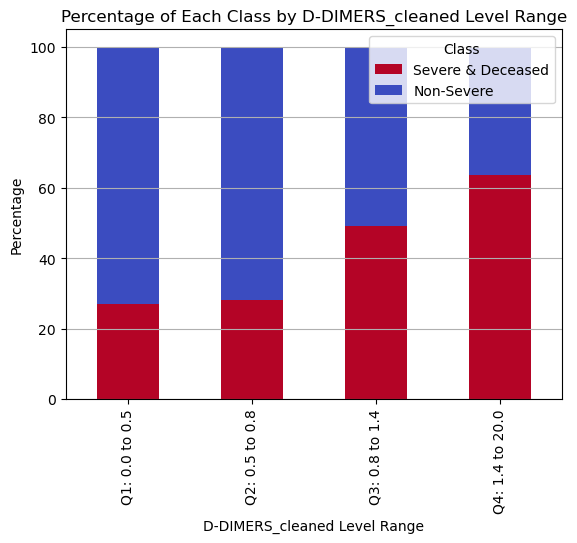

In [ ]:
feature = 'D-DIMERS_cleaned'
outcome = 'Outcome_numerical'

# Set up the figure for plotting
plt.figure(figsize=(12, 6))

# Create quartile bins for the feature and ensure custom labels
dataset[f'{feature}_bins'], bin_edges = pd.qcut(dataset[feature], 4, duplicates='drop', retbins=True) 

# Generate unique bin labels with an index to ensure uniqueness
bin_labels = [f"Q{i+1}: {bin_edges[i]:.1f} to {bin_edges[i+1]:.1f}" for i in range(len(bin_edges)-1)]
dataset[f'{feature}_bins'] = pd.cut(dataset[feature], bins=bin_edges, labels=bin_labels, include_lowest=True)

# Calculate distribution of outcome within each bin
class_distribution = dataset.groupby(f'{feature}_bins')[outcome].value_counts().unstack(fill_value=0)
class_percentages = class_distribution.divide(class_distribution.sum(axis=1), axis=0) * 100  

# Plotting using the reversed coolwarm colormap for binary data
reversed_coolwarm = plt.cm.get_cmap('coolwarm_r')
class_percentages.plot(kind='bar', stacked=True, colormap=reversed_coolwarm)
plt.title(f'Percentage of Each Class by {feature} Level Range')
plt.xlabel(f'{feature} Level Range')
plt.ylabel('Percentage')
plt.grid(axis='y')

# Update the legend with custom labels
plt.legend(title='Class', labels=['Severe & Deceased', 'Non-Severe'])

# Show the plot
plt.show()




`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



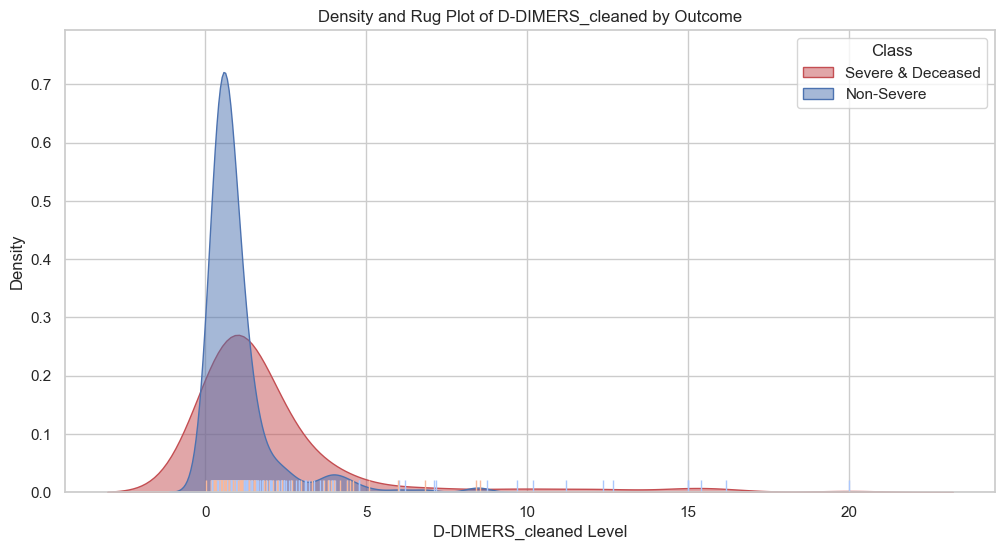

In [ ]:
# Set the style and size of the plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plot density plots for each outcome category with a rug plot
sns.kdeplot(data=dataset[dataset[outcome] == 0], x=feature, shade=True, label='Severe & Deceased', color="r", alpha=0.5)
sns.kdeplot(data=dataset[dataset[outcome] == 1], x=feature, shade=True, label='Non-Severe', color="b", alpha=0.5)
sns.rugplot(data=dataset, x=feature, hue=outcome, palette="coolwarm")

plt.title(f'Density and Rug Plot of {feature} by Outcome')
plt.xlabel(f'{feature} Level')
plt.ylabel('Density')
plt.legend(title='Class')
plt.show()


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


<Figure size 3000x1000 with 0 Axes>

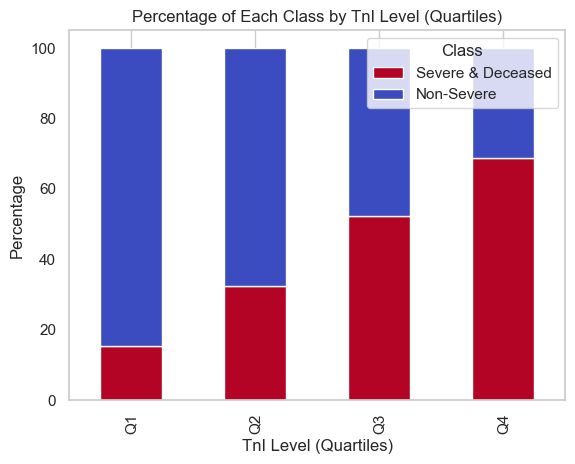

In [ ]:
feature = 'TnI'
outcome = 'Outcome_numerical'

# Set up the figure for plotting
plt.figure(figsize=(30, 10))

# Create quartile bins for the 'TnI' feature and assign quartile labels
dataset[f'{feature}_bins'] = pd.qcut(dataset[feature], 4, duplicates='drop', labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Calculate distribution of outcome within each bin
class_distribution = dataset.groupby(f'{feature}_bins')[outcome].value_counts().unstack(fill_value=0)
class_percentages = class_distribution.divide(class_distribution.sum(axis=1), axis=0) * 100 

# Plotting using the reversed coolwarm colormap for binary data
reversed_coolwarm = plt.cm.get_cmap('coolwarm_r')
class_percentages.plot(kind='bar', stacked=True, colormap=reversed_coolwarm)
plt.title(f'Percentage of Each Class by {feature} Level (Quartiles)')
plt.xlabel(f'{feature} Level (Quartiles)')
plt.ylabel('Percentage')
plt.grid(axis='y')

# Update the legend with custom labels
plt.legend(title='Class', labels=['Severe & Deceased', 'Non-Severe'])

# Show the plot
plt.show()




`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



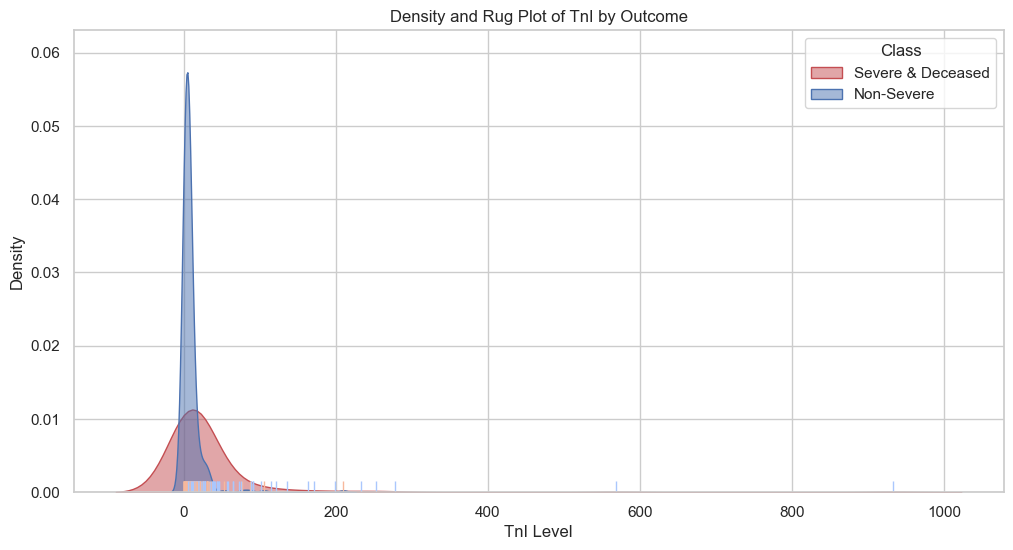

In [ ]:
# Set the style and size of the plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plot density plots for each outcome category with a rug plot
sns.kdeplot(data=dataset[dataset[outcome] == 0], x=feature, shade=True, label='Severe & Deceased', color="r", alpha=0.5)
sns.kdeplot(data=dataset[dataset[outcome] == 1], x=feature, shade=True, label='Non-Severe', color="b", alpha=0.5)
sns.rugplot(data=dataset, x=feature, hue=outcome, palette="coolwarm")

plt.title(f'Density and Rug Plot of {feature} by Outcome')
plt.xlabel(f'{feature} Level')
plt.ylabel('Density')
plt.legend(title='Class')
plt.show()


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


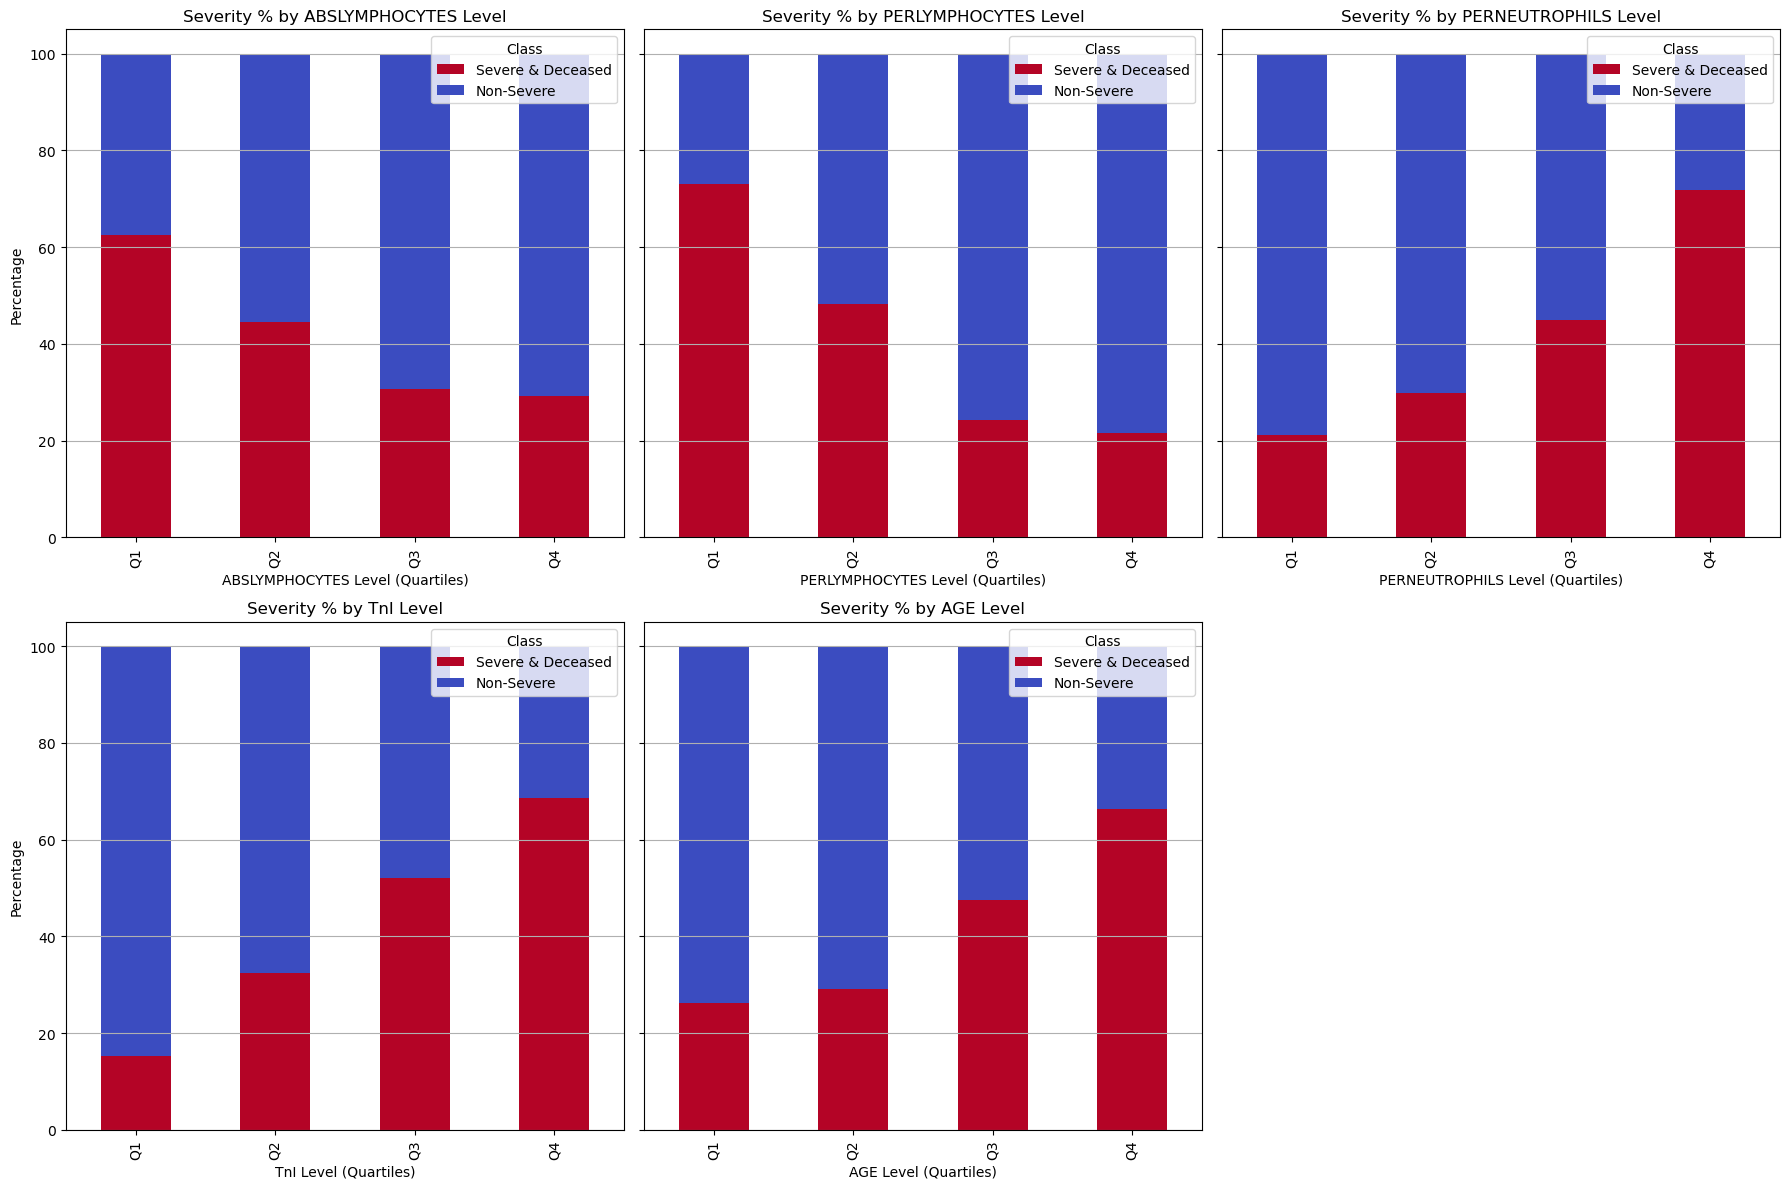

In [ ]:
features_to_analyze = ['ABSLYMPHOCYTES', 'PERLYMPHOCYTES', 'PERNEUTROPHILS', 'TnI', 'AGE']
outcome = 'Outcome_numerical'  

# Set up the matplotlib figure
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)  
axes = axes.flatten()  

for idx, feature in enumerate(features_to_analyze):
    # Create quartile bins for the current feature and ensure custom labels with two decimal places
    dataset[f'{feature}_bins'] = pd.qcut(dataset[feature], 4, duplicates='drop', labels=['Q1', 'Q2', 'Q3', 'Q4'])
    
    # Calculate distribution of outcome within each bin
    class_distribution = dataset.groupby(f'{feature}_bins')[outcome].value_counts().unstack(fill_value=0)
    class_percentages = class_distribution.divide(class_distribution.sum(axis=1), axis=0) * 100  
    
    # Plotting using the subplot axis
    reversed_coolwarm = plt.cm.get_cmap('coolwarm_r')
    class_percentages.plot(kind='bar', stacked=True, colormap=reversed_coolwarm, ax=axes[idx])
    axes[idx].set_title(f'Severity % by {feature} Level')
    axes[idx].set_xlabel(f'{feature} Level (Quartiles)')
    axes[idx].set_ylabel('Percentage')
    axes[idx].grid(axis='y')
    
    # Update the legend
    axes[idx].legend(title='Class', labels=['Severe & Deceased', 'Non-Severe'])

# Hide the last subplot if unused (since we have only 5 features)
axes[-1].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


<Figure size 1600x800 with 0 Axes>

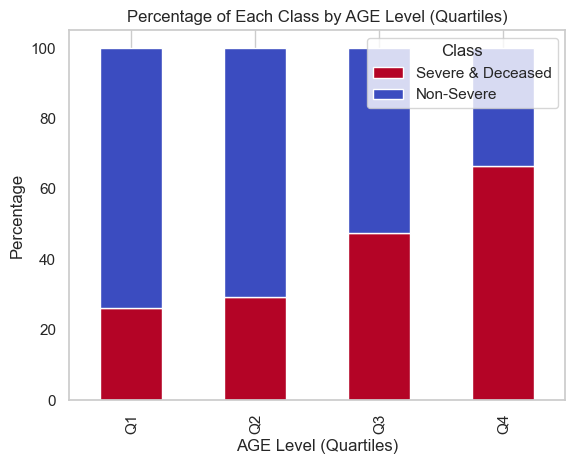

In [ ]:
feature = 'AGE'
outcome = 'Outcome_numerical' 

# Set up the figure for plotting
plt.figure(figsize=(16, 8))

# Create quartile bins for the 'Age' feature and assign quartile labels
dataset[f'{feature}_bins'] = pd.qcut(dataset[feature], 4, duplicates='drop', labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Calculate distribution of outcome within each bin
class_distribution = dataset.groupby(f'{feature}_bins')[outcome].value_counts().unstack(fill_value=0)
class_percentages = class_distribution.divide(class_distribution.sum(axis=1), axis=0) * 100 

# Plotting using the reversed coolwarm colormap for binary data
reversed_coolwarm = plt.cm.get_cmap('coolwarm_r')
class_percentages.plot(kind='bar', stacked=True, colormap=reversed_coolwarm)
plt.title(f'Percentage of Each Class by {feature} Level (Quartiles)')
plt.xlabel(f'{feature} Level (Quartiles)')
plt.ylabel('Percentage')
plt.grid(axis='y')

# Update the legend with custom labels
plt.legend(title='Class', labels=['Severe & Deceased', 'Non-Severe'])

# Show the plot
plt.show()




`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



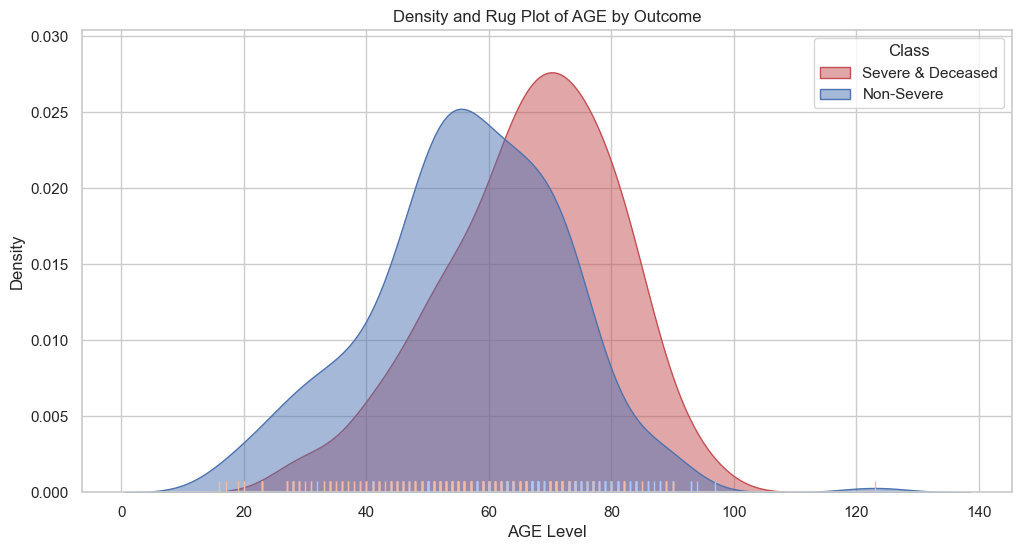

In [ ]:
# Set the style and size of the plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plot density plots for each outcome category with a rug plot
sns.kdeplot(data=dataset[dataset[outcome] == 0], x=feature, shade=True, label='Severe & Deceased', color="r", alpha=0.5)
sns.kdeplot(data=dataset[dataset[outcome] == 1], x=feature, shade=True, label='Non-Severe', color="b", alpha=0.5)
sns.rugplot(data=dataset, x=feature, hue=outcome, palette="coolwarm")

plt.title(f'Density and Rug Plot of {feature} by Outcome')
plt.xlabel(f'{feature} Level')
plt.ylabel('Density')
plt.legend(title='Class')
plt.show()
